# LightGBM

## 0. 前準備

In [1]:
# セル直下に直接図示.
%matplotlib inline

# グラフおよびデザインに関するモジュール.
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

# air passenger データセット.
from sandbox.datasets import air_passengers

from sandbox.features.features import get_features                # 特徴量生成モジュール.
from sandbox.model_selection import (
    train_test_split,                                             # データ分割 (scikit-learn と同じ)
    GroupTimeSeriesSplit,                                         # 時系列用CV spliter
    LightGBMOptunaStepwiseSearchCV                                # CVを伴うlightGBM用ハイパーパラメータ探索
)
from sandbox.ensemble.boost import LightGBMRegressor              # lightGBM回帰器
from sandbox.metrics.score import mean_absolute_percentage_error  # MAPE(scikit-learn と同じ)

sns.set()

## 1. テストデータの準備

### 1.1. AirPassengers データ Overview

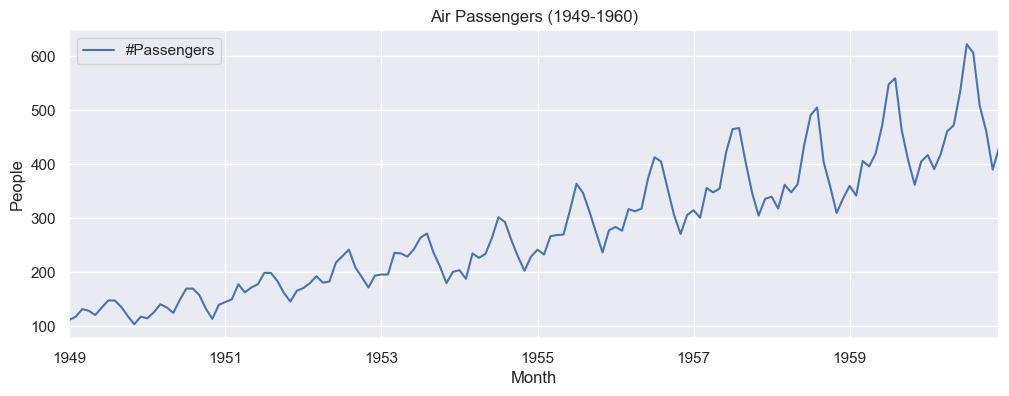

In [2]:
data = air_passengers.load().data

fig, ax = plt.subplots(figsize=(12, 4))
data.plot(y="#Passengers", ax=ax)
ax.set_ylabel("People")
ax.set_title("Air Passengers (1949-1960)")
plt.show()

In [3]:
data.head(10)

,#Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0
1949-06-01,135.0
1949-07-01,148.0
1949-08-01,148.0
1949-09-01,136.0


### 1.2. 特徴量生成

　日付に関する特徴量を作成.

In [4]:
# indexに設定されているMonthをもとに特徴量を生成するためindexから列に変換.
data.reset_index(inplace=True)

# 特徴量の生成.
# column_valuesで指定した列に対して特徴量を生成する.
# グループ単位で処理する場合にはcolumn_idでグループを区切る列名を指定する. 今回はないのでNone.
# window, shift系の処理をする場合に列順がある場合にはsort_valuesで指定する.
# func_param_list に処理する特徴量メソッドを設定する.
column_values = ["Month"]
column_id = None
sort_values = ["Month"]
func_params_list = [
    {"func_name": "month", "func_params": None},
    {"func_name": "year", "func_params": None},
]

data_ts = get_features(
    data,
    column_values=column_values,
    column_id=column_id,
    sort_values=sort_values,
    func_params_list=func_params_list
)

data_ts.head(10)

,index,Month,#Passengers,Month__month,Month__year
0,0,1949-01-01,112.0,1,1949
1,1,1949-02-01,118.0,2,1949
2,2,1949-03-01,132.0,3,1949
3,3,1949-04-01,129.0,4,1949
4,4,1949-05-01,121.0,5,1949
5,5,1949-06-01,135.0,6,1949
6,6,1949-07-01,148.0,7,1949
7,7,1949-08-01,148.0,8,1949
8,8,1949-09-01,136.0,9,1949
9,9,1949-10-01,119.0,10,1949


　lag系, window関数系の特徴量を生成.

In [5]:
# 予測期間は先12ヶ月とすれば, lag=12以上であれば移動平均やラグについて過去データから生成されたものとして取り扱える.
# (予測期間がNULLでも特徴量として有効)
column_values = ["#Passengers"]
column_id = None
sort_values = ["Month"]
func_params_list = [
    {"func_name": "lag", "func_params": [{"lag": 12},]},
    {"func_name": "rolling", "func_params": [
        {"lag": 12, "window": 6, "stats": ["mean",]},
        {"lag": 12, "window": 12, "stats": ["mean",]},
        {"lag": 12, "window": 18, "stats": ["mean",]},
        {"lag": 12, "window": 24, "stats": ["mean",]},
    ]},
]

data_ts_shifting = get_features(
    data_ts,
    column_values=column_values,
    column_id=column_id,
    sort_values=sort_values,
    func_params_list=func_params_list
)

data_ts_shifting.iloc[20:30]

,level_0,index,Month,#Passengers,Month__month,Month__year,#Passengers__lag_lag_12,#Passengers__rolling_mean_lag_12_window_6,#Passengers__rolling_mean_lag_12_window_12,#Passengers__rolling_mean_lag_12_window_18,#Passengers__rolling_mean_lag_12_window_24
20,20,20,1950-09-01,158.0,9,1950,136.0,136.166667,NaN,NaN,NaN
21,21,21,1950-10-01,133.0,10,1950,119.0,134.500000,NaN,NaN,NaN
22,22,22,1950-11-01,114.0,11,1950,104.0,131.666667,NaN,NaN,NaN
23,23,23,1950-12-01,140.0,12,1950,118.0,128.833333,126.666667,NaN,NaN
24,24,24,1951-01-01,145.0,1,1951,115.0,123.333333,126.916667,NaN,NaN
25,25,25,1951-02-01,150.0,2,1951,126.0,119.666667,127.583333,NaN,NaN
26,26,26,1951-03-01,178.0,3,1951,141.0,120.500000,128.333333,NaN,NaN
27,27,27,1951-04-01,163.0,4,1951,135.0,123.166667,128.833333,NaN,NaN
28,28,28,1951-05-01,172.0,5,1951,125.0,126.666667,129.166667,NaN,NaN
29,29,29,1951-06-01,178.0,6,1951,149.0,131.833333,130.333333,128.388889,NaN


　test/trainデータに分割するための後処理を実施.

In [6]:
# 不要なカラムを削除する.
# level_0, index は get_featureを実行することで付与されたもので元々あったindex番号.
data_ts_shifting.set_index(["Month"], drop=True, inplace=True)
data_ts_shifting.drop(columns=["level_0", "index"], inplace=True)

# train/testデータに分割する.
data_train, data_test = train_test_split(data_ts_shifting, test_size=12, shuffle=False)

X_name = data_train.columns.to_list()
X_name.remove("#Passengers")
y_name = ["#Passengers"]

X_train, y_train = data_train[X_name], data_train[y_name]
X_test, y_test = data_test[X_name], data_test[y_name]

## 2. LightGBM回帰器の使い方

### 2.1. パラメータ

　以下のパラメータは `sandbox.ensemble.boost.LightGBMRegressor` も `lightgbm.LGBRegressor` ともに同じ.

- `boosting_type`: 勾配アルゴリズムの選択. デフォルトは `gbdt`.
    - `gbdt`: 伝統的な勾配ブースティング決定木アルゴリズム.
    - `dart`: 勾配ブースティングにおいて過学習を防止するために, MART (多重加法回帰木) にDNNのDropoutsのアイディアを導入し改善した正則化手法 ([Rashmi & Gilad-Bachrach, 2015](https://arxiv.org/abs/1505.01866)) 
        - [XGBoostにDart boosterを追加しました](https://marugari2.hatenablog.jp/entry/2016/06/10/073306)
        - [Kaggle: Comparison between LGB boosting methods (goss, gbdt and dart)](https://www.kaggle.com/c/home-credit-default-risk/discussion/60921)
    - `goss`: 勾配の大きなデータインスタンスを優先して学習に使用するアルゴリズム.
        - [Kaggleで大人気！勾配ブースティング決定木の軽量モデル「LightGBM」を詳細解説！: 2.3 Gradient-based One-Side Sampling (GOSS)](https://deepsquare.jp/2021/07/lightgbm#outline__2_3)
        
- `num_leaves`: 1つの木の最大葉数
- `max_depth`: 木モデルの最大深度 (`max_depth < 0` の場合には無制限)
- `learning_rate`: shrinkage の $\eta$
- `n_estimators`: ラウンド数
- `objective`: 損失関数の指定
    - 回帰予測の場合
        - `regression`: L2損失関数
        - `regression_l1`: L1損失関数
        - `huber`: Huber損失関数
        - `fair`: Fair損失関数
        - `poisson`: xxx
        - `quantile`: xxxx
        - `mape`: MAPE損失関数
        - `gamma`: xxxx
        - `tweedie`: xxxxx
    - 2値分類の場合
    - 多クラス分類の場合

### 2.2. 実行

In [7]:
# 以下では明示的にパラメータを設定しているが, n_estimators, random_state以外はデフォルト値のため明記しなくてもよい
model = LightGBMRegressor(
    n_estimators=100,
    boosting_type="gbdt",
    num_leaves=31,
    feature_fraction=1.0,
    bagging=1.0,
    lambda_l1=0.0,
    lambda_l2=0.0,
    min_child_samples=20,
    random_state=42,
    verbosity=-1,
)

# 学習
model.fit(X_train, y_train)

[LightGBM] [Warning] bagging_fraction is set with bagging=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0


LightGBMRegressor(bagging=1.0, feature_fraction=1.0, lambda_l1=0.0,
                  lambda_l2=0.0, random_state=42, verbosity=-1)

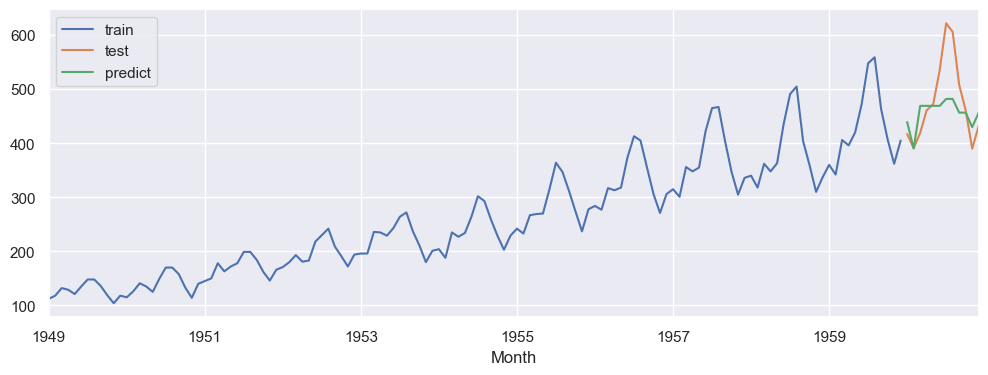

In [8]:
# 予測
y_pred = model.predict(X_test)
y_pred = pd.DataFrame(y_pred, index=y_test.index, columns=["#Passengers"])

fig, ax = plt.subplots(figsize=(12, 4))
y_train.plot(y="#Passengers", ax=ax, label="train")
y_test.plot(y="#Passengers", ax=ax, label="test")
y_pred.plot(y="#Passengers", ax=ax, label="predict")
ax.legend()
plt.show()

## 3. LightGBMを用いた一連の処理フロー

1. CV (クロスバリデーション)・HPO (ハイパーパラメータ最適化)
1. 学習
1. 予測

### 3.1. CV・HPO

In [9]:
# CV spliter.
cv = GroupTimeSeriesSplit(n_splits=5)

# CVを介したハイパーパラメータ探索インスタンス.
search = LightGBMOptunaStepwiseSearchCV(
    n_estimators=100,
    early_stopping_rounds=10,
    verbosity=-1,
    cv=cv,
)

# 最適化
search.fit(
    X=X_train,
    y=y_train,
    groups=X_train.index,
    show_progress_bar=True,
    optuna_verbosity=0,
    optuna_seed=1234,
)

feature_fraction, val_score: inf:   0%|                                                                                                                                                                                                                                                         | 0/7 [00:00<?, ?it/s]/Users/yuta.sonoda/opt/anaconda3/envs/analytics-sandbox/lib/python3.9/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 64.935659:  14%|#################################5                                                                                                                                                                                                         | 1/7 [00:00<00:00,  6

[1]	cv_agg's rmse: 120.21 + 40.8694
[2]	cv_agg's rmse: 115.543 + 37.4624
[3]	cv_agg's rmse: 111.749 + 34.7147
[4]	cv_agg's rmse: 107.849 + 32.1055
[5]	cv_agg's rmse: 104.783 + 30.1438
[6]	cv_agg's rmse: 102.054 + 28.686
[7]	cv_agg's rmse: 99.3883 + 27.3203
[8]	cv_agg's rmse: 96.8926 + 25.9935
[9]	cv_agg's rmse: 94.744 + 24.8968
[10]	cv_agg's rmse: 92.5441 + 23.744
[11]	cv_agg's rmse: 90.9967 + 23.2153
[12]	cv_agg's rmse: 89.3543 + 22.5231
[13]	cv_agg's rmse: 88.0349 + 21.9525
[14]	cv_agg's rmse: 86.6667 + 21.4632
[15]	cv_agg's rmse: 85.3076 + 20.9182
[16]	cv_agg's rmse: 84.3016 + 20.6351
[17]	cv_agg's rmse: 83.2628 + 20.2018
[18]	cv_agg's rmse: 82.2639 + 19.8716
[19]	cv_agg's rmse: 81.4413 + 19.6908
[20]	cv_agg's rmse: 80.6169 + 19.499
[21]	cv_agg's rmse: 79.9866 + 19.4049
[22]	cv_agg's rmse: 79.4955 + 19.2803
[23]	cv_agg's rmse: 78.8262 + 19.1885
[24]	cv_agg's rmse: 78.4815 + 19.1837
[25]	cv_agg's rmse: 77.9398 + 19.1649
[26]	cv_agg's rmse: 77.3913 + 19.0956
[27]	cv_agg's rmse: 76.857

feature_fraction, val_score: 64.935659:  29%|###################################################################1                                                                                                                                                                       | 2/7 [00:00<00:00,  5.35it/s]

[30]	cv_agg's rmse: 76.0304 + 18.8514
[31]	cv_agg's rmse: 75.5354 + 18.8684
[32]	cv_agg's rmse: 75.0683 + 18.8608
[33]	cv_agg's rmse: 74.5911 + 18.8684
[34]	cv_agg's rmse: 74.1103 + 18.8938
[35]	cv_agg's rmse: 73.714 + 18.9303
[36]	cv_agg's rmse: 73.2833 + 18.9596
[37]	cv_agg's rmse: 72.9616 + 18.9816
[38]	cv_agg's rmse: 72.6825 + 19.0119
[39]	cv_agg's rmse: 72.3574 + 19.0571
[40]	cv_agg's rmse: 71.9663 + 19.0949
[41]	cv_agg's rmse: 71.6009 + 19.1086
[42]	cv_agg's rmse: 71.435 + 19.168
[43]	cv_agg's rmse: 71.1298 + 19.1548
[44]	cv_agg's rmse: 70.8792 + 19.1604
[45]	cv_agg's rmse: 70.6368 + 19.183
[46]	cv_agg's rmse: 70.6329 + 19.2142
[47]	cv_agg's rmse: 70.4621 + 19.1982
[48]	cv_agg's rmse: 70.1902 + 19.2496
[49]	cv_agg's rmse: 69.9378 + 19.2873
[50]	cv_agg's rmse: 69.6967 + 19.3116
[51]	cv_agg's rmse: 69.519 + 19.2972
[52]	cv_agg's rmse: 69.4782 + 19.3123
[53]	cv_agg's rmse: 69.3662 + 19.3148
[54]	cv_agg's rmse: 69.3958 + 19.3686
[55]	cv_agg's rmse: 69.188 + 19.4058
[56]	cv_agg's rmse

/Users/yuta.sonoda/opt/anaconda3/envs/analytics-sandbox/lib/python3.9/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 64.935659:  43%|####################################################################################################7                                                                                                                                      | 3/7 [00:00<00:00,  5.45it/s]/Users/yuta.sonoda/opt/anaconda3/envs/analytics-sandbox/lib/python3.9/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbos

[25]	cv_agg's rmse: 78.5401 + 19.201
[26]	cv_agg's rmse: 78.1645 + 19.1348
[27]	cv_agg's rmse: 77.4624 + 19.0752
[28]	cv_agg's rmse: 76.8868 + 19.0501
[29]	cv_agg's rmse: 76.6767 + 19.1321
[30]	cv_agg's rmse: 76.1047 + 19.1338
[31]	cv_agg's rmse: 75.5793 + 19.0956
[32]	cv_agg's rmse: 75.2268 + 19.1248
[33]	cv_agg's rmse: 75.2222 + 19.1833
[34]	cv_agg's rmse: 74.7673 + 19.2174
[35]	cv_agg's rmse: 74.6735 + 19.1746
[36]	cv_agg's rmse: 74.345 + 19.1909
[37]	cv_agg's rmse: 74.0815 + 19.1931
[38]	cv_agg's rmse: 73.8902 + 19.1135
[39]	cv_agg's rmse: 73.4588 + 19.1213
[40]	cv_agg's rmse: 73.1376 + 19.1341
[41]	cv_agg's rmse: 72.739 + 19.1645
[42]	cv_agg's rmse: 72.4012 + 19.1931
[43]	cv_agg's rmse: 72.0798 + 19.2153
[44]	cv_agg's rmse: 71.7132 + 19.2272
[45]	cv_agg's rmse: 71.3454 + 19.1918
[46]	cv_agg's rmse: 71.0273 + 19.215
[47]	cv_agg's rmse: 71.0713 + 19.2355
[48]	cv_agg's rmse: 70.786 + 19.2907
[49]	cv_agg's rmse: 70.5448 + 19.322
[50]	cv_agg's rmse: 70.2933 + 19.3623
[51]	cv_agg's rmse

feature_fraction, val_score: 64.935659:  57%|######################################################################################################################################2                                                                                                    | 4/7 [00:00<00:00,  5.34it/s]/Users/yuta.sonoda/opt/anaconda3/envs/analytics-sandbox/lib/python3.9/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[42]	cv_agg's rmse: 71.435 + 19.168
[43]	cv_agg's rmse: 71.1298 + 19.1548
[44]	cv_agg's rmse: 70.8792 + 19.1604
[45]	cv_agg's rmse: 70.6368 + 19.183
[46]	cv_agg's rmse: 70.6329 + 19.2142
[47]	cv_agg's rmse: 70.4621 + 19.1982
[48]	cv_agg's rmse: 70.1902 + 19.2496
[49]	cv_agg's rmse: 69.9378 + 19.2873
[50]	cv_agg's rmse: 69.6967 + 19.3116
[51]	cv_agg's rmse: 69.519 + 19.2972
[52]	cv_agg's rmse: 69.4782 + 19.3123
[53]	cv_agg's rmse: 69.3662 + 19.3148
[54]	cv_agg's rmse: 69.3958 + 19.3686
[55]	cv_agg's rmse: 69.188 + 19.4058
[56]	cv_agg's rmse: 69.0558 + 19.399
[57]	cv_agg's rmse: 68.9133 + 19.3612
[58]	cv_agg's rmse: 68.6745 + 19.3955
[59]	cv_agg's rmse: 68.7223 + 19.3866
[60]	cv_agg's rmse: 68.5214 + 19.4322
[61]	cv_agg's rmse: 68.3521 + 19.4612
[62]	cv_agg's rmse: 68.1411 + 19.4837
[63]	cv_agg's rmse: 67.9726 + 19.5378
[64]	cv_agg's rmse: 67.848 + 19.5802
[65]	cv_agg's rmse: 67.8968 + 19.5748
[66]	cv_agg's rmse: 67.7436 + 19.6016
[67]	cv_agg's rmse: 67.5524 + 19.6281
[68]	cv_agg's rmse:

feature_fraction, val_score: 64.685298:  71%|#######################################################################################################################################################################8                                                                   | 5/7 [00:00<00:00,  5.14it/s]

[40]	cv_agg's rmse: 72.722 + 19.0269
[41]	cv_agg's rmse: 72.5716 + 19.1157
[42]	cv_agg's rmse: 72.229 + 19.1282
[43]	cv_agg's rmse: 72.2279 + 19.1874
[44]	cv_agg's rmse: 71.9392 + 19.2052
[45]	cv_agg's rmse: 71.6901 + 19.2498
[46]	cv_agg's rmse: 71.5476 + 19.2321
[47]	cv_agg's rmse: 71.2515 + 19.2587
[48]	cv_agg's rmse: 71.242 + 19.3076
[49]	cv_agg's rmse: 71.0503 + 19.2774
[50]	cv_agg's rmse: 70.9109 + 19.363
[51]	cv_agg's rmse: 70.6483 + 19.3972
[52]	cv_agg's rmse: 70.5078 + 19.3953
[53]	cv_agg's rmse: 70.2473 + 19.426
[54]	cv_agg's rmse: 69.9775 + 19.3778
[55]	cv_agg's rmse: 69.792 + 19.4224
[56]	cv_agg's rmse: 69.5597 + 19.4457
[57]	cv_agg's rmse: 69.3911 + 19.4764
[58]	cv_agg's rmse: 69.2943 + 19.4799
[59]	cv_agg's rmse: 69.1768 + 19.5566
[60]	cv_agg's rmse: 68.9632 + 19.588
[61]	cv_agg's rmse: 68.9774 + 19.6445
[62]	cv_agg's rmse: 68.7656 + 19.6702
[63]	cv_agg's rmse: 68.5034 + 19.6994
[64]	cv_agg's rmse: 68.4008 + 19.7048
[65]	cv_agg's rmse: 68.1323 + 19.7216
[66]	cv_agg's rmse:

/Users/yuta.sonoda/opt/anaconda3/envs/analytics-sandbox/lib/python3.9/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 64.685298:  86%|#########################################################################################################################################################################################################4                                 | 6/7 [00:01<00:00,  5.22it/s]/Users/yuta.sonoda/opt/anaconda3/envs/analytics-sandbox/lib/python3.9/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbos

[48]	cv_agg's rmse: 70.7678 + 19.1233
[49]	cv_agg's rmse: 70.4496 + 19.1561
[50]	cv_agg's rmse: 70.3543 + 19.1505
[51]	cv_agg's rmse: 70.1853 + 19.1911
[52]	cv_agg's rmse: 69.9624 + 19.2228
[53]	cv_agg's rmse: 69.7509 + 19.2745
[54]	cv_agg's rmse: 69.6483 + 19.2796
[55]	cv_agg's rmse: 69.4084 + 19.3054
[56]	cv_agg's rmse: 69.1815 + 19.3522
[57]	cv_agg's rmse: 68.9065 + 19.3477
[58]	cv_agg's rmse: 68.791 + 19.353
[59]	cv_agg's rmse: 68.5912 + 19.3829
[60]	cv_agg's rmse: 68.3908 + 19.4312
[61]	cv_agg's rmse: 68.2757 + 19.4342
[62]	cv_agg's rmse: 68.076 + 19.4783
[63]	cv_agg's rmse: 67.9026 + 19.5205
[64]	cv_agg's rmse: 67.8057 + 19.5859
[65]	cv_agg's rmse: 67.7995 + 19.6261
[66]	cv_agg's rmse: 67.6744 + 19.6606
[67]	cv_agg's rmse: 67.5846 + 19.7201
[68]	cv_agg's rmse: 67.4118 + 19.7596
[69]	cv_agg's rmse: 67.2566 + 19.8011
[70]	cv_agg's rmse: 67.1426 + 19.8108
[71]	cv_agg's rmse: 67.1462 + 19.8496
[72]	cv_agg's rmse: 66.9499 + 19.8665
[73]	cv_agg's rmse: 66.7345 + 19.8918
[74]	cv_agg's r

feature_fraction, val_score: 64.685298: 100%|###########################################################################################################################################################################################################################################| 7/7 [00:01<00:00,  5.21it/s]


[46]	cv_agg's rmse: 71.7094 + 19.3422
[47]	cv_agg's rmse: 71.5687 + 19.4284
[48]	cv_agg's rmse: 71.2923 + 19.4102
[49]	cv_agg's rmse: 71.089 + 19.3788
[50]	cv_agg's rmse: 71.0807 + 19.4342
[51]	cv_agg's rmse: 70.819 + 19.445
[52]	cv_agg's rmse: 70.567 + 19.4393
[53]	cv_agg's rmse: 70.3072 + 19.4672
[54]	cv_agg's rmse: 70.3247 + 19.5181
[55]	cv_agg's rmse: 70.2036 + 19.5998
[56]	cv_agg's rmse: 69.9834 + 19.6283
[57]	cv_agg's rmse: 69.7722 + 19.6857
[58]	cv_agg's rmse: 69.5647 + 19.6495
[59]	cv_agg's rmse: 69.3154 + 19.6597
[60]	cv_agg's rmse: 69.1873 + 19.6675
[61]	cv_agg's rmse: 68.9982 + 19.707
[62]	cv_agg's rmse: 68.8317 + 19.7341
[63]	cv_agg's rmse: 68.6353 + 19.7635
[64]	cv_agg's rmse: 68.4683 + 19.7836
[65]	cv_agg's rmse: 68.3032 + 19.7689
[66]	cv_agg's rmse: 68.108 + 19.8082
[67]	cv_agg's rmse: 67.8615 + 19.8235
[68]	cv_agg's rmse: 67.7736 + 19.8981
[69]	cv_agg's rmse: 67.6821 + 19.9023
[70]	cv_agg's rmse: 67.49 + 19.928
[71]	cv_agg's rmse: 67.2407 + 19.9261
[72]	cv_agg's rmse: 6

num_leaves, val_score: 64.685298:   0%|                                                                                                                                                                                                                                                        | 0/20 [00:00<?, ?it/s]

[1]	cv_agg's rmse: 120.21 + 40.8694
[2]	cv_agg's rmse: 115.543 + 37.4624
[3]	cv_agg's rmse: 111.58 + 34.5083
[4]	cv_agg's rmse: 108.391 + 32.7099
[5]	cv_agg's rmse: 105 + 30.6478
[6]	cv_agg's rmse: 102.287 + 28.9824
[7]	cv_agg's rmse: 99.6167 + 27.5025
[8]	cv_agg's rmse: 97.2552 + 26.331
[9]	cv_agg's rmse: 95.2292 + 25.4176
[10]	cv_agg's rmse: 93.1792 + 24.447
[11]	cv_agg's rmse: 91.4985 + 23.7316
[12]	cv_agg's rmse: 89.7541 + 22.946
[13]	cv_agg's rmse: 88.196 + 22.1166
[14]	cv_agg's rmse: 86.8637 + 21.6272
[15]	cv_agg's rmse: 85.5063 + 21.0464
[16]	cv_agg's rmse: 84.2836 + 20.5923
[17]	cv_agg's rmse: 83.2025 + 20.2236
[18]	cv_agg's rmse: 82.4206 + 20.0073
[19]	cv_agg's rmse: 81.5283 + 19.737
[20]	cv_agg's rmse: 80.6889 + 19.54
[21]	cv_agg's rmse: 80.0216 + 19.424
[22]	cv_agg's rmse: 79.5052 + 19.3238
[23]	cv_agg's rmse: 78.9653 + 19.1753
[24]	cv_agg's rmse: 78.3751 + 19.0976
[25]	cv_agg's rmse: 77.9256 + 19.1383
[26]	cv_agg's rmse: 77.3824 + 19.0674
[27]	cv_agg's rmse: 76.9343 + 19.00

/Users/yuta.sonoda/opt/anaconda3/envs/analytics-sandbox/lib/python3.9/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 64.685298:   5%|############                                                                                                                                                                                                                                    | 1/20 [00:00<00:03,  5.06it/s]/Users/yuta.sonoda/opt/anaconda3/envs/analytics-sandbox/lib/python3.9/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbos

[44]	cv_agg's rmse: 71.9392 + 19.2052
[45]	cv_agg's rmse: 71.6901 + 19.2498
[46]	cv_agg's rmse: 71.5476 + 19.2321
[47]	cv_agg's rmse: 71.2515 + 19.2587
[48]	cv_agg's rmse: 71.242 + 19.3076
[49]	cv_agg's rmse: 71.0503 + 19.2774
[50]	cv_agg's rmse: 70.9109 + 19.363
[51]	cv_agg's rmse: 70.6483 + 19.3972
[52]	cv_agg's rmse: 70.5078 + 19.3953
[53]	cv_agg's rmse: 70.2473 + 19.426
[54]	cv_agg's rmse: 69.9775 + 19.3778
[55]	cv_agg's rmse: 69.792 + 19.4224
[56]	cv_agg's rmse: 69.5597 + 19.4457
[57]	cv_agg's rmse: 69.3911 + 19.4764
[58]	cv_agg's rmse: 69.2943 + 19.4799
[59]	cv_agg's rmse: 69.1768 + 19.5566
[60]	cv_agg's rmse: 68.9632 + 19.588
[61]	cv_agg's rmse: 68.9774 + 19.6445
[62]	cv_agg's rmse: 68.7656 + 19.6702
[63]	cv_agg's rmse: 68.5034 + 19.6994
[64]	cv_agg's rmse: 68.4008 + 19.7048
[65]	cv_agg's rmse: 68.1323 + 19.7216
[66]	cv_agg's rmse: 67.9706 + 19.7553
[67]	cv_agg's rmse: 67.7825 + 19.763
[68]	cv_agg's rmse: 67.7147 + 19.7973
[69]	cv_agg's rmse: 67.4574 + 19.8038
[70]	cv_agg's rmse

num_leaves, val_score: 64.685298:   5%|############                                                                                                                                                                                                                                    | 1/20 [00:00<00:03,  5.06it/s]

[40]	cv_agg's rmse: 72.722 + 19.0269
[41]	cv_agg's rmse: 72.5716 + 19.1157
[42]	cv_agg's rmse: 72.229 + 19.1282
[43]	cv_agg's rmse: 72.2279 + 19.1874
[44]	cv_agg's rmse: 71.9392 + 19.2052
[45]	cv_agg's rmse: 71.6901 + 19.2498
[46]	cv_agg's rmse: 71.5476 + 19.2321
[47]	cv_agg's rmse: 71.2515 + 19.2587
[48]	cv_agg's rmse: 71.242 + 19.3076
[49]	cv_agg's rmse: 71.0503 + 19.2774
[50]	cv_agg's rmse: 70.9109 + 19.363
[51]	cv_agg's rmse: 70.6483 + 19.3972
[52]	cv_agg's rmse: 70.5078 + 19.3953
[53]	cv_agg's rmse: 70.2473 + 19.426
[54]	cv_agg's rmse: 69.9775 + 19.3778
[55]	cv_agg's rmse: 69.792 + 19.4224
[56]	cv_agg's rmse: 69.5597 + 19.4457
[57]	cv_agg's rmse: 69.3911 + 19.4764
[58]	cv_agg's rmse: 69.2943 + 19.4799
[59]	cv_agg's rmse: 69.1768 + 19.5566
[60]	cv_agg's rmse: 68.9632 + 19.588
[61]	cv_agg's rmse: 68.9774 + 19.6445
[62]	cv_agg's rmse: 68.7656 + 19.6702
[63]	cv_agg's rmse: 68.5034 + 19.6994
[64]	cv_agg's rmse: 68.4008 + 19.7048
[65]	cv_agg's rmse: 68.1323 + 19.7216
[66]	cv_agg's rmse:

num_leaves, val_score: 64.685298:  10%|########################                                                                                                                                                                                                                        | 2/20 [00:00<00:03,  4.79it/s]

[1]	cv_agg's rmse: 120.21 + 40.8694
[2]	cv_agg's rmse: 115.543 + 37.4624
[3]	cv_agg's rmse: 111.58 + 34.5083
[4]	cv_agg's rmse: 108.391 + 32.7099
[5]	cv_agg's rmse: 105 + 30.6478
[6]	cv_agg's rmse: 102.287 + 28.9824
[7]	cv_agg's rmse: 99.6167 + 27.5025
[8]	cv_agg's rmse: 97.2552 + 26.331
[9]	cv_agg's rmse: 95.2292 + 25.4176
[10]	cv_agg's rmse: 93.1792 + 24.447
[11]	cv_agg's rmse: 91.4985 + 23.7316
[12]	cv_agg's rmse: 89.7541 + 22.946
[13]	cv_agg's rmse: 88.196 + 22.1166
[14]	cv_agg's rmse: 86.8637 + 21.6272
[15]	cv_agg's rmse: 85.5063 + 21.0464
[16]	cv_agg's rmse: 84.2836 + 20.5923
[17]	cv_agg's rmse: 83.2025 + 20.2236
[18]	cv_agg's rmse: 82.4206 + 20.0073
[19]	cv_agg's rmse: 81.5283 + 19.737
[20]	cv_agg's rmse: 80.6889 + 19.54
[21]	cv_agg's rmse: 80.0216 + 19.424
[22]	cv_agg's rmse: 79.5052 + 19.3238
[23]	cv_agg's rmse: 78.9653 + 19.1753
[24]	cv_agg's rmse: 78.3751 + 19.0976
[25]	cv_agg's rmse: 77.9256 + 19.1383
[26]	cv_agg's rmse: 77.3824 + 19.0674
[27]	cv_agg's rmse: 76.9343 + 19.00

/Users/yuta.sonoda/opt/anaconda3/envs/analytics-sandbox/lib/python3.9/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[37]	cv_agg's rmse: 73.2728 + 18.9496
[38]	cv_agg's rmse: 73.1175 + 19.0395
[39]	cv_agg's rmse: 72.9615 + 19.0192
[40]	cv_agg's rmse: 72.722 + 19.0269
[41]	cv_agg's rmse: 72.5716 + 19.1157
[42]	cv_agg's rmse: 72.229 + 19.1282
[43]	cv_agg's rmse: 72.2279 + 19.1874
[44]	cv_agg's rmse: 71.9392 + 19.2052
[45]	cv_agg's rmse: 71.6901 + 19.2498
[46]	cv_agg's rmse: 71.5476 + 19.2321
[47]	cv_agg's rmse: 71.2515 + 19.2587
[48]	cv_agg's rmse: 71.242 + 19.3076
[49]	cv_agg's rmse: 71.0503 + 19.2774
[50]	cv_agg's rmse: 70.9109 + 19.363
[51]	cv_agg's rmse: 70.6483 + 19.3972
[52]	cv_agg's rmse: 70.5078 + 19.3953
[53]	cv_agg's rmse: 70.2473 + 19.426
[54]	cv_agg's rmse: 69.9775 + 19.3778
[55]	cv_agg's rmse: 69.792 + 19.4224
[56]	cv_agg's rmse: 69.5597 + 19.4457
[57]	cv_agg's rmse: 69.3911 + 19.4764
[58]	cv_agg's rmse: 69.2943 + 19.4799
[59]	cv_agg's rmse: 69.1768 + 19.5566
[60]	cv_agg's rmse: 68.9632 + 19.588
[61]	cv_agg's rmse: 68.9774 + 19.6445
[62]	cv_agg's rmse: 68.7656 + 19.6702
[63]	cv_agg's rmse:

num_leaves, val_score: 64.685298:  15%|####################################                                                                                                                                                                                                            | 3/20 [00:00<00:03,  4.50it/s]

[91]	cv_agg's rmse: 65.3502 + 20.4627
[92]	cv_agg's rmse: 65.3091 + 20.4788
[93]	cv_agg's rmse: 65.1891 + 20.5319
[94]	cv_agg's rmse: 65.1204 + 20.5514
[95]	cv_agg's rmse: 64.9784 + 20.5631
[96]	cv_agg's rmse: 65.0188 + 20.5698
[97]	cv_agg's rmse: 64.8392 + 20.5865
[98]	cv_agg's rmse: 64.735 + 20.5951
[99]	cv_agg's rmse: 64.7486 + 20.6249
[100]	cv_agg's rmse: 64.6853 + 20.6762
[1]	cv_agg's rmse: 120.21 + 40.8694
[2]	cv_agg's rmse: 115.543 + 37.4624
[3]	cv_agg's rmse: 111.58 + 34.5083
[4]	cv_agg's rmse: 108.391 + 32.7099
[5]	cv_agg's rmse: 105 + 30.6478
[6]	cv_agg's rmse: 102.287 + 28.9824
[7]	cv_agg's rmse: 99.6167 + 27.5025
[8]	cv_agg's rmse: 97.2552 + 26.331
[9]	cv_agg's rmse: 95.2292 + 25.4176
[10]	cv_agg's rmse: 93.1792 + 24.447
[11]	cv_agg's rmse: 91.4985 + 23.7316
[12]	cv_agg's rmse: 89.7541 + 22.946
[13]	cv_agg's rmse: 88.196 + 22.1166
[14]	cv_agg's rmse: 86.8637 + 21.6272
[15]	cv_agg's rmse: 85.5063 + 21.0464
[16]	cv_agg's rmse: 84.2836 + 20.5923
[17]	cv_agg's rmse: 83.2025 + 2

/Users/yuta.sonoda/opt/anaconda3/envs/analytics-sandbox/lib/python3.9/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[54]	cv_agg's rmse: 69.9775 + 19.3778
[55]	cv_agg's rmse: 69.792 + 19.4224
[56]	cv_agg's rmse: 69.5597 + 19.4457
[57]	cv_agg's rmse: 69.3911 + 19.4764
[58]	cv_agg's rmse: 69.2943 + 19.4799
[59]	cv_agg's rmse: 69.1768 + 19.5566
[60]	cv_agg's rmse: 68.9632 + 19.588
[61]	cv_agg's rmse: 68.9774 + 19.6445
[62]	cv_agg's rmse: 68.7656 + 19.6702
[63]	cv_agg's rmse: 68.5034 + 19.6994
[64]	cv_agg's rmse: 68.4008 + 19.7048
[65]	cv_agg's rmse: 68.1323 + 19.7216
[66]	cv_agg's rmse: 67.9706 + 19.7553
[67]	cv_agg's rmse: 67.7825 + 19.763
[68]	cv_agg's rmse: 67.7147 + 19.7973
[69]	cv_agg's rmse: 67.4574 + 19.8038
[70]	cv_agg's rmse: 67.3318 + 19.8443
[71]	cv_agg's rmse: 67.1607 + 19.8713
[72]	cv_agg's rmse: 67.0897 + 19.891
[73]	cv_agg's rmse: 67.0361 + 19.9515


num_leaves, val_score: 64.685298:  20%|################################################                                                                                                                                                                                                | 4/20 [00:00<00:04,  3.75it/s]

[74]	cv_agg's rmse: 66.8711 + 19.9861
[75]	cv_agg's rmse: 66.8056 + 20.0041
[76]	cv_agg's rmse: 66.6929 + 19.9951
[77]	cv_agg's rmse: 66.6263 + 20.074
[78]	cv_agg's rmse: 66.4987 + 20.0731
[79]	cv_agg's rmse: 66.3105 + 20.1018
[80]	cv_agg's rmse: 66.3149 + 20.144
[81]	cv_agg's rmse: 66.2239 + 20.1651
[82]	cv_agg's rmse: 66.0868 + 20.1954
[83]	cv_agg's rmse: 65.9666 + 20.198
[84]	cv_agg's rmse: 65.8797 + 20.225
[85]	cv_agg's rmse: 65.843 + 20.2745
[86]	cv_agg's rmse: 65.6912 + 20.3136
[87]	cv_agg's rmse: 65.6592 + 20.3479
[88]	cv_agg's rmse: 65.5423 + 20.3581
[89]	cv_agg's rmse: 65.4943 + 20.4038
[90]	cv_agg's rmse: 65.4028 + 20.4169
[91]	cv_agg's rmse: 65.3502 + 20.4627
[92]	cv_agg's rmse: 65.3091 + 20.4788
[93]	cv_agg's rmse: 65.1891 + 20.5319
[94]	cv_agg's rmse: 65.1204 + 20.5514
[95]	cv_agg's rmse: 64.9784 + 20.5631
[96]	cv_agg's rmse: 65.0188 + 20.5698
[97]	cv_agg's rmse: 64.8392 + 20.5865
[98]	cv_agg's rmse: 64.735 + 20.5951
[99]	cv_agg's rmse: 64.7486 + 20.6249
[100]	cv_agg's rms

/Users/yuta.sonoda/opt/anaconda3/envs/analytics-sandbox/lib/python3.9/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[26]	cv_agg's rmse: 77.3824 + 19.0674
[27]	cv_agg's rmse: 76.9343 + 19.0056
[28]	cv_agg's rmse: 76.5074 + 19.0085
[29]	cv_agg's rmse: 75.9298 + 18.9532
[30]	cv_agg's rmse: 75.8246 + 19.047
[31]	cv_agg's rmse: 75.3284 + 18.9837
[32]	cv_agg's rmse: 74.9492 + 19.0228
[33]	cv_agg's rmse: 74.6164 + 18.9843
[34]	cv_agg's rmse: 74.4132 + 18.9587
[35]	cv_agg's rmse: 74.0802 + 18.978
[36]	cv_agg's rmse: 73.6291 + 18.9518
[37]	cv_agg's rmse: 73.2728 + 18.9496
[38]	cv_agg's rmse: 73.1175 + 19.0395
[39]	cv_agg's rmse: 72.9615 + 19.0192
[40]	cv_agg's rmse: 72.722 + 19.0269
[41]	cv_agg's rmse: 72.5716 + 19.1157
[42]	cv_agg's rmse: 72.229 + 19.1282
[43]	cv_agg's rmse: 72.2279 + 19.1874
[44]	cv_agg's rmse: 71.9392 + 19.2052
[45]	cv_agg's rmse: 71.6901 + 19.2498
[46]	cv_agg's rmse: 71.5476 + 19.2321
[47]	cv_agg's rmse: 71.2515 + 19.2587
[48]	cv_agg's rmse: 71.242 + 19.3076
[49]	cv_agg's rmse: 71.0503 + 19.2774
[50]	cv_agg's rmse: 70.9109 + 19.363
[51]	cv_agg's rmse: 70.6483 + 19.3972
[52]	cv_agg's rmse

num_leaves, val_score: 64.685298:  25%|############################################################                                                                                                                                                                                    | 5/20 [00:01<00:04,  3.15it/s]

[79]	cv_agg's rmse: 66.3105 + 20.1018
[80]	cv_agg's rmse: 66.3149 + 20.144
[81]	cv_agg's rmse: 66.2239 + 20.1651
[82]	cv_agg's rmse: 66.0868 + 20.1954
[83]	cv_agg's rmse: 65.9666 + 20.198
[84]	cv_agg's rmse: 65.8797 + 20.225
[85]	cv_agg's rmse: 65.843 + 20.2745
[86]	cv_agg's rmse: 65.6912 + 20.3136
[87]	cv_agg's rmse: 65.6592 + 20.3479
[88]	cv_agg's rmse: 65.5423 + 20.3581
[89]	cv_agg's rmse: 65.4943 + 20.4038
[90]	cv_agg's rmse: 65.4028 + 20.4169
[91]	cv_agg's rmse: 65.3502 + 20.4627
[92]	cv_agg's rmse: 65.3091 + 20.4788
[93]	cv_agg's rmse: 65.1891 + 20.5319
[94]	cv_agg's rmse: 65.1204 + 20.5514
[95]	cv_agg's rmse: 64.9784 + 20.5631
[96]	cv_agg's rmse: 65.0188 + 20.5698
[97]	cv_agg's rmse: 64.8392 + 20.5865
[98]	cv_agg's rmse: 64.735 + 20.5951
[99]	cv_agg's rmse: 64.7486 + 20.6249
[100]	cv_agg's rmse: 64.6853 + 20.6762
[1]	cv_agg's rmse: 120.21 + 40.8694
[2]	cv_agg's rmse: 115.543 + 37.4624
[3]	cv_agg's rmse: 111.58 + 34.5083
[4]	cv_agg's rmse: 108.391 + 32.7099
[5]	cv_agg's rmse: 105

/Users/yuta.sonoda/opt/anaconda3/envs/analytics-sandbox/lib/python3.9/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[27]	cv_agg's rmse: 76.9343 + 19.0056
[28]	cv_agg's rmse: 76.5074 + 19.0085
[29]	cv_agg's rmse: 75.9298 + 18.9532
[30]	cv_agg's rmse: 75.8246 + 19.047
[31]	cv_agg's rmse: 75.3284 + 18.9837
[32]	cv_agg's rmse: 74.9492 + 19.0228
[33]	cv_agg's rmse: 74.6164 + 18.9843
[34]	cv_agg's rmse: 74.4132 + 18.9587
[35]	cv_agg's rmse: 74.0802 + 18.978
[36]	cv_agg's rmse: 73.6291 + 18.9518
[37]	cv_agg's rmse: 73.2728 + 18.9496
[38]	cv_agg's rmse: 73.1175 + 19.0395
[39]	cv_agg's rmse: 72.9615 + 19.0192
[40]	cv_agg's rmse: 72.722 + 19.0269
[41]	cv_agg's rmse: 72.5716 + 19.1157
[42]	cv_agg's rmse: 72.229 + 19.1282
[43]	cv_agg's rmse: 72.2279 + 19.1874
[44]	cv_agg's rmse: 71.9392 + 19.2052
[45]	cv_agg's rmse: 71.6901 + 19.2498
[46]	cv_agg's rmse: 71.5476 + 19.2321
[47]	cv_agg's rmse: 71.2515 + 19.2587
[48]	cv_agg's rmse: 71.242 + 19.3076
[49]	cv_agg's rmse: 71.0503 + 19.2774
[50]	cv_agg's rmse: 70.9109 + 19.363
[51]	cv_agg's rmse: 70.6483 + 19.3972
[52]	cv_agg's rmse: 70.5078 + 19.3953
[53]	cv_agg's rmse

num_leaves, val_score: 64.685298:  30%|########################################################################                                                                                                                                                                        | 6/20 [00:01<00:04,  2.98it/s]

[81]	cv_agg's rmse: 66.2239 + 20.1651
[82]	cv_agg's rmse: 66.0868 + 20.1954
[83]	cv_agg's rmse: 65.9666 + 20.198
[84]	cv_agg's rmse: 65.8797 + 20.225
[85]	cv_agg's rmse: 65.843 + 20.2745
[86]	cv_agg's rmse: 65.6912 + 20.3136
[87]	cv_agg's rmse: 65.6592 + 20.3479
[88]	cv_agg's rmse: 65.5423 + 20.3581
[89]	cv_agg's rmse: 65.4943 + 20.4038
[90]	cv_agg's rmse: 65.4028 + 20.4169
[91]	cv_agg's rmse: 65.3502 + 20.4627
[92]	cv_agg's rmse: 65.3091 + 20.4788
[93]	cv_agg's rmse: 65.1891 + 20.5319
[94]	cv_agg's rmse: 65.1204 + 20.5514
[95]	cv_agg's rmse: 64.9784 + 20.5631
[96]	cv_agg's rmse: 65.0188 + 20.5698
[97]	cv_agg's rmse: 64.8392 + 20.5865
[98]	cv_agg's rmse: 64.735 + 20.5951
[99]	cv_agg's rmse: 64.7486 + 20.6249
[100]	cv_agg's rmse: 64.6853 + 20.6762
[1]	cv_agg's rmse: 120.21 + 40.8694
[2]	cv_agg's rmse: 115.543 + 37.4624
[3]	cv_agg's rmse: 111.58 + 34.5083
[4]	cv_agg's rmse: 108.391 + 32.7099
[5]	cv_agg's rmse: 105 + 30.6478
[6]	cv_agg's rmse: 102.287 + 28.9824
[7]	cv_agg's rmse: 99.6167 

/Users/yuta.sonoda/opt/anaconda3/envs/analytics-sandbox/lib/python3.9/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[39]	cv_agg's rmse: 72.9615 + 19.0192
[40]	cv_agg's rmse: 72.722 + 19.0269
[41]	cv_agg's rmse: 72.5716 + 19.1157
[42]	cv_agg's rmse: 72.229 + 19.1282
[43]	cv_agg's rmse: 72.2279 + 19.1874
[44]	cv_agg's rmse: 71.9392 + 19.2052
[45]	cv_agg's rmse: 71.6901 + 19.2498
[46]	cv_agg's rmse: 71.5476 + 19.2321
[47]	cv_agg's rmse: 71.2515 + 19.2587
[48]	cv_agg's rmse: 71.242 + 19.3076
[49]	cv_agg's rmse: 71.0503 + 19.2774
[50]	cv_agg's rmse: 70.9109 + 19.363
[51]	cv_agg's rmse: 70.6483 + 19.3972
[52]	cv_agg's rmse: 70.5078 + 19.3953
[53]	cv_agg's rmse: 70.2473 + 19.426
[54]	cv_agg's rmse: 69.9775 + 19.3778
[55]	cv_agg's rmse: 69.792 + 19.4224
[56]	cv_agg's rmse: 69.5597 + 19.4457
[57]	cv_agg's rmse: 69.3911 + 19.4764
[58]	cv_agg's rmse: 69.2943 + 19.4799
[59]	cv_agg's rmse: 69.1768 + 19.5566
[60]	cv_agg's rmse: 68.9632 + 19.588
[61]	cv_agg's rmse: 68.9774 + 19.6445
[62]	cv_agg's rmse: 68.7656 + 19.6702
[63]	cv_agg's rmse: 68.5034 + 19.6994
[64]	cv_agg's rmse: 68.4008 + 19.7048
[65]	cv_agg's rmse:

num_leaves, val_score: 64.685298:  35%|####################################################################################                                                                                                                                                            | 7/20 [00:02<00:04,  2.87it/s]

[96]	cv_agg's rmse: 65.0188 + 20.5698
[97]	cv_agg's rmse: 64.8392 + 20.5865
[98]	cv_agg's rmse: 64.735 + 20.5951
[99]	cv_agg's rmse: 64.7486 + 20.6249
[100]	cv_agg's rmse: 64.6853 + 20.6762
[1]	cv_agg's rmse: 120.21 + 40.8694
[2]	cv_agg's rmse: 115.543 + 37.4624
[3]	cv_agg's rmse: 111.58 + 34.5083
[4]	cv_agg's rmse: 108.391 + 32.7099
[5]	cv_agg's rmse: 105 + 30.6478
[6]	cv_agg's rmse: 102.287 + 28.9824
[7]	cv_agg's rmse: 99.6167 + 27.5025
[8]	cv_agg's rmse: 97.2552 + 26.331
[9]	cv_agg's rmse: 95.2292 + 25.4176
[10]	cv_agg's rmse: 93.1792 + 24.447
[11]	cv_agg's rmse: 91.4985 + 23.7316
[12]	cv_agg's rmse: 89.7541 + 22.946
[13]	cv_agg's rmse: 88.196 + 22.1166
[14]	cv_agg's rmse: 86.8637 + 21.6272
[15]	cv_agg's rmse: 85.5063 + 21.0464
[16]	cv_agg's rmse: 84.2836 + 20.5923
[17]	cv_agg's rmse: 83.2025 + 20.2236
[18]	cv_agg's rmse: 82.4206 + 20.0073
[19]	cv_agg's rmse: 81.5283 + 19.737
[20]	cv_agg's rmse: 80.6889 + 19.54
[21]	cv_agg's rmse: 80.0216 + 19.424
[22]	cv_agg's rmse: 79.5052 + 19.32

/Users/yuta.sonoda/opt/anaconda3/envs/analytics-sandbox/lib/python3.9/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[47]	cv_agg's rmse: 71.2515 + 19.2587
[48]	cv_agg's rmse: 71.242 + 19.3076
[49]	cv_agg's rmse: 71.0503 + 19.2774
[50]	cv_agg's rmse: 70.9109 + 19.363
[51]	cv_agg's rmse: 70.6483 + 19.3972
[52]	cv_agg's rmse: 70.5078 + 19.3953
[53]	cv_agg's rmse: 70.2473 + 19.426
[54]	cv_agg's rmse: 69.9775 + 19.3778
[55]	cv_agg's rmse: 69.792 + 19.4224
[56]	cv_agg's rmse: 69.5597 + 19.4457
[57]	cv_agg's rmse: 69.3911 + 19.4764
[58]	cv_agg's rmse: 69.2943 + 19.4799
[59]	cv_agg's rmse: 69.1768 + 19.5566
[60]	cv_agg's rmse: 68.9632 + 19.588
[61]	cv_agg's rmse: 68.9774 + 19.6445
[62]	cv_agg's rmse: 68.7656 + 19.6702
[63]	cv_agg's rmse: 68.5034 + 19.6994
[64]	cv_agg's rmse: 68.4008 + 19.7048
[65]	cv_agg's rmse: 68.1323 + 19.7216
[66]	cv_agg's rmse: 67.9706 + 19.7553
[67]	cv_agg's rmse: 67.7825 + 19.763
[68]	cv_agg's rmse: 67.7147 + 19.7973
[69]	cv_agg's rmse: 67.4574 + 19.8038
[70]	cv_agg's rmse: 67.3318 + 19.8443
[71]	cv_agg's rmse: 67.1607 + 19.8713
[72]	cv_agg's rmse: 67.0897 + 19.891
[73]	cv_agg's rmse:

num_leaves, val_score: 64.685298:  40%|################################################################################################                                                                                                                                                | 8/20 [00:02<00:04,  2.76it/s]

[100]	cv_agg's rmse: 64.6853 + 20.6762
[1]	cv_agg's rmse: 120.21 + 40.8694
[2]	cv_agg's rmse: 115.543 + 37.4624
[3]	cv_agg's rmse: 111.58 + 34.5083
[4]	cv_agg's rmse: 108.391 + 32.7099
[5]	cv_agg's rmse: 105 + 30.6478
[6]	cv_agg's rmse: 102.287 + 28.9824
[7]	cv_agg's rmse: 99.6167 + 27.5025
[8]	cv_agg's rmse: 97.2552 + 26.331
[9]	cv_agg's rmse: 95.2292 + 25.4176
[10]	cv_agg's rmse: 93.1792 + 24.447
[11]	cv_agg's rmse: 91.4985 + 23.7316
[12]	cv_agg's rmse: 89.7541 + 22.946
[13]	cv_agg's rmse: 88.196 + 22.1166
[14]	cv_agg's rmse: 86.8637 + 21.6272
[15]	cv_agg's rmse: 85.5063 + 21.0464
[16]	cv_agg's rmse: 84.2836 + 20.5923
[17]	cv_agg's rmse: 83.2025 + 20.2236
[18]	cv_agg's rmse: 82.4206 + 20.0073
[19]	cv_agg's rmse: 81.5283 + 19.737
[20]	cv_agg's rmse: 80.6889 + 19.54
[21]	cv_agg's rmse: 80.0216 + 19.424
[22]	cv_agg's rmse: 79.5052 + 19.3238
[23]	cv_agg's rmse: 78.9653 + 19.1753
[24]	cv_agg's rmse: 78.3751 + 19.0976
[25]	cv_agg's rmse: 77.9256 + 19.1383
[26]	cv_agg's rmse: 77.3824 + 19.0

/Users/yuta.sonoda/opt/anaconda3/envs/analytics-sandbox/lib/python3.9/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[55]	cv_agg's rmse: 69.792 + 19.4224
[56]	cv_agg's rmse: 69.5597 + 19.4457
[57]	cv_agg's rmse: 69.3911 + 19.4764
[58]	cv_agg's rmse: 69.2943 + 19.4799
[59]	cv_agg's rmse: 69.1768 + 19.5566
[60]	cv_agg's rmse: 68.9632 + 19.588
[61]	cv_agg's rmse: 68.9774 + 19.6445
[62]	cv_agg's rmse: 68.7656 + 19.6702
[63]	cv_agg's rmse: 68.5034 + 19.6994
[64]	cv_agg's rmse: 68.4008 + 19.7048
[65]	cv_agg's rmse: 68.1323 + 19.7216
[66]	cv_agg's rmse: 67.9706 + 19.7553
[67]	cv_agg's rmse: 67.7825 + 19.763
[68]	cv_agg's rmse: 67.7147 + 19.7973
[69]	cv_agg's rmse: 67.4574 + 19.8038
[70]	cv_agg's rmse: 67.3318 + 19.8443
[71]	cv_agg's rmse: 67.1607 + 19.8713
[72]	cv_agg's rmse: 67.0897 + 19.891
[73]	cv_agg's rmse: 67.0361 + 19.9515
[74]	cv_agg's rmse: 66.8711 + 19.9861
[75]	cv_agg's rmse: 66.8056 + 20.0041
[76]	cv_agg's rmse: 66.6929 + 19.9951
[77]	cv_agg's rmse: 66.6263 + 20.074
[78]	cv_agg's rmse: 66.4987 + 20.0731
[79]	cv_agg's rmse: 66.3105 + 20.1018
[80]	cv_agg's rmse: 66.3149 + 20.144
[81]	cv_agg's rmse

num_leaves, val_score: 64.685298:  45%|############################################################################################################                                                                                                                                    | 9/20 [00:02<00:03,  2.82it/s]

[100]	cv_agg's rmse: 64.6853 + 20.6762
[1]	cv_agg's rmse: 120.21 + 40.8694
[2]	cv_agg's rmse: 115.543 + 37.4624
[3]	cv_agg's rmse: 111.58 + 34.5083
[4]	cv_agg's rmse: 108.391 + 32.7099
[5]	cv_agg's rmse: 105 + 30.6478
[6]	cv_agg's rmse: 102.287 + 28.9824
[7]	cv_agg's rmse: 99.6167 + 27.5025
[8]	cv_agg's rmse: 97.2552 + 26.331
[9]	cv_agg's rmse: 95.2292 + 25.4176
[10]	cv_agg's rmse: 93.1792 + 24.447
[11]	cv_agg's rmse: 91.4985 + 23.7316
[12]	cv_agg's rmse: 89.7541 + 22.946
[13]	cv_agg's rmse: 88.196 + 22.1166
[14]	cv_agg's rmse: 86.8637 + 21.6272
[15]	cv_agg's rmse: 85.5063 + 21.0464
[16]	cv_agg's rmse: 84.2836 + 20.5923
[17]	cv_agg's rmse: 83.2025 + 20.2236
[18]	cv_agg's rmse: 82.4206 + 20.0073
[19]	cv_agg's rmse: 81.5283 + 19.737
[20]	cv_agg's rmse: 80.6889 + 19.54
[21]	cv_agg's rmse: 80.0216 + 19.424
[22]	cv_agg's rmse: 79.5052 + 19.3238
[23]	cv_agg's rmse: 78.9653 + 19.1753
[24]	cv_agg's rmse: 78.3751 + 19.0976
[25]	cv_agg's rmse: 77.9256 + 19.1383
[26]	cv_agg's rmse: 77.3824 + 19.0

/Users/yuta.sonoda/opt/anaconda3/envs/analytics-sandbox/lib/python3.9/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[49]	cv_agg's rmse: 71.0503 + 19.2774
[50]	cv_agg's rmse: 70.9109 + 19.363
[51]	cv_agg's rmse: 70.6483 + 19.3972
[52]	cv_agg's rmse: 70.5078 + 19.3953
[53]	cv_agg's rmse: 70.2473 + 19.426
[54]	cv_agg's rmse: 69.9775 + 19.3778
[55]	cv_agg's rmse: 69.792 + 19.4224
[56]	cv_agg's rmse: 69.5597 + 19.4457
[57]	cv_agg's rmse: 69.3911 + 19.4764
[58]	cv_agg's rmse: 69.2943 + 19.4799
[59]	cv_agg's rmse: 69.1768 + 19.5566
[60]	cv_agg's rmse: 68.9632 + 19.588
[61]	cv_agg's rmse: 68.9774 + 19.6445
[62]	cv_agg's rmse: 68.7656 + 19.6702
[63]	cv_agg's rmse: 68.5034 + 19.6994
[64]	cv_agg's rmse: 68.4008 + 19.7048
[65]	cv_agg's rmse: 68.1323 + 19.7216


num_leaves, val_score: 64.685298:  50%|#######################################################################################################################5                                                                                                                       | 10/20 [00:03<00:03,  2.72it/s]

[66]	cv_agg's rmse: 67.9706 + 19.7553
[67]	cv_agg's rmse: 67.7825 + 19.763
[68]	cv_agg's rmse: 67.7147 + 19.7973
[69]	cv_agg's rmse: 67.4574 + 19.8038
[70]	cv_agg's rmse: 67.3318 + 19.8443
[71]	cv_agg's rmse: 67.1607 + 19.8713
[72]	cv_agg's rmse: 67.0897 + 19.891
[73]	cv_agg's rmse: 67.0361 + 19.9515
[74]	cv_agg's rmse: 66.8711 + 19.9861
[75]	cv_agg's rmse: 66.8056 + 20.0041
[76]	cv_agg's rmse: 66.6929 + 19.9951
[77]	cv_agg's rmse: 66.6263 + 20.074
[78]	cv_agg's rmse: 66.4987 + 20.0731
[79]	cv_agg's rmse: 66.3105 + 20.1018
[80]	cv_agg's rmse: 66.3149 + 20.144
[81]	cv_agg's rmse: 66.2239 + 20.1651
[82]	cv_agg's rmse: 66.0868 + 20.1954
[83]	cv_agg's rmse: 65.9666 + 20.198
[84]	cv_agg's rmse: 65.8797 + 20.225
[85]	cv_agg's rmse: 65.843 + 20.2745
[86]	cv_agg's rmse: 65.6912 + 20.3136
[87]	cv_agg's rmse: 65.6592 + 20.3479
[88]	cv_agg's rmse: 65.5423 + 20.3581
[89]	cv_agg's rmse: 65.4943 + 20.4038
[90]	cv_agg's rmse: 65.4028 + 20.4169
[91]	cv_agg's rmse: 65.3502 + 20.4627
[92]	cv_agg's rmse:

/Users/yuta.sonoda/opt/anaconda3/envs/analytics-sandbox/lib/python3.9/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	cv_agg's rmse: 80.6889 + 19.54
[21]	cv_agg's rmse: 80.0216 + 19.424
[22]	cv_agg's rmse: 79.5052 + 19.3238
[23]	cv_agg's rmse: 78.9653 + 19.1753
[24]	cv_agg's rmse: 78.3751 + 19.0976
[25]	cv_agg's rmse: 77.9256 + 19.1383
[26]	cv_agg's rmse: 77.3824 + 19.0674
[27]	cv_agg's rmse: 76.9343 + 19.0056
[28]	cv_agg's rmse: 76.5074 + 19.0085
[29]	cv_agg's rmse: 75.9298 + 18.9532
[30]	cv_agg's rmse: 75.8246 + 19.047
[31]	cv_agg's rmse: 75.3284 + 18.9837
[32]	cv_agg's rmse: 74.9492 + 19.0228
[33]	cv_agg's rmse: 74.6164 + 18.9843
[34]	cv_agg's rmse: 74.4132 + 18.9587
[35]	cv_agg's rmse: 74.0802 + 18.978
[36]	cv_agg's rmse: 73.6291 + 18.9518
[37]	cv_agg's rmse: 73.2728 + 18.9496
[38]	cv_agg's rmse: 73.1175 + 19.0395
[39]	cv_agg's rmse: 72.9615 + 19.0192
[40]	cv_agg's rmse: 72.722 + 19.0269
[41]	cv_agg's rmse: 72.5716 + 19.1157
[42]	cv_agg's rmse: 72.229 + 19.1282
[43]	cv_agg's rmse: 72.2279 + 19.1874
[44]	cv_agg's rmse: 71.9392 + 19.2052
[45]	cv_agg's rmse: 71.6901 + 19.2498
[46]	cv_agg's rmse:

num_leaves, val_score: 64.685298:  55%|###################################################################################################################################4                                                                                                           | 11/20 [00:03<00:03,  2.88it/s]

[96]	cv_agg's rmse: 65.0188 + 20.5698
[97]	cv_agg's rmse: 64.8392 + 20.5865
[98]	cv_agg's rmse: 64.735 + 20.5951
[99]	cv_agg's rmse: 64.7486 + 20.6249
[100]	cv_agg's rmse: 64.6853 + 20.6762
[1]	cv_agg's rmse: 120.21 + 40.8694
[2]	cv_agg's rmse: 115.543 + 37.4624
[3]	cv_agg's rmse: 111.58 + 34.5083
[4]	cv_agg's rmse: 108.391 + 32.7099
[5]	cv_agg's rmse: 105 + 30.6478
[6]	cv_agg's rmse: 102.287 + 28.9824
[7]	cv_agg's rmse: 99.6167 + 27.5025
[8]	cv_agg's rmse: 97.2552 + 26.331
[9]	cv_agg's rmse: 95.2292 + 25.4176
[10]	cv_agg's rmse: 93.1792 + 24.447
[11]	cv_agg's rmse: 91.4985 + 23.7316
[12]	cv_agg's rmse: 89.7541 + 22.946
[13]	cv_agg's rmse: 88.196 + 22.1166
[14]	cv_agg's rmse: 86.8637 + 21.6272
[15]	cv_agg's rmse: 85.5063 + 21.0464
[16]	cv_agg's rmse: 84.2836 + 20.5923
[17]	cv_agg's rmse: 83.2025 + 20.2236
[18]	cv_agg's rmse: 82.4206 + 20.0073
[19]	cv_agg's rmse: 81.5283 + 19.737
[20]	cv_agg's rmse: 80.6889 + 19.54
[21]	cv_agg's rmse: 80.0216 + 19.424
[22]	cv_agg's rmse: 79.5052 + 19.32

/Users/yuta.sonoda/opt/anaconda3/envs/analytics-sandbox/lib/python3.9/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[38]	cv_agg's rmse: 73.1175 + 19.0395
[39]	cv_agg's rmse: 72.9615 + 19.0192
[40]	cv_agg's rmse: 72.722 + 19.0269
[41]	cv_agg's rmse: 72.5716 + 19.1157
[42]	cv_agg's rmse: 72.229 + 19.1282
[43]	cv_agg's rmse: 72.2279 + 19.1874
[44]	cv_agg's rmse: 71.9392 + 19.2052
[45]	cv_agg's rmse: 71.6901 + 19.2498
[46]	cv_agg's rmse: 71.5476 + 19.2321
[47]	cv_agg's rmse: 71.2515 + 19.2587
[48]	cv_agg's rmse: 71.242 + 19.3076
[49]	cv_agg's rmse: 71.0503 + 19.2774
[50]	cv_agg's rmse: 70.9109 + 19.363
[51]	cv_agg's rmse: 70.6483 + 19.3972
[52]	cv_agg's rmse: 70.5078 + 19.3953
[53]	cv_agg's rmse: 70.2473 + 19.426
[54]	cv_agg's rmse: 69.9775 + 19.3778
[55]	cv_agg's rmse: 69.792 + 19.4224
[56]	cv_agg's rmse: 69.5597 + 19.4457
[57]	cv_agg's rmse: 69.3911 + 19.4764
[58]	cv_agg's rmse: 69.2943 + 19.4799
[59]	cv_agg's rmse: 69.1768 + 19.5566
[60]	cv_agg's rmse: 68.9632 + 19.588
[61]	cv_agg's rmse: 68.9774 + 19.6445
[62]	cv_agg's rmse: 68.7656 + 19.6702
[63]	cv_agg's rmse: 68.5034 + 19.6994
[64]	cv_agg's rmse:

num_leaves, val_score: 64.685298:  60%|###############################################################################################################################################4                                                                                               | 12/20 [00:03<00:02,  2.77it/s]

[100]	cv_agg's rmse: 64.6853 + 20.6762
[1]	cv_agg's rmse: 120.21 + 40.8694
[2]	cv_agg's rmse: 115.543 + 37.4624
[3]	cv_agg's rmse: 111.58 + 34.5083
[4]	cv_agg's rmse: 108.391 + 32.7099
[5]	cv_agg's rmse: 105 + 30.6478
[6]	cv_agg's rmse: 102.287 + 28.9824
[7]	cv_agg's rmse: 99.6167 + 27.5025
[8]	cv_agg's rmse: 97.2552 + 26.331
[9]	cv_agg's rmse: 95.2292 + 25.4176
[10]	cv_agg's rmse: 93.1792 + 24.447
[11]	cv_agg's rmse: 91.4985 + 23.7316
[12]	cv_agg's rmse: 89.7541 + 22.946
[13]	cv_agg's rmse: 88.196 + 22.1166
[14]	cv_agg's rmse: 86.8637 + 21.6272
[15]	cv_agg's rmse: 85.5063 + 21.0464
[16]	cv_agg's rmse: 84.2836 + 20.5923
[17]	cv_agg's rmse: 83.2025 + 20.2236
[18]	cv_agg's rmse: 82.4206 + 20.0073
[19]	cv_agg's rmse: 81.5283 + 19.737
[20]	cv_agg's rmse: 80.6889 + 19.54
[21]	cv_agg's rmse: 80.0216 + 19.424
[22]	cv_agg's rmse: 79.5052 + 19.3238
[23]	cv_agg's rmse: 78.9653 + 19.1753
[24]	cv_agg's rmse: 78.3751 + 19.0976
[25]	cv_agg's rmse: 77.9256 + 19.1383
[26]	cv_agg's rmse: 77.3824 + 19.0

/Users/yuta.sonoda/opt/anaconda3/envs/analytics-sandbox/lib/python3.9/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 64.685298:  65%|###########################################################################################################################################################3                                                                                   | 13/20 [00:04<00:02,  2.88it/s]

[62]	cv_agg's rmse: 68.7656 + 19.6702
[63]	cv_agg's rmse: 68.5034 + 19.6994
[64]	cv_agg's rmse: 68.4008 + 19.7048
[65]	cv_agg's rmse: 68.1323 + 19.7216
[66]	cv_agg's rmse: 67.9706 + 19.7553
[67]	cv_agg's rmse: 67.7825 + 19.763
[68]	cv_agg's rmse: 67.7147 + 19.7973
[69]	cv_agg's rmse: 67.4574 + 19.8038
[70]	cv_agg's rmse: 67.3318 + 19.8443
[71]	cv_agg's rmse: 67.1607 + 19.8713
[72]	cv_agg's rmse: 67.0897 + 19.891
[73]	cv_agg's rmse: 67.0361 + 19.9515
[74]	cv_agg's rmse: 66.8711 + 19.9861
[75]	cv_agg's rmse: 66.8056 + 20.0041
[76]	cv_agg's rmse: 66.6929 + 19.9951
[77]	cv_agg's rmse: 66.6263 + 20.074
[78]	cv_agg's rmse: 66.4987 + 20.0731
[79]	cv_agg's rmse: 66.3105 + 20.1018
[80]	cv_agg's rmse: 66.3149 + 20.144
[81]	cv_agg's rmse: 66.2239 + 20.1651
[82]	cv_agg's rmse: 66.0868 + 20.1954
[83]	cv_agg's rmse: 65.9666 + 20.198
[84]	cv_agg's rmse: 65.8797 + 20.225
[85]	cv_agg's rmse: 65.843 + 20.2745
[86]	cv_agg's rmse: 65.6912 + 20.3136
[87]	cv_agg's rmse: 65.6592 + 20.3479
[88]	cv_agg's rmse:

/Users/yuta.sonoda/opt/anaconda3/envs/analytics-sandbox/lib/python3.9/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[28]	cv_agg's rmse: 76.5074 + 19.0085
[29]	cv_agg's rmse: 75.9298 + 18.9532
[30]	cv_agg's rmse: 75.8246 + 19.047
[31]	cv_agg's rmse: 75.3284 + 18.9837
[32]	cv_agg's rmse: 74.9492 + 19.0228
[33]	cv_agg's rmse: 74.6164 + 18.9843
[34]	cv_agg's rmse: 74.4132 + 18.9587
[35]	cv_agg's rmse: 74.0802 + 18.978
[36]	cv_agg's rmse: 73.6291 + 18.9518
[37]	cv_agg's rmse: 73.2728 + 18.9496
[38]	cv_agg's rmse: 73.1175 + 19.0395
[39]	cv_agg's rmse: 72.9615 + 19.0192
[40]	cv_agg's rmse: 72.722 + 19.0269
[41]	cv_agg's rmse: 72.5716 + 19.1157
[42]	cv_agg's rmse: 72.229 + 19.1282
[43]	cv_agg's rmse: 72.2279 + 19.1874
[44]	cv_agg's rmse: 71.9392 + 19.2052
[45]	cv_agg's rmse: 71.6901 + 19.2498
[46]	cv_agg's rmse: 71.5476 + 19.2321
[47]	cv_agg's rmse: 71.2515 + 19.2587
[48]	cv_agg's rmse: 71.242 + 19.3076
[49]	cv_agg's rmse: 71.0503 + 19.2774
[50]	cv_agg's rmse: 70.9109 + 19.363
[51]	cv_agg's rmse: 70.6483 + 19.3972
[52]	cv_agg's rmse: 70.5078 + 19.3953
[53]	cv_agg's rmse: 70.2473 + 19.426
[54]	cv_agg's rmse:

num_leaves, val_score: 64.685298:  70%|#######################################################################################################################################################################2                                                                       | 14/20 [00:04<00:01,  3.01it/s]

[99]	cv_agg's rmse: 64.7486 + 20.6249
[100]	cv_agg's rmse: 64.6853 + 20.6762
[1]	cv_agg's rmse: 120.21 + 40.8694
[2]	cv_agg's rmse: 115.543 + 37.4624
[3]	cv_agg's rmse: 111.58 + 34.5083
[4]	cv_agg's rmse: 108.391 + 32.7099
[5]	cv_agg's rmse: 105 + 30.6478
[6]	cv_agg's rmse: 102.287 + 28.9824
[7]	cv_agg's rmse: 99.6167 + 27.5025
[8]	cv_agg's rmse: 97.2552 + 26.331
[9]	cv_agg's rmse: 95.2292 + 25.4176
[10]	cv_agg's rmse: 93.1792 + 24.447
[11]	cv_agg's rmse: 91.4985 + 23.7316
[12]	cv_agg's rmse: 89.7541 + 22.946
[13]	cv_agg's rmse: 88.196 + 22.1166
[14]	cv_agg's rmse: 86.8637 + 21.6272
[15]	cv_agg's rmse: 85.5063 + 21.0464
[16]	cv_agg's rmse: 84.2836 + 20.5923
[17]	cv_agg's rmse: 83.2025 + 20.2236
[18]	cv_agg's rmse: 82.4206 + 20.0073
[19]	cv_agg's rmse: 81.5283 + 19.737
[20]	cv_agg's rmse: 80.6889 + 19.54
[21]	cv_agg's rmse: 80.0216 + 19.424
[22]	cv_agg's rmse: 79.5052 + 19.3238
[23]	cv_agg's rmse: 78.9653 + 19.1753
[24]	cv_agg's rmse: 78.3751 + 19.0976
[25]	cv_agg's rmse: 77.9256 + 19.1

/Users/yuta.sonoda/opt/anaconda3/envs/analytics-sandbox/lib/python3.9/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 64.685298:  75%|###################################################################################################################################################################################2                                                           | 15/20 [00:04<00:01,  3.16it/s]

[64]	cv_agg's rmse: 68.4008 + 19.7048
[65]	cv_agg's rmse: 68.1323 + 19.7216
[66]	cv_agg's rmse: 67.9706 + 19.7553
[67]	cv_agg's rmse: 67.7825 + 19.763
[68]	cv_agg's rmse: 67.7147 + 19.7973
[69]	cv_agg's rmse: 67.4574 + 19.8038
[70]	cv_agg's rmse: 67.3318 + 19.8443
[71]	cv_agg's rmse: 67.1607 + 19.8713
[72]	cv_agg's rmse: 67.0897 + 19.891
[73]	cv_agg's rmse: 67.0361 + 19.9515
[74]	cv_agg's rmse: 66.8711 + 19.9861
[75]	cv_agg's rmse: 66.8056 + 20.0041
[76]	cv_agg's rmse: 66.6929 + 19.9951
[77]	cv_agg's rmse: 66.6263 + 20.074
[78]	cv_agg's rmse: 66.4987 + 20.0731
[79]	cv_agg's rmse: 66.3105 + 20.1018
[80]	cv_agg's rmse: 66.3149 + 20.144
[81]	cv_agg's rmse: 66.2239 + 20.1651
[82]	cv_agg's rmse: 66.0868 + 20.1954
[83]	cv_agg's rmse: 65.9666 + 20.198
[84]	cv_agg's rmse: 65.8797 + 20.225
[85]	cv_agg's rmse: 65.843 + 20.2745
[86]	cv_agg's rmse: 65.6912 + 20.3136
[87]	cv_agg's rmse: 65.6592 + 20.3479
[88]	cv_agg's rmse: 65.5423 + 20.3581
[89]	cv_agg's rmse: 65.4943 + 20.4038
[90]	cv_agg's rmse:

/Users/yuta.sonoda/opt/anaconda3/envs/analytics-sandbox/lib/python3.9/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[34]	cv_agg's rmse: 74.4132 + 18.9587
[35]	cv_agg's rmse: 74.0802 + 18.978
[36]	cv_agg's rmse: 73.6291 + 18.9518
[37]	cv_agg's rmse: 73.2728 + 18.9496
[38]	cv_agg's rmse: 73.1175 + 19.0395
[39]	cv_agg's rmse: 72.9615 + 19.0192
[40]	cv_agg's rmse: 72.722 + 19.0269
[41]	cv_agg's rmse: 72.5716 + 19.1157
[42]	cv_agg's rmse: 72.229 + 19.1282
[43]	cv_agg's rmse: 72.2279 + 19.1874
[44]	cv_agg's rmse: 71.9392 + 19.2052
[45]	cv_agg's rmse: 71.6901 + 19.2498
[46]	cv_agg's rmse: 71.5476 + 19.2321
[47]	cv_agg's rmse: 71.2515 + 19.2587
[48]	cv_agg's rmse: 71.242 + 19.3076
[49]	cv_agg's rmse: 71.0503 + 19.2774
[50]	cv_agg's rmse: 70.9109 + 19.363
[51]	cv_agg's rmse: 70.6483 + 19.3972
[52]	cv_agg's rmse: 70.5078 + 19.3953
[53]	cv_agg's rmse: 70.2473 + 19.426
[54]	cv_agg's rmse: 69.9775 + 19.3778
[55]	cv_agg's rmse: 69.792 + 19.4224
[56]	cv_agg's rmse: 69.5597 + 19.4457
[57]	cv_agg's rmse: 69.3911 + 19.4764
[58]	cv_agg's rmse: 69.2943 + 19.4799
[59]	cv_agg's rmse: 69.1768 + 19.5566
[60]	cv_agg's rmse:

num_leaves, val_score: 64.685298:  80%|###############################################################################################################################################################################################2                                               | 16/20 [00:05<00:01,  3.19it/s]

[84]	cv_agg's rmse: 65.8797 + 20.225
[85]	cv_agg's rmse: 65.843 + 20.2745
[86]	cv_agg's rmse: 65.6912 + 20.3136
[87]	cv_agg's rmse: 65.6592 + 20.3479
[88]	cv_agg's rmse: 65.5423 + 20.3581
[89]	cv_agg's rmse: 65.4943 + 20.4038
[90]	cv_agg's rmse: 65.4028 + 20.4169
[91]	cv_agg's rmse: 65.3502 + 20.4627
[92]	cv_agg's rmse: 65.3091 + 20.4788
[93]	cv_agg's rmse: 65.1891 + 20.5319
[94]	cv_agg's rmse: 65.1204 + 20.5514
[95]	cv_agg's rmse: 64.9784 + 20.5631
[96]	cv_agg's rmse: 65.0188 + 20.5698
[97]	cv_agg's rmse: 64.8392 + 20.5865
[98]	cv_agg's rmse: 64.735 + 20.5951
[99]	cv_agg's rmse: 64.7486 + 20.6249
[100]	cv_agg's rmse: 64.6853 + 20.6762
[1]	cv_agg's rmse: 120.21 + 40.8694
[2]	cv_agg's rmse: 115.543 + 37.4624
[3]	cv_agg's rmse: 111.58 + 34.5083
[4]	cv_agg's rmse: 108.391 + 32.7099
[5]	cv_agg's rmse: 105 + 30.6478
[6]	cv_agg's rmse: 102.287 + 28.9824
[7]	cv_agg's rmse: 99.6167 + 27.5025
[8]	cv_agg's rmse: 97.2552 + 26.331
[9]	cv_agg's rmse: 95.2292 + 25.4176
[10]	cv_agg's rmse: 93.1792 + 

/Users/yuta.sonoda/opt/anaconda3/envs/analytics-sandbox/lib/python3.9/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[62]	cv_agg's rmse: 68.7656 + 19.6702
[63]	cv_agg's rmse: 68.5034 + 19.6994
[64]	cv_agg's rmse: 68.4008 + 19.7048
[65]	cv_agg's rmse: 68.1323 + 19.7216
[66]	cv_agg's rmse: 67.9706 + 19.7553
[67]	cv_agg's rmse: 67.7825 + 19.763
[68]	cv_agg's rmse: 67.7147 + 19.7973
[69]	cv_agg's rmse: 67.4574 + 19.8038
[70]	cv_agg's rmse: 67.3318 + 19.8443
[71]	cv_agg's rmse: 67.1607 + 19.8713
[72]	cv_agg's rmse: 67.0897 + 19.891
[73]	cv_agg's rmse: 67.0361 + 19.9515
[74]	cv_agg's rmse: 66.8711 + 19.9861
[75]	cv_agg's rmse: 66.8056 + 20.0041
[76]	cv_agg's rmse: 66.6929 + 19.9951
[77]	cv_agg's rmse: 66.6263 + 20.074
[78]	cv_agg's rmse: 66.4987 + 20.0731
[79]	cv_agg's rmse: 66.3105 + 20.1018
[80]	cv_agg's rmse: 66.3149 + 20.144
[81]	cv_agg's rmse: 66.2239 + 20.1651
[82]	cv_agg's rmse: 66.0868 + 20.1954
[83]	cv_agg's rmse: 65.9666 + 20.198
[84]	cv_agg's rmse: 65.8797 + 20.225
[85]	cv_agg's rmse: 65.843 + 20.2745
[86]	cv_agg's rmse: 65.6912 + 20.3136
[87]	cv_agg's rmse: 65.6592 + 20.3479
[88]	cv_agg's rmse:

num_leaves, val_score: 64.685298:  85%|###########################################################################################################################################################################################################1                                   | 17/20 [00:05<00:00,  3.40it/s]

[89]	cv_agg's rmse: 65.4943 + 20.4038
[90]	cv_agg's rmse: 65.4028 + 20.4169
[91]	cv_agg's rmse: 65.3502 + 20.4627
[92]	cv_agg's rmse: 65.3091 + 20.4788
[93]	cv_agg's rmse: 65.1891 + 20.5319
[94]	cv_agg's rmse: 65.1204 + 20.5514
[95]	cv_agg's rmse: 64.9784 + 20.5631
[96]	cv_agg's rmse: 65.0188 + 20.5698
[97]	cv_agg's rmse: 64.8392 + 20.5865
[98]	cv_agg's rmse: 64.735 + 20.5951
[99]	cv_agg's rmse: 64.7486 + 20.6249
[100]	cv_agg's rmse: 64.6853 + 20.6762
[1]	cv_agg's rmse: 120.21 + 40.8694
[2]	cv_agg's rmse: 115.543 + 37.4624
[3]	cv_agg's rmse: 111.58 + 34.5083
[4]	cv_agg's rmse: 108.391 + 32.7099
[5]	cv_agg's rmse: 105 + 30.6478
[6]	cv_agg's rmse: 102.287 + 28.9824
[7]	cv_agg's rmse: 99.6167 + 27.5025
[8]	cv_agg's rmse: 97.2552 + 26.331
[9]	cv_agg's rmse: 95.2292 + 25.4176
[10]	cv_agg's rmse: 93.1792 + 24.447
[11]	cv_agg's rmse: 91.4985 + 23.7316
[12]	cv_agg's rmse: 89.7541 + 22.946
[13]	cv_agg's rmse: 88.196 + 22.1166
[14]	cv_agg's rmse: 86.8637 + 21.6272
[15]	cv_agg's rmse: 85.5063 + 2

/Users/yuta.sonoda/opt/anaconda3/envs/analytics-sandbox/lib/python3.9/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 64.685298:  90%|#######################################################################################################################################################################################################################1                       | 18/20 [00:05<00:00,  3.42it/s]

[61]	cv_agg's rmse: 68.9774 + 19.6445
[62]	cv_agg's rmse: 68.7656 + 19.6702
[63]	cv_agg's rmse: 68.5034 + 19.6994
[64]	cv_agg's rmse: 68.4008 + 19.7048
[65]	cv_agg's rmse: 68.1323 + 19.7216
[66]	cv_agg's rmse: 67.9706 + 19.7553
[67]	cv_agg's rmse: 67.7825 + 19.763
[68]	cv_agg's rmse: 67.7147 + 19.7973
[69]	cv_agg's rmse: 67.4574 + 19.8038
[70]	cv_agg's rmse: 67.3318 + 19.8443
[71]	cv_agg's rmse: 67.1607 + 19.8713
[72]	cv_agg's rmse: 67.0897 + 19.891
[73]	cv_agg's rmse: 67.0361 + 19.9515
[74]	cv_agg's rmse: 66.8711 + 19.9861
[75]	cv_agg's rmse: 66.8056 + 20.0041
[76]	cv_agg's rmse: 66.6929 + 19.9951
[77]	cv_agg's rmse: 66.6263 + 20.074
[78]	cv_agg's rmse: 66.4987 + 20.0731
[79]	cv_agg's rmse: 66.3105 + 20.1018
[80]	cv_agg's rmse: 66.3149 + 20.144
[81]	cv_agg's rmse: 66.2239 + 20.1651
[82]	cv_agg's rmse: 66.0868 + 20.1954
[83]	cv_agg's rmse: 65.9666 + 20.198
[84]	cv_agg's rmse: 65.8797 + 20.225
[85]	cv_agg's rmse: 65.843 + 20.2745
[86]	cv_agg's rmse: 65.6912 + 20.3136
[87]	cv_agg's rmse:

/Users/yuta.sonoda/opt/anaconda3/envs/analytics-sandbox/lib/python3.9/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[26]	cv_agg's rmse: 77.3824 + 19.0674
[27]	cv_agg's rmse: 76.9343 + 19.0056
[28]	cv_agg's rmse: 76.5074 + 19.0085
[29]	cv_agg's rmse: 75.9298 + 18.9532
[30]	cv_agg's rmse: 75.8246 + 19.047
[31]	cv_agg's rmse: 75.3284 + 18.9837
[32]	cv_agg's rmse: 74.9492 + 19.0228
[33]	cv_agg's rmse: 74.6164 + 18.9843
[34]	cv_agg's rmse: 74.4132 + 18.9587
[35]	cv_agg's rmse: 74.0802 + 18.978
[36]	cv_agg's rmse: 73.6291 + 18.9518
[37]	cv_agg's rmse: 73.2728 + 18.9496
[38]	cv_agg's rmse: 73.1175 + 19.0395
[39]	cv_agg's rmse: 72.9615 + 19.0192
[40]	cv_agg's rmse: 72.722 + 19.0269
[41]	cv_agg's rmse: 72.5716 + 19.1157
[42]	cv_agg's rmse: 72.229 + 19.1282
[43]	cv_agg's rmse: 72.2279 + 19.1874
[44]	cv_agg's rmse: 71.9392 + 19.2052
[45]	cv_agg's rmse: 71.6901 + 19.2498
[46]	cv_agg's rmse: 71.5476 + 19.2321
[47]	cv_agg's rmse: 71.2515 + 19.2587
[48]	cv_agg's rmse: 71.242 + 19.3076
[49]	cv_agg's rmse: 71.0503 + 19.2774
[50]	cv_agg's rmse: 70.9109 + 19.363
[51]	cv_agg's rmse: 70.6483 + 19.3972
[52]	cv_agg's rmse

num_leaves, val_score: 64.685298:  95%|###################################################################################################################################################################################################################################            | 19/20 [00:05<00:00,  3.39it/s]

[98]	cv_agg's rmse: 64.735 + 20.5951
[99]	cv_agg's rmse: 64.7486 + 20.6249
[100]	cv_agg's rmse: 64.6853 + 20.6762
[1]	cv_agg's rmse: 120.21 + 40.8694
[2]	cv_agg's rmse: 115.543 + 37.4624
[3]	cv_agg's rmse: 111.58 + 34.5083
[4]	cv_agg's rmse: 108.391 + 32.7099
[5]	cv_agg's rmse: 105 + 30.6478
[6]	cv_agg's rmse: 102.287 + 28.9824
[7]	cv_agg's rmse: 99.6167 + 27.5025
[8]	cv_agg's rmse: 97.2552 + 26.331
[9]	cv_agg's rmse: 95.2292 + 25.4176
[10]	cv_agg's rmse: 93.1792 + 24.447
[11]	cv_agg's rmse: 91.4985 + 23.7316
[12]	cv_agg's rmse: 89.7541 + 22.946
[13]	cv_agg's rmse: 88.196 + 22.1166
[14]	cv_agg's rmse: 86.8637 + 21.6272
[15]	cv_agg's rmse: 85.5063 + 21.0464
[16]	cv_agg's rmse: 84.2836 + 20.5923
[17]	cv_agg's rmse: 83.2025 + 20.2236
[18]	cv_agg's rmse: 82.4206 + 20.0073
[19]	cv_agg's rmse: 81.5283 + 19.737
[20]	cv_agg's rmse: 80.6889 + 19.54
[21]	cv_agg's rmse: 80.0216 + 19.424
[22]	cv_agg's rmse: 79.5052 + 19.3238
[23]	cv_agg's rmse: 78.9653 + 19.1753
[24]	cv_agg's rmse: 78.3751 + 19.09

/Users/yuta.sonoda/opt/anaconda3/envs/analytics-sandbox/lib/python3.9/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 64.685298: 100%|###############################################################################################################################################################################################################################################| 20/20 [00:06<00:00,  3.17it/s]


[61]	cv_agg's rmse: 68.9774 + 19.6445
[62]	cv_agg's rmse: 68.7656 + 19.6702
[63]	cv_agg's rmse: 68.5034 + 19.6994
[64]	cv_agg's rmse: 68.4008 + 19.7048
[65]	cv_agg's rmse: 68.1323 + 19.7216
[66]	cv_agg's rmse: 67.9706 + 19.7553
[67]	cv_agg's rmse: 67.7825 + 19.763
[68]	cv_agg's rmse: 67.7147 + 19.7973
[69]	cv_agg's rmse: 67.4574 + 19.8038
[70]	cv_agg's rmse: 67.3318 + 19.8443
[71]	cv_agg's rmse: 67.1607 + 19.8713
[72]	cv_agg's rmse: 67.0897 + 19.891
[73]	cv_agg's rmse: 67.0361 + 19.9515
[74]	cv_agg's rmse: 66.8711 + 19.9861
[75]	cv_agg's rmse: 66.8056 + 20.0041
[76]	cv_agg's rmse: 66.6929 + 19.9951
[77]	cv_agg's rmse: 66.6263 + 20.074
[78]	cv_agg's rmse: 66.4987 + 20.0731
[79]	cv_agg's rmse: 66.3105 + 20.1018
[80]	cv_agg's rmse: 66.3149 + 20.144
[81]	cv_agg's rmse: 66.2239 + 20.1651
[82]	cv_agg's rmse: 66.0868 + 20.1954
[83]	cv_agg's rmse: 65.9666 + 20.198
[84]	cv_agg's rmse: 65.8797 + 20.225
[85]	cv_agg's rmse: 65.843 + 20.2745
[86]	cv_agg's rmse: 65.6912 + 20.3136
[87]	cv_agg's rmse:

bagging, val_score: 64.685298:   0%|                                                                                                                                                                                                                                                           | 0/10 [00:00<?, ?it/s]

[1]	cv_agg's rmse: 123.023 + 39.1243
[2]	cv_agg's rmse: 120.615 + 36.1462
[3]	cv_agg's rmse: 118.298 + 33.2376
[4]	cv_agg's rmse: 116.526 + 31.0544
[5]	cv_agg's rmse: 114.616 + 28.6251
[6]	cv_agg's rmse: 113.487 + 27.2886
[7]	cv_agg's rmse: 112.511 + 26.1488
[8]	cv_agg's rmse: 111.407 + 24.7496
[9]	cv_agg's rmse: 110.688 + 23.8885
[10]	cv_agg's rmse: 107.216 + 25.6605
[11]	cv_agg's rmse: 104.129 + 27.4402
[12]	cv_agg's rmse: 101.81 + 29.4302
[13]	cv_agg's rmse: 99.6652 + 30.6542
[14]	cv_agg's rmse: 98.2373 + 31.6556
[15]	cv_agg's rmse: 97.5078 + 30.9053
[16]	cv_agg's rmse: 96.3296 + 29.7548
[17]	cv_agg's rmse: 95.284 + 28.7593
[18]	cv_agg's rmse: 94.3202 + 27.8684
[19]	cv_agg's rmse: 93.5082 + 27.1281
[20]	cv_agg's rmse: 92.7108 + 26.431
[21]	cv_agg's rmse: 92.3248 + 26.095
[22]	cv_agg's rmse: 91.979 + 25.8007
[23]	cv_agg's rmse: 91.364 + 26.6342
[24]	cv_agg's rmse: 90.8951 + 26.7414
[25]	cv_agg's rmse: 90.6723 + 26.3788
[26]	cv_agg's rmse: 90.9011 + 25.9101
[27]	cv_agg's rmse: 91.2428

/Users/yuta.sonoda/opt/anaconda3/envs/analytics-sandbox/lib/python3.9/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[36]	cv_agg's rmse: 92.1802 + 21.732
[37]	cv_agg's rmse: 91.811 + 21.4409
[38]	cv_agg's rmse: 91.5716 + 21.2542
[39]	cv_agg's rmse: 91.6733 + 20.2209
[40]	cv_agg's rmse: 92.1472 + 19.5223
[41]	cv_agg's rmse: 92.2625 + 18.6218
[42]	cv_agg's rmse: 92.3313 + 17.7585
[43]	cv_agg's rmse: 92.4372 + 16.9957
[44]	cv_agg's rmse: 92.1883 + 16.8043
[45]	cv_agg's rmse: 91.9892 + 16.6532
[46]	cv_agg's rmse: 92.0476 + 16.6859
[47]	cv_agg's rmse: 92.1015 + 16.7304
[48]	cv_agg's rmse: 92.151 + 16.7825
[49]	cv_agg's rmse: 92.0994 + 16.7548
[50]	cv_agg's rmse: 92.3078 + 16.9228
[51]	cv_agg's rmse: 92.3967 + 17.0019
[52]	cv_agg's rmse: 92.3973 + 17.0228
[53]	cv_agg's rmse: 92.3981 + 17.045
[54]	cv_agg's rmse: 92.399 + 17.0677
[55]	cv_agg's rmse: 92.3999 + 17.0903
[56]	cv_agg's rmse: 92.058 + 16.7841
[57]	cv_agg's rmse: 91.6943 + 16.4817
[58]	cv_agg's rmse: 91.3622 + 16.2158
[59]	cv_agg's rmse: 91.1995 + 16.0699
[60]	cv_agg's rmse: 90.9084 + 15.856
[61]	cv_agg's rmse: 90.7791 + 15.7612
[62]	cv_agg's rmse:

bagging, val_score: 64.685298:  10%|########################3                                                                                                                                                                                                                          | 1/10 [00:00<00:01,  4.58it/s]

[99]	cv_agg's rmse: 89.3923 + 10.9048
[100]	cv_agg's rmse: 89.4858 + 10.9341
[1]	cv_agg's rmse: 126.976 + 35.8826
[2]	cv_agg's rmse: 123.801 + 33.1367
[3]	cv_agg's rmse: 120.58 + 30.1979
[4]	cv_agg's rmse: 118.122 + 28.1875
[5]	cv_agg's rmse: 115.759 + 26.0934
[6]	cv_agg's rmse: 113.314 + 23.9403
[7]	cv_agg's rmse: 112.222 + 22.6236
[8]	cv_agg's rmse: 110.745 + 21.2825
[9]	cv_agg's rmse: 109.246 + 19.9514
[10]	cv_agg's rmse: 108.056 + 18.9322
[11]	cv_agg's rmse: 106.973 + 18.022
[12]	cv_agg's rmse: 105.836 + 17.0583
[13]	cv_agg's rmse: 104.707 + 16.0579
[14]	cv_agg's rmse: 103.85 + 15.016
[15]	cv_agg's rmse: 102.602 + 14.3756
[16]	cv_agg's rmse: 101.61 + 14.0016
[17]	cv_agg's rmse: 100.6 + 13.5644
[18]	cv_agg's rmse: 99.8691 + 13.4048
[19]	cv_agg's rmse: 98.6623 + 12.6864
[20]	cv_agg's rmse: 97.5836 + 12.1014
[21]	cv_agg's rmse: 96.9306 + 11.0729
[22]	cv_agg's rmse: 96.3754 + 10.1884
[23]	cv_agg's rmse: 95.8423 + 9.38206
[24]	cv_agg's rmse: 95.3586 + 8.67107
[25]	cv_agg's rmse: 95.1463

/Users/yuta.sonoda/opt/anaconda3/envs/analytics-sandbox/lib/python3.9/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[70]	cv_agg's rmse: 89.1203 + 8.33509
[71]	cv_agg's rmse: 88.9702 + 8.33787
[72]	cv_agg's rmse: 88.8478 + 8.37757
[73]	cv_agg's rmse: 88.6976 + 8.38168
[74]	cv_agg's rmse: 88.6827 + 8.3575
[75]	cv_agg's rmse: 88.4999 + 8.37985
[76]	cv_agg's rmse: 88.4322 + 8.5037
[77]	cv_agg's rmse: 88.2436 + 8.63629
[78]	cv_agg's rmse: 88.1984 + 8.72375
[79]	cv_agg's rmse: 87.8752 + 8.78423
[80]	cv_agg's rmse: 87.7087 + 8.8187
[81]	cv_agg's rmse: 87.532 + 8.87382
[82]	cv_agg's rmse: 87.3175 + 8.85878
[83]	cv_agg's rmse: 87.1532 + 8.99213
[84]	cv_agg's rmse: 86.9289 + 9.12579
[85]	cv_agg's rmse: 86.9537 + 9.04511
[86]	cv_agg's rmse: 86.871 + 9.17432
[87]	cv_agg's rmse: 86.8989 + 9.1167
[88]	cv_agg's rmse: 86.8559 + 9.2414
[89]	cv_agg's rmse: 86.9076 + 9.14657
[90]	cv_agg's rmse: 87.0544 + 9.03911
[91]	cv_agg's rmse: 86.7706 + 8.96261
[92]	cv_agg's rmse: 86.4249 + 9.09438
[93]	cv_agg's rmse: 86.1948 + 9.05221
[94]	cv_agg's rmse: 85.9007 + 9.19232
[95]	cv_agg's rmse: 85.5814 + 9.41628
[96]	cv_agg's rmse:

bagging, val_score: 64.685298:  20%|################################################6                                                                                                                                                                                                  | 2/10 [00:00<00:01,  4.02it/s]

[1]	cv_agg's rmse: 127.057 + 35.834
[2]	cv_agg's rmse: 123.843 + 33.0683
[3]	cv_agg's rmse: 120.58 + 29.794
[4]	cv_agg's rmse: 117.405 + 26.9003
[5]	cv_agg's rmse: 115.1 + 24.663
[6]	cv_agg's rmse: 109.296 + 25.5197
[7]	cv_agg's rmse: 103.941 + 26.8338
[8]	cv_agg's rmse: 100.235 + 27.7205
[9]	cv_agg's rmse: 96.8195 + 28.8431
[10]	cv_agg's rmse: 94.8802 + 27.3686
[11]	cv_agg's rmse: 93.3077 + 25.9969
[12]	cv_agg's rmse: 91.7397 + 24.6746
[13]	cv_agg's rmse: 89.1634 + 25.9555
[14]	cv_agg's rmse: 87.0284 + 26.9995
[15]	cv_agg's rmse: 85.7742 + 26.1555
[16]	cv_agg's rmse: 83.9717 + 26.9126
[17]	cv_agg's rmse: 82.2517 + 27.3774
[18]	cv_agg's rmse: 81.244 + 26.832
[19]	cv_agg's rmse: 80.5285 + 26.4863
[20]	cv_agg's rmse: 79.8379 + 26.167
[21]	cv_agg's rmse: 78.5199 + 26.4537
[22]	cv_agg's rmse: 77.4801 + 26.4688
[23]	cv_agg's rmse: 76.8672 + 26.3364
[24]	cv_agg's rmse: 76.4643 + 25.9525
[25]	cv_agg's rmse: 76.0478 + 25.7473
[26]	cv_agg's rmse: 75.7508 + 25.3308
[27]	cv_agg's rmse: 75.7536 + 

/Users/yuta.sonoda/opt/anaconda3/envs/analytics-sandbox/lib/python3.9/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[48]	cv_agg's rmse: 72.3635 + 20.9774
[49]	cv_agg's rmse: 72.2073 + 20.9195
[50]	cv_agg's rmse: 72.0175 + 20.8502
[51]	cv_agg's rmse: 71.8041 + 20.8053
[52]	cv_agg's rmse: 71.7628 + 20.7445
[53]	cv_agg's rmse: 71.816 + 20.7566
[54]	cv_agg's rmse: 72.0706 + 20.4384
[55]	cv_agg's rmse: 72.0141 + 20.1169
[56]	cv_agg's rmse: 72.0819 + 19.758
[57]	cv_agg's rmse: 72.2109 + 19.4772
[58]	cv_agg's rmse: 72.1969 + 19.4716
[59]	cv_agg's rmse: 72.072 + 19.3863
[60]	cv_agg's rmse: 71.8812 + 19.3286
[61]	cv_agg's rmse: 71.6824 + 19.2678
[62]	cv_agg's rmse: 71.5226 + 19.2217
[63]	cv_agg's rmse: 71.4908 + 19.251
[64]	cv_agg's rmse: 71.653 + 19.2807
[65]	cv_agg's rmse: 71.6193 + 19.2955
[66]	cv_agg's rmse: 71.5981 + 19.2927
[67]	cv_agg's rmse: 71.4414 + 19.2632
[68]	cv_agg's rmse: 71.2396 + 19.2142


bagging, val_score: 64.685298:  30%|########################################################################8                                                                                                                                                                          | 3/10 [00:00<00:01,  3.62it/s]

[69]	cv_agg's rmse: 71.3362 + 19.2054
[70]	cv_agg's rmse: 71.4244 + 19.201
[71]	cv_agg's rmse: 71.2931 + 19.1637
[72]	cv_agg's rmse: 71.1123 + 19.1103
[73]	cv_agg's rmse: 71.3661 + 18.8552
[74]	cv_agg's rmse: 71.3947 + 18.5754
[75]	cv_agg's rmse: 71.3868 + 18.594
[76]	cv_agg's rmse: 71.3695 + 18.6076
[77]	cv_agg's rmse: 71.2742 + 18.4621
[78]	cv_agg's rmse: 71.243 + 18.2112
[79]	cv_agg's rmse: 71.2477 + 18.2194
[80]	cv_agg's rmse: 71.3449 + 18.228
[81]	cv_agg's rmse: 71.2904 + 18.184
[82]	cv_agg's rmse: 71.0446 + 18.1527
[83]	cv_agg's rmse: 70.9664 + 18.0999
[84]	cv_agg's rmse: 70.9258 + 18.0556
[85]	cv_agg's rmse: 70.8978 + 18.0806
[86]	cv_agg's rmse: 70.9319 + 18.0038
[87]	cv_agg's rmse: 70.966 + 17.9258
[88]	cv_agg's rmse: 70.8981 + 17.9031
[89]	cv_agg's rmse: 70.9201 + 17.8985
[90]	cv_agg's rmse: 70.956 + 17.9034
[91]	cv_agg's rmse: 71.0684 + 17.9227
[92]	cv_agg's rmse: 71.0142 + 17.8855
[93]	cv_agg's rmse: 70.7779 + 17.8612
[94]	cv_agg's rmse: 70.5654 + 17.8426
[95]	cv_agg's rmse:

/Users/yuta.sonoda/opt/anaconda3/envs/analytics-sandbox/lib/python3.9/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 64.685298:  40%|#################################################################################################2                                                                                                                                                 | 4/10 [00:01<00:01,  3.95it/s]

[46]	cv_agg's rmse: 92.0924 + 15.2743
[47]	cv_agg's rmse: 92.171 + 14.9856
[48]	cv_agg's rmse: 92.0886 + 14.5781
[49]	cv_agg's rmse: 91.9837 + 14.1458
[50]	cv_agg's rmse: 91.9166 + 13.7658
[51]	cv_agg's rmse: 91.8093 + 13.4045
[52]	cv_agg's rmse: 91.7297 + 13.0779
[53]	cv_agg's rmse: 91.5303 + 12.9443
[54]	cv_agg's rmse: 91.3583 + 12.8208
[55]	cv_agg's rmse: 91.5587 + 12.4798
[56]	cv_agg's rmse: 91.7407 + 12.1785
[57]	cv_agg's rmse: 91.9058 + 11.9124
[58]	cv_agg's rmse: 92.0459 + 11.6895
[59]	cv_agg's rmse: 92.1702 + 11.4796
[60]	cv_agg's rmse: 92.2698 + 11.3135
[61]	cv_agg's rmse: 92.0791 + 11.1864
[62]	cv_agg's rmse: 91.9081 + 11.0752
[63]	cv_agg's rmse: 91.8789 + 11.0304
[64]	cv_agg's rmse: 91.7322 + 10.939
[65]	cv_agg's rmse: 91.5914 + 10.8551
[66]	cv_agg's rmse: 91.582 + 10.8289
[67]	cv_agg's rmse: 91.737 + 10.4494
[68]	cv_agg's rmse: 91.599 + 9.98245
[69]	cv_agg's rmse: 91.7485 + 9.68895
[70]	cv_agg's rmse: 91.6262 + 9.29838
[71]	cv_agg's rmse: 91.9612 + 9.20367
[72]	cv_agg's rms

/Users/yuta.sonoda/opt/anaconda3/envs/analytics-sandbox/lib/python3.9/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[35]	cv_agg's rmse: 74.6329 + 19.3699
[36]	cv_agg's rmse: 74.1966 + 19.4138
[37]	cv_agg's rmse: 73.8013 + 19.4141
[38]	cv_agg's rmse: 73.5658 + 19.4109
[39]	cv_agg's rmse: 73.1854 + 19.4402
[40]	cv_agg's rmse: 72.7814 + 19.3251
[41]	cv_agg's rmse: 72.5734 + 19.3171
[42]	cv_agg's rmse: 72.1387 + 19.3161
[43]	cv_agg's rmse: 71.7806 + 19.3321
[44]	cv_agg's rmse: 71.6099 + 19.2846
[45]	cv_agg's rmse: 71.2878 + 19.3144
[46]	cv_agg's rmse: 71.2704 + 19.3617
[47]	cv_agg's rmse: 70.9916 + 19.3926
[48]	cv_agg's rmse: 70.8559 + 19.4782
[49]	cv_agg's rmse: 70.6427 + 19.4339
[50]	cv_agg's rmse: 70.4035 + 19.4844
[51]	cv_agg's rmse: 70.115 + 19.515
[52]	cv_agg's rmse: 69.9844 + 19.525
[53]	cv_agg's rmse: 69.8496 + 19.6008
[54]	cv_agg's rmse: 69.7247 + 19.6109
[55]	cv_agg's rmse: 69.5111 + 19.6421
[56]	cv_agg's rmse: 69.4293 + 19.7006
[57]	cv_agg's rmse: 69.1973 + 19.7261
[58]	cv_agg's rmse: 69.1884 + 19.7731
[59]	cv_agg's rmse: 68.9873 + 19.8131
[60]	cv_agg's rmse: 68.8156 + 19.7944
[61]	cv_agg's r

bagging, val_score: 64.612631:  50%|#########################################################################################################################5                                                                                                                         | 5/10 [00:01<00:01,  3.74it/s]

[81]	cv_agg's rmse: 66.1159 + 20.3903
[82]	cv_agg's rmse: 65.9324 + 20.4144
[83]	cv_agg's rmse: 65.8605 + 20.4198
[84]	cv_agg's rmse: 65.8194 + 20.4718
[85]	cv_agg's rmse: 65.7615 + 20.4806
[86]	cv_agg's rmse: 65.6903 + 20.5178
[87]	cv_agg's rmse: 65.5278 + 20.5418
[88]	cv_agg's rmse: 65.3582 + 20.5631
[89]	cv_agg's rmse: 65.3707 + 20.5939
[90]	cv_agg's rmse: 65.2953 + 20.6139
[91]	cv_agg's rmse: 65.2499 + 20.6567
[92]	cv_agg's rmse: 65.1553 + 20.6636
[93]	cv_agg's rmse: 65.1074 + 20.6968
[94]	cv_agg's rmse: 65.0024 + 20.7203
[95]	cv_agg's rmse: 64.9567 + 20.7587
[96]	cv_agg's rmse: 64.8221 + 20.7648
[97]	cv_agg's rmse: 64.7408 + 20.758
[98]	cv_agg's rmse: 64.7401 + 20.7948
[99]	cv_agg's rmse: 64.6351 + 20.7977
[100]	cv_agg's rmse: 64.6126 + 20.8459
[1]	cv_agg's rmse: 122.89 + 39.0261
[2]	cv_agg's rmse: 120.463 + 36.0335
[3]	cv_agg's rmse: 115.276 + 35.5107
[4]	cv_agg's rmse: 110.963 + 35.5665
[5]	cv_agg's rmse: 108.153 + 36.752
[6]	cv_agg's rmse: 105.302 + 36.9556
[7]	cv_agg's rmse: 1

/Users/yuta.sonoda/opt/anaconda3/envs/analytics-sandbox/lib/python3.9/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[55]	cv_agg's rmse: 90.9416 + 10.2257
[56]	cv_agg's rmse: 90.9016 + 10.3769
[57]	cv_agg's rmse: 90.7122 + 10.4829
[58]	cv_agg's rmse: 90.7628 + 10.1625
[59]	cv_agg's rmse: 90.8511 + 9.91458
[60]	cv_agg's rmse: 90.8856 + 9.66808
[61]	cv_agg's rmse: 90.6293 + 9.32801
[62]	cv_agg's rmse: 90.3812 + 9.15802
[63]	cv_agg's rmse: 90.1123 + 9.00015
[64]	cv_agg's rmse: 89.9032 + 8.8773
[65]	cv_agg's rmse: 89.59 + 8.77327
[66]	cv_agg's rmse: 89.2998 + 8.73934
[67]	cv_agg's rmse: 89.0164 + 8.78164
[68]	cv_agg's rmse: 88.7519 + 8.84161
[69]	cv_agg's rmse: 88.5218 + 8.87906
[70]	cv_agg's rmse: 88.3581 + 8.90884
[71]	cv_agg's rmse: 88.1746 + 8.92669
[72]	cv_agg's rmse: 88.0105 + 9.00409
[73]	cv_agg's rmse: 88.2433 + 9.10287
[74]	cv_agg's rmse: 88.5067 + 9.10584
[75]	cv_agg's rmse: 88.6897 + 9.21859
[76]	cv_agg's rmse: 88.7145 + 9.42708
[77]	cv_agg's rmse: 88.6926 + 9.68489
[78]	cv_agg's rmse: 88.674 + 9.92768
[79]	cv_agg's rmse: 88.702 + 10.1389
[80]	cv_agg's rmse: 88.6924 + 10.3374
[81]	cv_agg's rms

bagging, val_score: 64.612631:  60%|#################################################################################################################################################7                                                                                                 | 6/10 [00:01<00:01,  3.89it/s]

[89]	cv_agg's rmse: 87.3454 + 9.96194
[90]	cv_agg's rmse: 87.1755 + 9.95694
[91]	cv_agg's rmse: 86.928 + 10.0529
[92]	cv_agg's rmse: 86.9399 + 10.0876
[93]	cv_agg's rmse: 87.011 + 9.98536
[94]	cv_agg's rmse: 87.0765 + 9.90428
[95]	cv_agg's rmse: 87.1427 + 9.84315
[96]	cv_agg's rmse: 87.1879 + 9.78981
[97]	cv_agg's rmse: 87.3106 + 9.69103
[98]	cv_agg's rmse: 87.4226 + 9.61983
[99]	cv_agg's rmse: 87.5247 + 9.57036
[100]	cv_agg's rmse: 87.6256 + 9.54263
[1]	cv_agg's rmse: 127.062 + 35.9179
[2]	cv_agg's rmse: 123.879 + 33.2117
[3]	cv_agg's rmse: 120.241 + 29.6406
[4]	cv_agg's rmse: 116.889 + 26.5516
[5]	cv_agg's rmse: 114.199 + 24.0487
[6]	cv_agg's rmse: 111.999 + 22.0725
[7]	cv_agg's rmse: 110.04 + 20.2807
[8]	cv_agg's rmse: 108.027 + 18.4672
[9]	cv_agg's rmse: 106.553 + 17.3648
[10]	cv_agg's rmse: 104.892 + 15.9246
[11]	cv_agg's rmse: 103.228 + 14.4258
[12]	cv_agg's rmse: 101.845 + 13.015
[13]	cv_agg's rmse: 100.51 + 11.9365
[14]	cv_agg's rmse: 99.5751 + 11.1363
[15]	cv_agg's rmse: 98.59

/Users/yuta.sonoda/opt/anaconda3/envs/analytics-sandbox/lib/python3.9/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 64.612631:  70%|##########################################################################################################################################################################1                                                                        | 7/10 [00:01<00:00,  3.94it/s]

[70]	cv_agg's rmse: 70.6273 + 22.7097
[71]	cv_agg's rmse: 70.6999 + 22.7549
[72]	cv_agg's rmse: 70.7059 + 22.7763
[73]	cv_agg's rmse: 70.8884 + 22.4446
[74]	cv_agg's rmse: 71.1467 + 22.0375
[75]	cv_agg's rmse: 71.445 + 21.5996
[76]	cv_agg's rmse: 71.4357 + 21.0115
[77]	cv_agg's rmse: 71.4508 + 20.4466
[78]	cv_agg's rmse: 71.2921 + 20.3592
[79]	cv_agg's rmse: 71.0851 + 20.2924
[80]	cv_agg's rmse: 70.9708 + 20.2321
[81]	cv_agg's rmse: 70.7594 + 20.1933
[82]	cv_agg's rmse: 70.5506 + 20.1522
[83]	cv_agg's rmse: 70.3805 + 20.1244
[84]	cv_agg's rmse: 70.3101 + 20.0777
[85]	cv_agg's rmse: 70.2473 + 20.0765
[86]	cv_agg's rmse: 70.2764 + 20.0371
[87]	cv_agg's rmse: 70.2107 + 19.9808
[88]	cv_agg's rmse: 70.3857 + 20.0102
[89]	cv_agg's rmse: 70.4159 + 19.9901
[90]	cv_agg's rmse: 70.5689 + 20.0192
[91]	cv_agg's rmse: 70.4682 + 19.9826
[92]	cv_agg's rmse: 70.4217 + 19.9451
[93]	cv_agg's rmse: 70.34 + 19.917
[94]	cv_agg's rmse: 70.3065 + 19.8888
[95]	cv_agg's rmse: 70.2058 + 19.8662
[96]	cv_agg's rm

/Users/yuta.sonoda/opt/anaconda3/envs/analytics-sandbox/lib/python3.9/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 64.612631:  80%|##################################################################################################################################################################################################4                                                | 8/10 [00:02<00:00,  4.16it/s]

[61]	cv_agg's rmse: 90.4619 + 10.077
[62]	cv_agg's rmse: 90.2921 + 9.72346
[63]	cv_agg's rmse: 90.1039 + 9.40303
[64]	cv_agg's rmse: 89.8277 + 9.07638
[65]	cv_agg's rmse: 89.5251 + 9.00055
[66]	cv_agg's rmse: 89.2569 + 8.96155
[67]	cv_agg's rmse: 89.0114 + 8.9504
[68]	cv_agg's rmse: 88.7868 + 8.96116
[69]	cv_agg's rmse: 88.5725 + 8.95936
[70]	cv_agg's rmse: 88.3036 + 9.10439
[71]	cv_agg's rmse: 88.0076 + 9.21907
[72]	cv_agg's rmse: 87.7761 + 9.34698
[73]	cv_agg's rmse: 87.9758 + 9.49252
[74]	cv_agg's rmse: 88.1026 + 9.57441
[75]	cv_agg's rmse: 88.3444 + 9.57389
[76]	cv_agg's rmse: 88.5519 + 9.57752
[77]	cv_agg's rmse: 88.3521 + 9.70494
[78]	cv_agg's rmse: 88.3385 + 9.84755
[79]	cv_agg's rmse: 88.2319 + 10.1582
[80]	cv_agg's rmse: 88.1405 + 10.4491
[81]	cv_agg's rmse: 88.0602 + 10.3195
[82]	cv_agg's rmse: 87.874 + 10.3132
[83]	cv_agg's rmse: 87.802 + 10.2529
[84]	cv_agg's rmse: 87.6025 + 10.2628
[85]	cv_agg's rmse: 87.5243 + 10.1598
[86]	cv_agg's rmse: 87.3909 + 10.1821
[87]	cv_agg's rm

/Users/yuta.sonoda/opt/anaconda3/envs/analytics-sandbox/lib/python3.9/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[43]	cv_agg's rmse: 89.4211 + 8.75093
[44]	cv_agg's rmse: 89.1104 + 8.75498
[45]	cv_agg's rmse: 88.7518 + 8.93516
[46]	cv_agg's rmse: 88.6721 + 9.03576
[47]	cv_agg's rmse: 88.3308 + 9.20806
[48]	cv_agg's rmse: 88.2818 + 9.00011
[49]	cv_agg's rmse: 87.9948 + 9.25365
[50]	cv_agg's rmse: 87.9626 + 9.1336
[51]	cv_agg's rmse: 87.7112 + 9.19776
[52]	cv_agg's rmse: 87.7769 + 8.98298
[53]	cv_agg's rmse: 87.6968 + 9.08023
[54]	cv_agg's rmse: 87.4198 + 9.12923
[55]	cv_agg's rmse: 87.3401 + 9.33932
[56]	cv_agg's rmse: 87.1119 + 9.49658
[57]	cv_agg's rmse: 86.8732 + 9.51418
[58]	cv_agg's rmse: 86.7801 + 9.4678
[59]	cv_agg's rmse: 86.8342 + 9.42362
[60]	cv_agg's rmse: 86.8596 + 9.42137
[61]	cv_agg's rmse: 86.9769 + 9.2971
[62]	cv_agg's rmse: 86.6275 + 9.36463
[63]	cv_agg's rmse: 86.3269 + 9.49117
[64]	cv_agg's rmse: 86.1181 + 9.62894
[65]	cv_agg's rmse: 86.125 + 9.63614
[66]	cv_agg's rmse: 86.0538 + 9.73604
[67]	cv_agg's rmse: 85.9939 + 9.86496
[68]	cv_agg's rmse: 85.959 + 9.96272
[69]	cv_agg's rms

bagging, val_score: 64.612631:  90%|##########################################################################################################################################################################################################################7                        | 9/10 [00:02<00:00,  3.95it/s]

[91]	cv_agg's rmse: 84.4294 + 10.5767
[92]	cv_agg's rmse: 84.4775 + 10.5288
[93]	cv_agg's rmse: 84.4641 + 10.5836
[94]	cv_agg's rmse: 84.3842 + 10.7827
[95]	cv_agg's rmse: 84.1812 + 10.9008
[96]	cv_agg's rmse: 84.3022 + 10.7846
[97]	cv_agg's rmse: 84.3082 + 10.7177
[98]	cv_agg's rmse: 84.2172 + 10.716
[99]	cv_agg's rmse: 84.1622 + 10.8225
[100]	cv_agg's rmse: 84.0922 + 10.8023
[1]	cv_agg's rmse: 127.057 + 35.834
[2]	cv_agg's rmse: 123.843 + 33.0683
[3]	cv_agg's rmse: 120.233 + 29.4336
[4]	cv_agg's rmse: 117.104 + 26.2449
[5]	cv_agg's rmse: 114.231 + 23.725
[6]	cv_agg's rmse: 108.678 + 24.4967
[7]	cv_agg's rmse: 103.6 + 26.2767
[8]	cv_agg's rmse: 99.2291 + 28.1384
[9]	cv_agg's rmse: 95.4349 + 29.9746
[10]	cv_agg's rmse: 92.3594 + 31.5547
[11]	cv_agg's rmse: 89.7178 + 32.3411
[12]	cv_agg's rmse: 87.9929 + 32.3517
[13]	cv_agg's rmse: 86.6716 + 31.6158
[14]	cv_agg's rmse: 85.5551 + 30.7085
[15]	cv_agg's rmse: 84.5957 + 29.6631
[16]	cv_agg's rmse: 83.8283 + 28.5825
[17]	cv_agg's rmse: 83.19

/Users/yuta.sonoda/opt/anaconda3/envs/analytics-sandbox/lib/python3.9/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[56]	cv_agg's rmse: 73.7456 + 17.5069
[57]	cv_agg's rmse: 73.6717 + 17.5331
[58]	cv_agg's rmse: 73.5671 + 17.5428
[59]	cv_agg's rmse: 73.4673 + 17.4715
[60]	cv_agg's rmse: 73.4138 + 17.5004
[61]	cv_agg's rmse: 73.2909 + 17.4208
[62]	cv_agg's rmse: 73.1388 + 17.4009
[63]	cv_agg's rmse: 73.1808 + 17.3867
[64]	cv_agg's rmse: 73.0283 + 17.4108
[65]	cv_agg's rmse: 72.97 + 17.4255
[66]	cv_agg's rmse: 72.8919 + 17.4445
[67]	cv_agg's rmse: 72.7483 + 17.5045
[68]	cv_agg's rmse: 72.5052 + 17.5229
[69]	cv_agg's rmse: 72.4616 + 17.4806
[70]	cv_agg's rmse: 72.3841 + 17.5185
[71]	cv_agg's rmse: 72.0802 + 17.4271
[72]	cv_agg's rmse: 71.8236 + 17.3537
[73]	cv_agg's rmse: 71.5148 + 17.307
[74]	cv_agg's rmse: 71.3768 + 17.2697
[75]	cv_agg's rmse: 71.168 + 17.2493
[76]	cv_agg's rmse: 71.0471 + 17.219
[77]	cv_agg's rmse: 70.8621 + 17.2036
[78]	cv_agg's rmse: 70.9245 + 17.1776


bagging, val_score: 64.612631: 100%|##################################################################################################################################################################################################################################################| 10/10 [00:02<00:00,  3.85it/s]


[79]	cv_agg's rmse: 70.969 + 17.1543
[80]	cv_agg's rmse: 71.0018 + 17.1346
[81]	cv_agg's rmse: 70.8842 + 17.2454
[82]	cv_agg's rmse: 70.8737 + 17.3043
[83]	cv_agg's rmse: 70.7031 + 17.3705
[84]	cv_agg's rmse: 70.7128 + 17.4214
[85]	cv_agg's rmse: 70.5382 + 17.4458
[86]	cv_agg's rmse: 70.3778 + 17.4707
[87]	cv_agg's rmse: 70.2371 + 17.4932
[88]	cv_agg's rmse: 70.1265 + 17.4751
[89]	cv_agg's rmse: 69.9857 + 17.4656
[90]	cv_agg's rmse: 69.944 + 17.4601
[91]	cv_agg's rmse: 69.7951 + 17.4453
[92]	cv_agg's rmse: 69.8628 + 17.4304
[93]	cv_agg's rmse: 69.7413 + 17.5312
[94]	cv_agg's rmse: 69.8055 + 17.6701
[95]	cv_agg's rmse: 69.6981 + 17.7504
[96]	cv_agg's rmse: 69.759 + 17.8698
[97]	cv_agg's rmse: 69.6559 + 17.928
[98]	cv_agg's rmse: 69.6133 + 17.9902
[99]	cv_agg's rmse: 69.5208 + 18.0751
[100]	cv_agg's rmse: 69.458 + 18.1214


feature_fraction_stage2, val_score: 64.612631:   0%|                                                                                                                                                                                                                                            | 0/3 [00:00<?, ?it/s]

[1]	cv_agg's rmse: 120.896 + 41.3766
[2]	cv_agg's rmse: 116.457 + 38.1565
[3]	cv_agg's rmse: 113.077 + 35.7697
[4]	cv_agg's rmse: 109.263 + 33.2293
[5]	cv_agg's rmse: 106.199 + 31.1793
[6]	cv_agg's rmse: 103.235 + 29.4007
[7]	cv_agg's rmse: 100.598 + 27.6654
[8]	cv_agg's rmse: 98.2042 + 26.5503
[9]	cv_agg's rmse: 95.9013 + 25.34
[10]	cv_agg's rmse: 93.7655 + 24.0328
[11]	cv_agg's rmse: 91.9115 + 23.2258
[12]	cv_agg's rmse: 90.0311 + 22.3197
[13]	cv_agg's rmse: 88.3738 + 21.5824
[14]	cv_agg's rmse: 86.8572 + 20.9564
[15]	cv_agg's rmse: 85.7384 + 20.6363
[16]	cv_agg's rmse: 84.6632 + 20.3237
[17]	cv_agg's rmse: 83.8238 + 20.0688
[18]	cv_agg's rmse: 82.9023 + 19.8652
[19]	cv_agg's rmse: 82.0614 + 19.6773
[20]	cv_agg's rmse: 81.306 + 19.5643
[21]	cv_agg's rmse: 80.6776 + 19.4887
[22]	cv_agg's rmse: 79.9291 + 19.348
[23]	cv_agg's rmse: 79.3315 + 19.2141
[24]	cv_agg's rmse: 78.7004 + 19.1449
[25]	cv_agg's rmse: 78.2486 + 19.0972
[26]	cv_agg's rmse: 77.691 + 19.0556
[27]	cv_agg's rmse: 77.132

/Users/yuta.sonoda/opt/anaconda3/envs/analytics-sandbox/lib/python3.9/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[37]	cv_agg's rmse: 73.8013 + 19.4141
[38]	cv_agg's rmse: 73.5658 + 19.4109
[39]	cv_agg's rmse: 73.1854 + 19.4402
[40]	cv_agg's rmse: 72.7814 + 19.3251
[41]	cv_agg's rmse: 72.5734 + 19.3171
[42]	cv_agg's rmse: 72.1387 + 19.3161
[43]	cv_agg's rmse: 71.7806 + 19.3321
[44]	cv_agg's rmse: 71.6099 + 19.2846
[45]	cv_agg's rmse: 71.2878 + 19.3144
[46]	cv_agg's rmse: 71.2704 + 19.3617
[47]	cv_agg's rmse: 70.9916 + 19.3926
[48]	cv_agg's rmse: 70.8559 + 19.4782
[49]	cv_agg's rmse: 70.6427 + 19.4339
[50]	cv_agg's rmse: 70.4035 + 19.4844
[51]	cv_agg's rmse: 70.115 + 19.515
[52]	cv_agg's rmse: 69.9844 + 19.525
[53]	cv_agg's rmse: 69.8496 + 19.6008
[54]	cv_agg's rmse: 69.7247 + 19.6109
[55]	cv_agg's rmse: 69.5111 + 19.6421
[56]	cv_agg's rmse: 69.4293 + 19.7006
[57]	cv_agg's rmse: 69.1973 + 19.7261
[58]	cv_agg's rmse: 69.1884 + 19.7731
[59]	cv_agg's rmse: 68.9873 + 19.8131
[60]	cv_agg's rmse: 68.8156 + 19.7944
[61]	cv_agg's rmse: 68.5688 + 19.8346
[62]	cv_agg's rmse: 68.4747 + 19.8405
[63]	cv_agg's r

feature_fraction_stage2, val_score: 64.612631:  33%|############################################################################                                                                                                                                                        | 1/3 [00:00<00:00,  2.75it/s]

[96]	cv_agg's rmse: 64.8221 + 20.7648
[97]	cv_agg's rmse: 64.7408 + 20.758
[98]	cv_agg's rmse: 64.7401 + 20.7948
[99]	cv_agg's rmse: 64.6351 + 20.7977
[100]	cv_agg's rmse: 64.6126 + 20.8459
[1]	cv_agg's rmse: 120.896 + 41.3766
[2]	cv_agg's rmse: 116.457 + 38.1565
[3]	cv_agg's rmse: 112.945 + 35.6857
[4]	cv_agg's rmse: 109.293 + 33.0337
[5]	cv_agg's rmse: 106.239 + 31.1288
[6]	cv_agg's rmse: 103.175 + 29.2969
[7]	cv_agg's rmse: 100.516 + 27.5422
[8]	cv_agg's rmse: 97.8435 + 25.9951
[9]	cv_agg's rmse: 95.6689 + 25.0431
[10]	cv_agg's rmse: 93.3961 + 23.8582
[11]	cv_agg's rmse: 91.6264 + 23.099
[12]	cv_agg's rmse: 89.7962 + 22.2059
[13]	cv_agg's rmse: 88.5213 + 21.6793
[14]	cv_agg's rmse: 87.1412 + 21.1673
[15]	cv_agg's rmse: 85.9291 + 20.7849
[16]	cv_agg's rmse: 84.9168 + 20.5281
[17]	cv_agg's rmse: 83.8684 + 20.2267
[18]	cv_agg's rmse: 82.9336 + 19.9937
[19]	cv_agg's rmse: 82.2023 + 19.8081
[20]	cv_agg's rmse: 81.4193 + 19.6562
[21]	cv_agg's rmse: 80.7708 + 19.582
[22]	cv_agg's rmse: 80.

/Users/yuta.sonoda/opt/anaconda3/envs/analytics-sandbox/lib/python3.9/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[60]	cv_agg's rmse: 68.9013 + 19.8638
[61]	cv_agg's rmse: 68.8365 + 19.8942
[62]	cv_agg's rmse: 68.6487 + 19.9297
[63]	cv_agg's rmse: 68.5501 + 19.9328
[64]	cv_agg's rmse: 68.3455 + 19.9668
[65]	cv_agg's rmse: 68.2021 + 19.9541
[66]	cv_agg's rmse: 68.0294 + 19.9941
[67]	cv_agg's rmse: 67.9272 + 20.0077
[68]	cv_agg's rmse: 67.7831 + 20.0458
[69]	cv_agg's rmse: 67.6047 + 20.0853
[70]	cv_agg's rmse: 67.4772 + 20.1117
[71]	cv_agg's rmse: 67.3612 + 20.1323
[72]	cv_agg's rmse: 67.4038 + 20.1952
[73]	cv_agg's rmse: 67.2581 + 20.2312
[74]	cv_agg's rmse: 67.0165 + 20.2498
[75]	cv_agg's rmse: 66.9242 + 20.2537
[76]	cv_agg's rmse: 66.7569 + 20.2852
[77]	cv_agg's rmse: 66.762 + 20.3403
[78]	cv_agg's rmse: 66.6706 + 20.3499
[79]	cv_agg's rmse: 66.5181 + 20.3701
[80]	cv_agg's rmse: 66.4439 + 20.3531
[81]	cv_agg's rmse: 66.3168 + 20.3598
[82]	cv_agg's rmse: 66.2017 + 20.3761
[83]	cv_agg's rmse: 66.0956 + 20.4264
[84]	cv_agg's rmse: 65.953 + 20.456
[85]	cv_agg's rmse: 65.8766 + 20.4669
[86]	cv_agg's r

feature_fraction_stage2, val_score: 64.612631:  67%|########################################################################################################################################################                                                                            | 2/3 [00:00<00:00,  3.15it/s]

[91]	cv_agg's rmse: 65.4643 + 20.6262
[92]	cv_agg's rmse: 65.3459 + 20.6435
[93]	cv_agg's rmse: 65.2752 + 20.6959
[94]	cv_agg's rmse: 65.2364 + 20.7038
[95]	cv_agg's rmse: 65.1997 + 20.7506
[96]	cv_agg's rmse: 65.1819 + 20.7572
[97]	cv_agg's rmse: 65.0446 + 20.7648
[98]	cv_agg's rmse: 64.9751 + 20.8018
[99]	cv_agg's rmse: 64.8636 + 20.8018
[100]	cv_agg's rmse: 64.729 + 20.8101
[1]	cv_agg's rmse: 120.896 + 41.3766
[2]	cv_agg's rmse: 116.457 + 38.1565
[3]	cv_agg's rmse: 113.077 + 35.7697
[4]	cv_agg's rmse: 109.263 + 33.2293
[5]	cv_agg's rmse: 106.199 + 31.1793
[6]	cv_agg's rmse: 103.235 + 29.4007
[7]	cv_agg's rmse: 100.598 + 27.6654
[8]	cv_agg's rmse: 98.2042 + 26.5503
[9]	cv_agg's rmse: 95.9013 + 25.34
[10]	cv_agg's rmse: 93.7655 + 24.0328
[11]	cv_agg's rmse: 91.9115 + 23.2258
[12]	cv_agg's rmse: 90.0311 + 22.3197
[13]	cv_agg's rmse: 88.3738 + 21.5824
[14]	cv_agg's rmse: 86.8572 + 20.9564
[15]	cv_agg's rmse: 85.7384 + 20.6363
[16]	cv_agg's rmse: 84.6632 + 20.3237
[17]	cv_agg's rmse: 83.

/Users/yuta.sonoda/opt/anaconda3/envs/analytics-sandbox/lib/python3.9/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[57]	cv_agg's rmse: 69.1973 + 19.7261
[58]	cv_agg's rmse: 69.1884 + 19.7731
[59]	cv_agg's rmse: 68.9873 + 19.8131
[60]	cv_agg's rmse: 68.8156 + 19.7944
[61]	cv_agg's rmse: 68.5688 + 19.8346
[62]	cv_agg's rmse: 68.4747 + 19.8405
[63]	cv_agg's rmse: 68.2569 + 19.8734
[64]	cv_agg's rmse: 68.3124 + 19.9273
[65]	cv_agg's rmse: 68.1065 + 19.9594
[66]	cv_agg's rmse: 67.9254 + 19.9966
[67]	cv_agg's rmse: 67.7761 + 20.019
[68]	cv_agg's rmse: 67.6736 + 20.0224
[69]	cv_agg's rmse: 67.4887 + 20.0549
[70]	cv_agg's rmse: 67.3796 + 20.1166
[71]	cv_agg's rmse: 67.2969 + 20.1301
[72]	cv_agg's rmse: 67.0662 + 20.1416
[73]	cv_agg's rmse: 66.961 + 20.1469


feature_fraction_stage2, val_score: 64.612631: 100%|####################################################################################################################################################################################################################################| 3/3 [00:00<00:00,  3.16it/s]


[74]	cv_agg's rmse: 66.7969 + 20.1785
[75]	cv_agg's rmse: 66.7367 + 20.2309
[76]	cv_agg's rmse: 66.5684 + 20.2449
[77]	cv_agg's rmse: 66.5291 + 20.2848
[78]	cv_agg's rmse: 66.4574 + 20.302
[79]	cv_agg's rmse: 66.393 + 20.3542
[80]	cv_agg's rmse: 66.228 + 20.3904
[81]	cv_agg's rmse: 66.1159 + 20.3903
[82]	cv_agg's rmse: 65.9324 + 20.4144
[83]	cv_agg's rmse: 65.8605 + 20.4198
[84]	cv_agg's rmse: 65.8194 + 20.4718
[85]	cv_agg's rmse: 65.7615 + 20.4806
[86]	cv_agg's rmse: 65.6903 + 20.5178
[87]	cv_agg's rmse: 65.5278 + 20.5418
[88]	cv_agg's rmse: 65.3582 + 20.5631
[89]	cv_agg's rmse: 65.3707 + 20.5939
[90]	cv_agg's rmse: 65.2953 + 20.6139
[91]	cv_agg's rmse: 65.2499 + 20.6567
[92]	cv_agg's rmse: 65.1553 + 20.6636
[93]	cv_agg's rmse: 65.1074 + 20.6968
[94]	cv_agg's rmse: 65.0024 + 20.7203
[95]	cv_agg's rmse: 64.9567 + 20.7587
[96]	cv_agg's rmse: 64.8221 + 20.7648
[97]	cv_agg's rmse: 64.7408 + 20.758
[98]	cv_agg's rmse: 64.7401 + 20.7948
[99]	cv_agg's rmse: 64.6351 + 20.7977
[100]	cv_agg's r

regularization_factors, val_score: 64.612631:   0%|                                                                                                                                                                                                                                            | 0/20 [00:00<?, ?it/s]

[1]	cv_agg's rmse: 120.897 + 41.3772
[2]	cv_agg's rmse: 116.458 + 38.1576
[3]	cv_agg's rmse: 113.079 + 35.771
[4]	cv_agg's rmse: 109.265 + 33.2307
[5]	cv_agg's rmse: 106.201 + 31.1809
[6]	cv_agg's rmse: 103.238 + 29.4023
[7]	cv_agg's rmse: 100.601 + 27.667
[8]	cv_agg's rmse: 98.2072 + 26.5518
[9]	cv_agg's rmse: 95.9045 + 25.3415
[10]	cv_agg's rmse: 93.7687 + 24.0344
[11]	cv_agg's rmse: 91.9147 + 23.2272
[12]	cv_agg's rmse: 90.0344 + 22.321
[13]	cv_agg's rmse: 88.3771 + 21.5836
[14]	cv_agg's rmse: 86.8604 + 20.9576
[15]	cv_agg's rmse: 85.7415 + 20.6373
[16]	cv_agg's rmse: 84.6662 + 20.3246
[17]	cv_agg's rmse: 83.8268 + 20.0695
[18]	cv_agg's rmse: 82.9051 + 19.8658
[19]	cv_agg's rmse: 82.0641 + 19.6778
[20]	cv_agg's rmse: 81.3086 + 19.5647
[21]	cv_agg's rmse: 80.6801 + 19.489
[22]	cv_agg's rmse: 79.9315 + 19.3482
[23]	cv_agg's rmse: 79.2581 + 19.2483
[24]	cv_agg's rmse: 78.7022 + 19.1452
[25]	cv_agg's rmse: 78.2503 + 19.0975
[26]	cv_agg's rmse: 77.6927 + 19.0559
[27]	cv_agg's rmse: 77.13

/Users/yuta.sonoda/opt/anaconda3/envs/analytics-sandbox/lib/python3.9/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[47]	cv_agg's rmse: 70.9934 + 19.3924
[48]	cv_agg's rmse: 70.8577 + 19.478
[49]	cv_agg's rmse: 70.6444 + 19.4338
[50]	cv_agg's rmse: 70.4052 + 19.4842
[51]	cv_agg's rmse: 70.1168 + 19.5148
[52]	cv_agg's rmse: 69.9862 + 19.5247
[53]	cv_agg's rmse: 69.8513 + 19.6006
[54]	cv_agg's rmse: 69.7265 + 19.6106
[55]	cv_agg's rmse: 69.5129 + 19.6419
[56]	cv_agg's rmse: 69.4311 + 19.7003
[57]	cv_agg's rmse: 69.1991 + 19.7258
[58]	cv_agg's rmse: 69.1902 + 19.7729
[59]	cv_agg's rmse: 68.9892 + 19.8129
[60]	cv_agg's rmse: 68.8174 + 19.7942
[61]	cv_agg's rmse: 68.5706 + 19.8343
[62]	cv_agg's rmse: 68.4765 + 19.8403
[63]	cv_agg's rmse: 68.2587 + 19.8732
[64]	cv_agg's rmse: 68.3143 + 19.927
[65]	cv_agg's rmse: 68.1083 + 19.9591
[66]	cv_agg's rmse: 67.9272 + 19.9964
[67]	cv_agg's rmse: 67.7779 + 20.0187
[68]	cv_agg's rmse: 67.6754 + 20.0221
[69]	cv_agg's rmse: 67.4905 + 20.0546
[70]	cv_agg's rmse: 67.3815 + 20.1163
[71]	cv_agg's rmse: 67.2987 + 20.1298
[72]	cv_agg's rmse: 67.068 + 20.1413
[73]	cv_agg's r

regularization_factors, val_score: 64.609945:   5%|###########4                                                                                                                                                                                                                        | 1/20 [00:00<00:05,  3.46it/s]

[98]	cv_agg's rmse: 64.7368 + 20.794
[99]	cv_agg's rmse: 64.632 + 20.7969
[100]	cv_agg's rmse: 64.6099 + 20.8452
[1]	cv_agg's rmse: 120.918 + 41.3943
[2]	cv_agg's rmse: 116.499 + 38.1889
[3]	cv_agg's rmse: 113.128 + 35.8061
[4]	cv_agg's rmse: 109.328 + 33.2725
[5]	cv_agg's rmse: 106.272 + 31.2259
[6]	cv_agg's rmse: 103.315 + 29.4479
[7]	cv_agg's rmse: 100.683 + 27.7135
[8]	cv_agg's rmse: 98.561 + 26.8378
[9]	cv_agg's rmse: 96.0024 + 25.393
[10]	cv_agg's rmse: 93.8698 + 24.0863
[11]	cv_agg's rmse: 92.0141 + 23.2743
[12]	cv_agg's rmse: 90.1305 + 22.3623
[13]	cv_agg's rmse: 88.4724 + 21.6206
[14]	cv_agg's rmse: 86.9509 + 20.9884
[15]	cv_agg's rmse: 85.8259 + 20.662
[16]	cv_agg's rmse: 84.7489 + 20.3465
[17]	cv_agg's rmse: 83.9063 + 20.0817
[18]	cv_agg's rmse: 82.9716 + 19.8473
[19]	cv_agg's rmse: 82.1279 + 19.6591
[20]	cv_agg's rmse: 81.3586 + 19.5426
[21]	cv_agg's rmse: 80.6813 + 19.4479
[22]	cv_agg's rmse: 79.9361 + 19.3118
[23]	cv_agg's rmse: 79.2644 + 19.2154
[24]	cv_agg's rmse: 78.72

/Users/yuta.sonoda/opt/anaconda3/envs/analytics-sandbox/lib/python3.9/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[70]	cv_agg's rmse: 67.2316 + 20.049
[71]	cv_agg's rmse: 67.1491 + 20.0643
[72]	cv_agg's rmse: 66.9791 + 20.0905
[73]	cv_agg's rmse: 66.9756 + 20.1295
[74]	cv_agg's rmse: 66.8333 + 20.1665
[75]	cv_agg's rmse: 66.5888 + 20.178
[76]	cv_agg's rmse: 66.5888 + 20.2111
[77]	cv_agg's rmse: 66.4906 + 20.2363
[78]	cv_agg's rmse: 66.3698 + 20.2776
[79]	cv_agg's rmse: 66.2054 + 20.3152
[80]	cv_agg's rmse: 66.0896 + 20.3176
[81]	cv_agg's rmse: 66.064 + 20.3556
[82]	cv_agg's rmse: 65.9596 + 20.3815
[83]	cv_agg's rmse: 65.8189 + 20.4023
[84]	cv_agg's rmse: 65.771 + 20.4211
[85]	cv_agg's rmse: 65.7213 + 20.4636
[86]	cv_agg's rmse: 65.6603 + 20.4797
[87]	cv_agg's rmse: 65.604 + 20.5286
[88]	cv_agg's rmse: 65.5159 + 20.5494
[89]	cv_agg's rmse: 65.451 + 20.5991


regularization_factors, val_score: 64.609945:  10%|######################8                                                                                                                                                                                                             | 2/20 [00:00<00:05,  3.54it/s]

[90]	cv_agg's rmse: 65.332 + 20.6006
[91]	cv_agg's rmse: 65.2283 + 20.6224
[92]	cv_agg's rmse: 65.2321 + 20.655
[93]	cv_agg's rmse: 65.1609 + 20.6742
[94]	cv_agg's rmse: 65.012 + 20.6838
[95]	cv_agg's rmse: 65.0217 + 20.7117
[96]	cv_agg's rmse: 64.9457 + 20.7262
[97]	cv_agg's rmse: 64.8677 + 20.7612
[98]	cv_agg's rmse: 64.7504 + 20.7886
[99]	cv_agg's rmse: 64.7729 + 20.8157
[100]	cv_agg's rmse: 64.665 + 20.8164
[1]	cv_agg's rmse: 120.896 + 41.3766
[2]	cv_agg's rmse: 116.457 + 38.1565
[3]	cv_agg's rmse: 113.078 + 35.7698
[4]	cv_agg's rmse: 109.264 + 33.2293
[5]	cv_agg's rmse: 106.2 + 31.1793
[6]	cv_agg's rmse: 103.237 + 29.4007
[7]	cv_agg's rmse: 100.6 + 27.6653
[8]	cv_agg's rmse: 98.206 + 26.5501
[9]	cv_agg's rmse: 95.9033 + 25.3398
[10]	cv_agg's rmse: 93.7676 + 24.0326
[11]	cv_agg's rmse: 91.9137 + 23.2255
[12]	cv_agg's rmse: 90.0334 + 22.3193
[13]	cv_agg's rmse: 88.3763 + 21.5819
[14]	cv_agg's rmse: 86.8598 + 20.9559
[15]	cv_agg's rmse: 85.741 + 20.6357
[16]	cv_agg's rmse: 84.6659 + 

/Users/yuta.sonoda/opt/anaconda3/envs/analytics-sandbox/lib/python3.9/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[53]	cv_agg's rmse: 69.8532 + 19.5973
[54]	cv_agg's rmse: 69.7294 + 19.6077
[55]	cv_agg's rmse: 69.4938 + 19.6306
[56]	cv_agg's rmse: 69.4143 + 19.6902
[57]	cv_agg's rmse: 69.183 + 19.7159
[58]	cv_agg's rmse: 69.1756 + 19.7638
[59]	cv_agg's rmse: 68.976 + 19.8043
[60]	cv_agg's rmse: 68.8008 + 19.7845
[61]	cv_agg's rmse: 68.559 + 19.8263
[62]	cv_agg's rmse: 68.4626 + 19.8317
[63]	cv_agg's rmse: 68.2691 + 19.8721
[64]	cv_agg's rmse: 68.237 + 19.9007
[65]	cv_agg's rmse: 68.0316 + 19.9333
[66]	cv_agg's rmse: 67.8535 + 19.9718
[67]	cv_agg's rmse: 67.7042 + 19.9943
[68]	cv_agg's rmse: 67.6051 + 19.9993
[69]	cv_agg's rmse: 67.4202 + 20.0321
[70]	cv_agg's rmse: 67.3128 + 20.0949
[71]	cv_agg's rmse: 67.2297 + 20.1089
[72]	cv_agg's rmse: 67.0784 + 20.1393
[73]	cv_agg's rmse: 66.8993 + 20.1282
[74]	cv_agg's rmse: 66.7373 + 20.1606
[75]	cv_agg's rmse: 66.6589 + 20.2095
[76]	cv_agg's rmse: 66.5481 + 20.2359
[77]	cv_agg's rmse: 66.5204 + 20.2782
[78]	cv_agg's rmse: 66.3968 + 20.2864
[79]	cv_agg's rm

regularization_factors, val_score: 64.609945:  15%|##################################1                                                                                                                                                                                                 | 3/20 [00:00<00:04,  3.47it/s]

[89]	cv_agg's rmse: 65.4193 + 20.5944
[90]	cv_agg's rmse: 65.3632 + 20.6073
[91]	cv_agg's rmse: 65.3061 + 20.6395
[92]	cv_agg's rmse: 65.1993 + 20.6617
[93]	cv_agg's rmse: 65.1325 + 20.7091
[94]	cv_agg's rmse: 65.0466 + 20.7181
[95]	cv_agg's rmse: 65.0302 + 20.7578
[96]	cv_agg's rmse: 64.9382 + 20.7675
[97]	cv_agg's rmse: 64.8567 + 20.7606
[98]	cv_agg's rmse: 64.8548 + 20.7969
[99]	cv_agg's rmse: 64.7478 + 20.7995
[100]	cv_agg's rmse: 64.686 + 20.8457
[1]	cv_agg's rmse: 120.926 + 41.4015
[2]	cv_agg's rmse: 116.516 + 38.2021
[3]	cv_agg's rmse: 113.149 + 35.8208
[4]	cv_agg's rmse: 109.355 + 33.29
[5]	cv_agg's rmse: 106.302 + 31.2449
[6]	cv_agg's rmse: 103.348 + 29.4671
[7]	cv_agg's rmse: 100.718 + 27.733
[8]	cv_agg's rmse: 98.5968 + 26.8563
[9]	cv_agg's rmse: 96.0404 + 25.4118
[10]	cv_agg's rmse: 94.1448 + 24.3635
[11]	cv_agg's rmse: 92.0583 + 23.297
[12]	cv_agg's rmse: 90.1743 + 22.3832
[13]	cv_agg's rmse: 88.5158 + 21.6393
[14]	cv_agg's rmse: 86.9932 + 21.0051
[15]	cv_agg's rmse: 85.86

/Users/yuta.sonoda/opt/anaconda3/envs/analytics-sandbox/lib/python3.9/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[45]	cv_agg's rmse: 71.3597 + 19.1913
[46]	cv_agg's rmse: 70.9652 + 19.2043
[47]	cv_agg's rmse: 70.6743 + 19.2353
[48]	cv_agg's rmse: 70.4144 + 19.2862
[49]	cv_agg's rmse: 70.3948 + 19.3137
[50]	cv_agg's rmse: 70.2344 + 19.3982
[51]	cv_agg's rmse: 70.0129 + 19.4528
[52]	cv_agg's rmse: 69.8676 + 19.4575
[53]	cv_agg's rmse: 69.6863 + 19.4762
[54]	cv_agg's rmse: 69.6614 + 19.5189
[55]	cv_agg's rmse: 69.4128 + 19.5441
[56]	cv_agg's rmse: 69.2057 + 19.5889
[57]	cv_agg's rmse: 69.0849 + 19.6472
[58]	cv_agg's rmse: 68.8478 + 19.6942
[59]	cv_agg's rmse: 68.7263 + 19.7051
[60]	cv_agg's rmse: 68.5318 + 19.7484
[61]	cv_agg's rmse: 68.4156 + 19.7509
[62]	cv_agg's rmse: 68.2247 + 19.7873
[63]	cv_agg's rmse: 68.0236 + 19.8167
[64]	cv_agg's rmse: 67.9094 + 19.827
[65]	cv_agg's rmse: 67.8422 + 19.8899
[66]	cv_agg's rmse: 67.6005 + 19.9075
[67]	cv_agg's rmse: 67.4433 + 19.9338
[68]	cv_agg's rmse: 67.3587 + 19.8947
[69]	cv_agg's rmse: 67.1708 + 19.928
[70]	cv_agg's rmse: 66.9697 + 19.9615
[71]	cv_agg's 

regularization_factors, val_score: 64.394335:  20%|#############################################6                                                                                                                                                                                      | 4/20 [00:01<00:04,  3.25it/s]

[83]	cv_agg's rmse: 65.7484 + 20.3655
[84]	cv_agg's rmse: 65.6893 + 20.3815
[85]	cv_agg's rmse: 65.6441 + 20.4293
[86]	cv_agg's rmse: 65.5818 + 20.4448
[87]	cv_agg's rmse: 65.5397 + 20.4883
[88]	cv_agg's rmse: 65.4003 + 20.5014
[89]	cv_agg's rmse: 65.2479 + 20.5254
[90]	cv_agg's rmse: 65.155 + 20.5357
[91]	cv_agg's rmse: 65.007 + 20.5452
[92]	cv_agg's rmse: 65.0202 + 20.578
[93]	cv_agg's rmse: 64.8967 + 20.5852
[94]	cv_agg's rmse: 64.8624 + 20.628
[95]	cv_agg's rmse: 64.7475 + 20.6257
[96]	cv_agg's rmse: 64.6404 + 20.633
[97]	cv_agg's rmse: 64.6008 + 20.6683
[98]	cv_agg's rmse: 64.4763 + 20.694
[99]	cv_agg's rmse: 64.4591 + 20.7165
[100]	cv_agg's rmse: 64.3943 + 20.733
[1]	cv_agg's rmse: 121.045 + 41.4907
[2]	cv_agg's rmse: 116.75 + 38.366
[3]	cv_agg's rmse: 113.424 + 36.0111
[4]	cv_agg's rmse: 109.711 + 33.5137
[5]	cv_agg's rmse: 106.635 + 31.3065
[6]	cv_agg's rmse: 103.568 + 29.4005
[7]	cv_agg's rmse: 101.123 + 27.8326
[8]	cv_agg's rmse: 98.9075 + 26.8019
[9]	cv_agg's rmse: 96.7581 +

/Users/yuta.sonoda/opt/anaconda3/envs/analytics-sandbox/lib/python3.9/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[40]	cv_agg's rmse: 73.0174 + 19.0666
[41]	cv_agg's rmse: 72.7051 + 18.9941
[42]	cv_agg's rmse: 72.5301 + 18.9986
[43]	cv_agg's rmse: 72.1995 + 19.0285
[44]	cv_agg's rmse: 71.7715 + 19.038
[45]	cv_agg's rmse: 71.5708 + 19.0297
[46]	cv_agg's rmse: 71.2758 + 19.0588
[47]	cv_agg's rmse: 71.2685 + 19.0814
[48]	cv_agg's rmse: 71.2249 + 19.1536
[49]	cv_agg's rmse: 70.9584 + 19.1846
[50]	cv_agg's rmse: 70.8563 + 19.1785
[51]	cv_agg's rmse: 70.7186 + 19.1838
[52]	cv_agg's rmse: 70.4674 + 19.2064
[53]	cv_agg's rmse: 70.3906 + 19.2876
[54]	cv_agg's rmse: 70.2353 + 19.3598
[55]	cv_agg's rmse: 70.1162 + 19.3664
[56]	cv_agg's rmse: 69.8788 + 19.3907
[57]	cv_agg's rmse: 69.887 + 19.4385
[58]	cv_agg's rmse: 69.5803 + 19.4304
[59]	cv_agg's rmse: 69.3831 + 19.4653
[60]	cv_agg's rmse: 69.2073 + 19.4788
[61]	cv_agg's rmse: 69.1986 + 19.519
[62]	cv_agg's rmse: 69.0019 + 19.5586
[63]	cv_agg's rmse: 68.8021 + 19.5954
[64]	cv_agg's rmse: 68.7849 + 19.6358
[65]	cv_agg's rmse: 68.5867 + 19.6568
[66]	cv_agg's r

regularization_factors, val_score: 64.394335:  25%|#########################################################                                                                                                                                                                           | 5/20 [00:01<00:04,  3.12it/s]

[90]	cv_agg's rmse: 65.8668 + 20.315
[91]	cv_agg's rmse: 65.7446 + 20.3392
[92]	cv_agg's rmse: 65.6162 + 20.3654
[93]	cv_agg's rmse: 65.5302 + 20.3768
[94]	cv_agg's rmse: 65.5277 + 20.4108
[95]	cv_agg's rmse: 65.43 + 20.4369
[96]	cv_agg's rmse: 65.4388 + 20.469
[97]	cv_agg's rmse: 65.3387 + 20.4912
[98]	cv_agg's rmse: 65.3272 + 20.5235
[99]	cv_agg's rmse: 65.195 + 20.5317
[100]	cv_agg's rmse: 65.1599 + 20.5406
[1]	cv_agg's rmse: 120.896 + 41.3766
[2]	cv_agg's rmse: 116.457 + 38.1565
[3]	cv_agg's rmse: 113.077 + 35.7698
[4]	cv_agg's rmse: 109.263 + 33.2294
[5]	cv_agg's rmse: 106.199 + 31.1794
[6]	cv_agg's rmse: 103.235 + 29.4009
[7]	cv_agg's rmse: 100.598 + 27.6655
[8]	cv_agg's rmse: 98.2044 + 26.5504
[9]	cv_agg's rmse: 95.9016 + 25.3401
[10]	cv_agg's rmse: 93.7657 + 24.033
[11]	cv_agg's rmse: 91.9117 + 23.2259
[12]	cv_agg's rmse: 90.0313 + 22.3198
[13]	cv_agg's rmse: 88.3741 + 21.5825
[14]	cv_agg's rmse: 86.8574 + 20.9565
[15]	cv_agg's rmse: 85.7386 + 20.6364
[16]	cv_agg's rmse: 84.663

/Users/yuta.sonoda/opt/anaconda3/envs/analytics-sandbox/lib/python3.9/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[49]	cv_agg's rmse: 70.6423 + 19.4341
[50]	cv_agg's rmse: 70.4031 + 19.4846
[51]	cv_agg's rmse: 70.1147 + 19.5151
[52]	cv_agg's rmse: 69.9841 + 19.5251
[53]	cv_agg's rmse: 69.8492 + 19.6009
[54]	cv_agg's rmse: 69.7244 + 19.611
[55]	cv_agg's rmse: 69.5107 + 19.6422
[56]	cv_agg's rmse: 69.429 + 19.7007
[57]	cv_agg's rmse: 69.197 + 19.7262
[58]	cv_agg's rmse: 69.188 + 19.7732
[59]	cv_agg's rmse: 68.987 + 19.8132
[60]	cv_agg's rmse: 68.8152 + 19.7945
[61]	cv_agg's rmse: 68.5684 + 19.8347
[62]	cv_agg's rmse: 68.4744 + 19.8406
[63]	cv_agg's rmse: 68.2565 + 19.8735
[64]	cv_agg's rmse: 68.3121 + 19.9274
[65]	cv_agg's rmse: 68.1061 + 19.9595
[66]	cv_agg's rmse: 67.9251 + 19.9967
[67]	cv_agg's rmse: 67.7758 + 20.0191
[68]	cv_agg's rmse: 67.6733 + 20.0225
[69]	cv_agg's rmse: 67.4884 + 20.055
[70]	cv_agg's rmse: 67.3793 + 20.1167
[71]	cv_agg's rmse: 67.2966 + 20.1302


regularization_factors, val_score: 64.394335:  30%|####################################################################3                                                                                                                                                               | 6/20 [00:01<00:04,  3.20it/s]

[72]	cv_agg's rmse: 67.0659 + 20.1417
[73]	cv_agg's rmse: 66.9607 + 20.147
[74]	cv_agg's rmse: 66.7966 + 20.1786
[75]	cv_agg's rmse: 66.7364 + 20.231
[76]	cv_agg's rmse: 66.5681 + 20.245
[77]	cv_agg's rmse: 66.5289 + 20.2849
[78]	cv_agg's rmse: 66.4571 + 20.302
[79]	cv_agg's rmse: 66.3927 + 20.3543
[80]	cv_agg's rmse: 66.2277 + 20.3904
[81]	cv_agg's rmse: 66.1156 + 20.3904
[82]	cv_agg's rmse: 65.9321 + 20.4145
[83]	cv_agg's rmse: 65.8602 + 20.4199
[84]	cv_agg's rmse: 65.8192 + 20.4719
[85]	cv_agg's rmse: 65.7612 + 20.4806
[86]	cv_agg's rmse: 65.69 + 20.5178
[87]	cv_agg's rmse: 65.5276 + 20.5419
[88]	cv_agg's rmse: 65.4163 + 20.5509
[89]	cv_agg's rmse: 65.3704 + 20.594
[90]	cv_agg's rmse: 65.324 + 20.6081
[91]	cv_agg's rmse: 65.3098 + 20.6444
[92]	cv_agg's rmse: 65.1589 + 20.6628
[93]	cv_agg's rmse: 65.0539 + 20.7077
[94]	cv_agg's rmse: 65.0052 + 20.7197
[95]	cv_agg's rmse: 64.9595 + 20.7582
[96]	cv_agg's rmse: 64.823 + 20.7646
[97]	cv_agg's rmse: 64.7417 + 20.7578
[98]	cv_agg's rmse: 6

/Users/yuta.sonoda/opt/anaconda3/envs/analytics-sandbox/lib/python3.9/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[46]	cv_agg's rmse: 71.1551 + 19.2911
[47]	cv_agg's rmse: 70.8654 + 19.3191
[48]	cv_agg's rmse: 70.6 + 19.365
[49]	cv_agg's rmse: 70.4265 + 19.3476
[50]	cv_agg's rmse: 70.3 + 19.4328
[51]	cv_agg's rmse: 70.0097 + 19.4632
[52]	cv_agg's rmse: 69.91 + 19.4866
[53]	cv_agg's rmse: 69.7717 + 19.5622
[54]	cv_agg's rmse: 69.6484 + 19.5739
[55]	cv_agg's rmse: 69.4105 + 19.5966
[56]	cv_agg's rmse: 69.3559 + 19.6661
[57]	cv_agg's rmse: 69.125 + 19.6925
[58]	cv_agg's rmse: 69.114 + 19.7402
[59]	cv_agg's rmse: 68.8936 + 19.7743
[60]	cv_agg's rmse: 68.8557 + 19.8033
[61]	cv_agg's rmse: 68.651 + 19.8571
[62]	cv_agg's rmse: 68.5397 + 19.8571
[63]	cv_agg's rmse: 68.32 + 19.889
[64]	cv_agg's rmse: 68.2484 + 19.9014
[65]	cv_agg's rmse: 68.0601 + 19.94
[66]	cv_agg's rmse: 67.8595 + 19.9711
[67]	cv_agg's rmse: 67.7193 + 19.9979
[68]	cv_agg's rmse: 67.6191 + 20.0026
[69]	cv_agg's rmse: 67.4372 + 20.0349
[70]	cv_agg's rmse: 67.2322 + 20.067
[71]	cv_agg's rmse: 67.2324 + 20.1076
[72]	cv_agg's rmse: 67.0615 + 

regularization_factors, val_score: 64.394335:  35%|###############################################################################8                                                                                                                                                    | 7/20 [00:02<00:03,  3.31it/s]

[98]	cv_agg's rmse: 64.7818 + 20.8074
[99]	cv_agg's rmse: 64.7174 + 20.8212
[100]	cv_agg's rmse: 64.6569 + 20.8689
[1]	cv_agg's rmse: 120.896 + 41.3767
[2]	cv_agg's rmse: 116.457 + 38.1568
[3]	cv_agg's rmse: 113.077 + 35.7701
[4]	cv_agg's rmse: 109.264 + 33.2297
[5]	cv_agg's rmse: 106.199 + 31.1798
[6]	cv_agg's rmse: 103.236 + 29.4012
[7]	cv_agg's rmse: 100.599 + 27.6659
[8]	cv_agg's rmse: 98.205 + 26.5507
[9]	cv_agg's rmse: 95.9022 + 25.3404
[10]	cv_agg's rmse: 93.7664 + 24.0333
[11]	cv_agg's rmse: 91.9124 + 23.2262
[12]	cv_agg's rmse: 90.032 + 22.3201
[13]	cv_agg's rmse: 88.3747 + 21.5827
[14]	cv_agg's rmse: 86.8581 + 20.9568
[15]	cv_agg's rmse: 85.7392 + 20.6366
[16]	cv_agg's rmse: 84.6641 + 20.324
[17]	cv_agg's rmse: 83.8247 + 20.069
[18]	cv_agg's rmse: 82.9031 + 19.8654
[19]	cv_agg's rmse: 82.0622 + 19.6774
[20]	cv_agg's rmse: 81.3067 + 19.5644
[21]	cv_agg's rmse: 80.6783 + 19.4888
[22]	cv_agg's rmse: 79.9298 + 19.348
[23]	cv_agg's rmse: 79.2565 + 19.2482
[24]	cv_agg's rmse: 78.70

/Users/yuta.sonoda/opt/anaconda3/envs/analytics-sandbox/lib/python3.9/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[66]	cv_agg's rmse: 67.9255 + 19.9966
[67]	cv_agg's rmse: 67.7763 + 20.019
[68]	cv_agg's rmse: 67.6737 + 20.0224
[69]	cv_agg's rmse: 67.4889 + 20.0549
[70]	cv_agg's rmse: 67.3798 + 20.1166
[71]	cv_agg's rmse: 67.297 + 20.1301
[72]	cv_agg's rmse: 67.0664 + 20.1416
[73]	cv_agg's rmse: 66.9612 + 20.1469
[74]	cv_agg's rmse: 66.7971 + 20.1785
[75]	cv_agg's rmse: 66.7368 + 20.2309
[76]	cv_agg's rmse: 66.5685 + 20.2449
[77]	cv_agg's rmse: 66.5293 + 20.2848
[78]	cv_agg's rmse: 66.4576 + 20.302
[79]	cv_agg's rmse: 66.3932 + 20.3542
[80]	cv_agg's rmse: 66.2282 + 20.3904
[81]	cv_agg's rmse: 66.116 + 20.3903
[82]	cv_agg's rmse: 65.9326 + 20.4144
[83]	cv_agg's rmse: 65.8607 + 20.4198
[84]	cv_agg's rmse: 65.7579 + 20.4638
[85]	cv_agg's rmse: 65.7008 + 20.4729
[86]	cv_agg's rmse: 65.6403 + 20.5123
[87]	cv_agg's rmse: 65.5293 + 20.5419


regularization_factors, val_score: 64.394335:  40%|###########################################################################################2                                                                                                                                        | 8/20 [00:02<00:03,  3.39it/s]

[88]	cv_agg's rmse: 65.4036 + 20.5495
[89]	cv_agg's rmse: 65.3203 + 20.5892
[90]	cv_agg's rmse: 65.2685 + 20.6031
[91]	cv_agg's rmse: 65.2197 + 20.6373
[92]	cv_agg's rmse: 65.1091 + 20.6591
[93]	cv_agg's rmse: 65.053 + 20.7076
[94]	cv_agg's rmse: 65.0057 + 20.7196
[95]	cv_agg's rmse: 65.0006 + 20.7603
[96]	cv_agg's rmse: 64.8253 + 20.7647
[97]	cv_agg's rmse: 64.7336 + 20.7573
[98]	cv_agg's rmse: 64.7352 + 20.7943
[99]	cv_agg's rmse: 64.6304 + 20.7972
[100]	cv_agg's rmse: 64.6084 + 20.8454
[1]	cv_agg's rmse: 120.896 + 41.3766
[2]	cv_agg's rmse: 116.457 + 38.1565
[3]	cv_agg's rmse: 113.077 + 35.7697
[4]	cv_agg's rmse: 109.263 + 33.2293
[5]	cv_agg's rmse: 106.199 + 31.1793
[6]	cv_agg's rmse: 103.235 + 29.4007
[7]	cv_agg's rmse: 100.598 + 27.6654
[8]	cv_agg's rmse: 98.2042 + 26.5503
[9]	cv_agg's rmse: 95.9013 + 25.34
[10]	cv_agg's rmse: 93.7655 + 24.0328
[11]	cv_agg's rmse: 91.9115 + 23.2258
[12]	cv_agg's rmse: 90.0311 + 22.3197
[13]	cv_agg's rmse: 88.3738 + 21.5824
[14]	cv_agg's rmse: 86.

/Users/yuta.sonoda/opt/anaconda3/envs/analytics-sandbox/lib/python3.9/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[67]	cv_agg's rmse: 67.7761 + 20.019
[68]	cv_agg's rmse: 67.6736 + 20.0224
[69]	cv_agg's rmse: 67.4887 + 20.0549
[70]	cv_agg's rmse: 67.3796 + 20.1166
[71]	cv_agg's rmse: 67.2969 + 20.1301
[72]	cv_agg's rmse: 67.0662 + 20.1416
[73]	cv_agg's rmse: 66.9611 + 20.1469
[74]	cv_agg's rmse: 66.7969 + 20.1785
[75]	cv_agg's rmse: 66.7367 + 20.2309
[76]	cv_agg's rmse: 66.5684 + 20.2449
[77]	cv_agg's rmse: 66.5292 + 20.2848
[78]	cv_agg's rmse: 66.4575 + 20.302
[79]	cv_agg's rmse: 66.393 + 20.3542
[80]	cv_agg's rmse: 66.228 + 20.3903
[81]	cv_agg's rmse: 66.1159 + 20.3903
[82]	cv_agg's rmse: 65.9324 + 20.4144
[83]	cv_agg's rmse: 65.8605 + 20.4198
[84]	cv_agg's rmse: 65.8194 + 20.4718
[85]	cv_agg's rmse: 65.7615 + 20.4805
[86]	cv_agg's rmse: 65.6904 + 20.5178
[87]	cv_agg's rmse: 65.5279 + 20.5418
[88]	cv_agg's rmse: 65.3583 + 20.5631
[89]	cv_agg's rmse: 65.3707 + 20.5939
[90]	cv_agg's rmse: 65.2953 + 20.6139
[91]	cv_agg's rmse: 65.25 + 20.6567
[92]	cv_agg's rmse: 65.1553 + 20.6635
[93]	cv_agg's rmse

regularization_factors, val_score: 64.394335:  45%|######################################################################################################6                                                                                                                             | 9/20 [00:02<00:03,  3.51it/s]

[1]	cv_agg's rmse: 121.053 + 41.5052
[2]	cv_agg's rmse: 116.766 + 38.3929
[3]	cv_agg's rmse: 113.44 + 36.0431
[4]	cv_agg's rmse: 109.73 + 33.5528
[5]	cv_agg's rmse: 106.656 + 31.3513
[6]	cv_agg's rmse: 103.588 + 29.4491
[7]	cv_agg's rmse: 101.141 + 27.8833
[8]	cv_agg's rmse: 98.9216 + 26.8521
[9]	cv_agg's rmse: 96.769 + 25.8489
[10]	cv_agg's rmse: 94.6277 + 24.5014
[11]	cv_agg's rmse: 92.5586 + 23.4395
[12]	cv_agg's rmse: 90.8573 + 22.7123
[13]	cv_agg's rmse: 89.165 + 21.9191
[14]	cv_agg's rmse: 87.6601 + 21.2633
[15]	cv_agg's rmse: 86.5059 + 20.9207
[16]	cv_agg's rmse: 85.5008 + 20.5359
[17]	cv_agg's rmse: 84.4508 + 20.2019
[18]	cv_agg's rmse: 83.6014 + 20.0368
[19]	cv_agg's rmse: 82.728 + 19.8214
[20]	cv_agg's rmse: 81.9424 + 19.676
[21]	cv_agg's rmse: 81.2201 + 19.5349
[22]	cv_agg's rmse: 80.4499 + 19.3876
[23]	cv_agg's rmse: 79.8257 + 19.3152
[24]	cv_agg's rmse: 79.2673 + 19.1902
[25]	cv_agg's rmse: 78.6976 + 19.1491
[26]	cv_agg's rmse: 78.3139 + 19.0133
[27]	cv_agg's rmse: 77.901 

/Users/yuta.sonoda/opt/anaconda3/envs/analytics-sandbox/lib/python3.9/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[45]	cv_agg's rmse: 71.6347 + 19.1248
[46]	cv_agg's rmse: 71.3376 + 19.1827
[47]	cv_agg's rmse: 71.3345 + 19.211
[48]	cv_agg's rmse: 71.062 + 19.2192
[49]	cv_agg's rmse: 70.7813 + 19.2534
[50]	cv_agg's rmse: 70.6899 + 19.3374
[51]	cv_agg's rmse: 70.4685 + 19.2944
[52]	cv_agg's rmse: 70.2291 + 19.3357
[53]	cv_agg's rmse: 69.9476 + 19.3659
[54]	cv_agg's rmse: 69.94 + 19.408
[55]	cv_agg's rmse: 69.7187 + 19.4398
[56]	cv_agg's rmse: 69.5807 + 19.4473
[57]	cv_agg's rmse: 69.3365 + 19.4789
[58]	cv_agg's rmse: 69.283 + 19.494
[59]	cv_agg's rmse: 69.1206 + 19.5238
[60]	cv_agg's rmse: 68.9952 + 19.5248
[61]	cv_agg's rmse: 68.8801 + 19.5881
[62]	cv_agg's rmse: 68.6821 + 19.6158
[63]	cv_agg's rmse: 68.5856 + 19.6349
[64]	cv_agg's rmse: 68.4834 + 19.7007
[65]	cv_agg's rmse: 68.3016 + 19.7365
[66]	cv_agg's rmse: 68.123 + 19.7478
[67]	cv_agg's rmse: 68.0152 + 19.8168
[68]	cv_agg's rmse: 67.92 + 19.8238
[69]	cv_agg's rmse: 67.7408 + 19.8598
[70]	cv_agg's rmse: 67.7353 + 19.8916
[71]	cv_agg's rmse: 67

regularization_factors, val_score: 64.394335:  50%|#################################################################################################################5                                                                                                                 | 10/20 [00:02<00:02,  3.64it/s]

[85]	cv_agg's rmse: 66.0272 + 20.3283
[86]	cv_agg's rmse: 66.0429 + 20.3651
[87]	cv_agg's rmse: 65.8763 + 20.383
[88]	cv_agg's rmse: 65.755 + 20.3934
[89]	cv_agg's rmse: 65.6785 + 20.4419
[90]	cv_agg's rmse: 65.5825 + 20.4513
[91]	cv_agg's rmse: 65.5674 + 20.4949
[92]	cv_agg's rmse: 65.4865 + 20.5141
[93]	cv_agg's rmse: 65.367 + 20.5328
[94]	cv_agg's rmse: 65.3728 + 20.5651
[95]	cv_agg's rmse: 65.3066 + 20.581
[96]	cv_agg's rmse: 65.1225 + 20.5873
[97]	cv_agg's rmse: 65.1453 + 20.6168
[98]	cv_agg's rmse: 64.9992 + 20.634
[99]	cv_agg's rmse: 64.9284 + 20.6812
[100]	cv_agg's rmse: 64.8937 + 20.6886
[1]	cv_agg's rmse: 120.896 + 41.3766
[2]	cv_agg's rmse: 116.457 + 38.1565
[3]	cv_agg's rmse: 113.077 + 35.7697
[4]	cv_agg's rmse: 109.263 + 33.2293
[5]	cv_agg's rmse: 106.199 + 31.1793
[6]	cv_agg's rmse: 103.235 + 29.4007
[7]	cv_agg's rmse: 100.598 + 27.6654
[8]	cv_agg's rmse: 98.2042 + 26.5503
[9]	cv_agg's rmse: 95.9013 + 25.34
[10]	cv_agg's rmse: 93.7655 + 24.0328
[11]	cv_agg's rmse: 91.9115

/Users/yuta.sonoda/opt/anaconda3/envs/analytics-sandbox/lib/python3.9/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[63]	cv_agg's rmse: 68.2569 + 19.8734
[64]	cv_agg's rmse: 68.3124 + 19.9273
[65]	cv_agg's rmse: 68.1065 + 19.9594
[66]	cv_agg's rmse: 67.9254 + 19.9966
[67]	cv_agg's rmse: 67.7761 + 20.019
[68]	cv_agg's rmse: 67.6736 + 20.0224
[69]	cv_agg's rmse: 67.4887 + 20.0549
[70]	cv_agg's rmse: 67.3796 + 20.1166
[71]	cv_agg's rmse: 67.2969 + 20.1301
[72]	cv_agg's rmse: 67.0662 + 20.1416
[73]	cv_agg's rmse: 66.961 + 20.1469
[74]	cv_agg's rmse: 66.7969 + 20.1785
[75]	cv_agg's rmse: 66.7367 + 20.2309
[76]	cv_agg's rmse: 66.5684 + 20.2449
[77]	cv_agg's rmse: 66.5291 + 20.2848
[78]	cv_agg's rmse: 66.4574 + 20.302
[79]	cv_agg's rmse: 66.393 + 20.3542
[80]	cv_agg's rmse: 66.228 + 20.3904
[81]	cv_agg's rmse: 66.1159 + 20.3903
[82]	cv_agg's rmse: 65.9324 + 20.4144
[83]	cv_agg's rmse: 65.8605 + 20.4198


regularization_factors, val_score: 64.394335:  55%|############################################################################################################################8                                                                                                      | 11/20 [00:03<00:02,  3.75it/s]

[84]	cv_agg's rmse: 65.8194 + 20.4718
[85]	cv_agg's rmse: 65.7615 + 20.4806
[86]	cv_agg's rmse: 65.6903 + 20.5178
[87]	cv_agg's rmse: 65.5278 + 20.5418
[88]	cv_agg's rmse: 65.3582 + 20.5631
[89]	cv_agg's rmse: 65.3707 + 20.5939
[90]	cv_agg's rmse: 65.2953 + 20.6139
[91]	cv_agg's rmse: 65.2499 + 20.6567
[92]	cv_agg's rmse: 65.1553 + 20.6636
[93]	cv_agg's rmse: 65.1074 + 20.6968
[94]	cv_agg's rmse: 65.0024 + 20.7203
[95]	cv_agg's rmse: 64.9567 + 20.7587
[96]	cv_agg's rmse: 64.8221 + 20.7648
[97]	cv_agg's rmse: 64.7408 + 20.758
[98]	cv_agg's rmse: 64.7401 + 20.7948
[99]	cv_agg's rmse: 64.6351 + 20.7977
[100]	cv_agg's rmse: 64.6126 + 20.8459
[1]	cv_agg's rmse: 122.17 + 42.5878
[2]	cv_agg's rmse: 118.896 + 40.2163
[3]	cv_agg's rmse: 115.928 + 37.9958
[4]	cv_agg's rmse: 113.021 + 35.9435
[5]	cv_agg's rmse: 110.159 + 33.9438
[6]	cv_agg's rmse: 107.678 + 32.1995
[7]	cv_agg's rmse: 105.283 + 30.709
[8]	cv_agg's rmse: 103.104 + 29.2856
[9]	cv_agg's rmse: 100.993 + 28.0653
[10]	cv_agg's rmse: 99.

/Users/yuta.sonoda/opt/anaconda3/envs/analytics-sandbox/lib/python3.9/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 64.394335:  60%|########################################################################################################################################2                                                                                          | 12/20 [00:03<00:02,  3.99it/s]

[79]	cv_agg's rmse: 68.6251 + 19.6143
[80]	cv_agg's rmse: 68.4624 + 19.6453
[81]	cv_agg's rmse: 68.3202 + 19.6339
[82]	cv_agg's rmse: 68.2518 + 19.6865
[83]	cv_agg's rmse: 68.1715 + 19.6947
[84]	cv_agg's rmse: 68.0217 + 19.7151
[85]	cv_agg's rmse: 67.9695 + 19.7685
[86]	cv_agg's rmse: 67.862 + 19.7651
[87]	cv_agg's rmse: 67.8329 + 19.8043
[88]	cv_agg's rmse: 67.7172 + 19.8241
[89]	cv_agg's rmse: 67.6932 + 19.8766
[90]	cv_agg's rmse: 67.5079 + 19.8897
[91]	cv_agg's rmse: 67.3848 + 19.9055
[92]	cv_agg's rmse: 67.2491 + 19.9315
[93]	cv_agg's rmse: 67.2 + 19.9406
[94]	cv_agg's rmse: 67.0542 + 19.9499
[95]	cv_agg's rmse: 66.9976 + 19.9932
[96]	cv_agg's rmse: 66.844 + 20.0106
[97]	cv_agg's rmse: 66.812 + 20.0286
[98]	cv_agg's rmse: 66.706 + 20.0539
[99]	cv_agg's rmse: 66.6344 + 20.0971
[100]	cv_agg's rmse: 66.573 + 20.1069
[1]	cv_agg's rmse: 120.896 + 41.3768
[2]	cv_agg's rmse: 116.457 + 38.1568
[3]	cv_agg's rmse: 113.077 + 35.7701
[4]	cv_agg's rmse: 109.264 + 33.2297
[5]	cv_agg's rmse: 106.

/Users/yuta.sonoda/opt/anaconda3/envs/analytics-sandbox/lib/python3.9/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 64.394335:  65%|###################################################################################################################################################5                                                                               | 13/20 [00:03<00:01,  4.30it/s]/Users/yuta.sonoda/opt/anaconda3/envs/analytics-sandbox/lib/python3.9/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbos

[86]	cv_agg's rmse: 65.6403 + 20.5123
[87]	cv_agg's rmse: 65.5293 + 20.5419
[88]	cv_agg's rmse: 65.4037 + 20.5495
[89]	cv_agg's rmse: 65.3203 + 20.5892
[90]	cv_agg's rmse: 65.2685 + 20.6031
[91]	cv_agg's rmse: 65.2198 + 20.6373
[92]	cv_agg's rmse: 65.1091 + 20.6591
[93]	cv_agg's rmse: 65.053 + 20.7076
[94]	cv_agg's rmse: 65.0058 + 20.7196
[95]	cv_agg's rmse: 65.0006 + 20.7603
[96]	cv_agg's rmse: 64.8253 + 20.7647
[97]	cv_agg's rmse: 64.7336 + 20.7573
[98]	cv_agg's rmse: 64.7353 + 20.7943
[99]	cv_agg's rmse: 64.6304 + 20.7972
[100]	cv_agg's rmse: 64.6084 + 20.8454
[1]	cv_agg's rmse: 120.896 + 41.3766
[2]	cv_agg's rmse: 116.457 + 38.1565
[3]	cv_agg's rmse: 113.077 + 35.7697
[4]	cv_agg's rmse: 109.263 + 33.2293
[5]	cv_agg's rmse: 106.199 + 31.1793
[6]	cv_agg's rmse: 103.235 + 29.4007
[7]	cv_agg's rmse: 100.598 + 27.6654
[8]	cv_agg's rmse: 98.2042 + 26.5503
[9]	cv_agg's rmse: 95.9014 + 25.34
[10]	cv_agg's rmse: 93.7655 + 24.0328
[11]	cv_agg's rmse: 91.9115 + 23.2258
[12]	cv_agg's rmse: 90.

regularization_factors, val_score: 64.394335:  70%|##############################################################################################################################################################8                                                                    | 14/20 [00:03<00:01,  4.33it/s]

[100]	cv_agg's rmse: 64.6126 + 20.8459
[1]	cv_agg's rmse: 120.897 + 41.3777
[2]	cv_agg's rmse: 116.459 + 38.1586
[3]	cv_agg's rmse: 113.08 + 35.7721
[4]	cv_agg's rmse: 109.267 + 33.2321
[5]	cv_agg's rmse: 106.203 + 31.1824
[6]	cv_agg's rmse: 103.241 + 29.4038
[7]	cv_agg's rmse: 100.604 + 27.6686
[8]	cv_agg's rmse: 98.2101 + 26.5533
[9]	cv_agg's rmse: 95.9075 + 25.343
[10]	cv_agg's rmse: 93.7718 + 24.0358
[11]	cv_agg's rmse: 91.9178 + 23.2285
[12]	cv_agg's rmse: 90.0374 + 22.3223
[13]	cv_agg's rmse: 88.3802 + 21.5848
[14]	cv_agg's rmse: 86.8634 + 20.9586
[15]	cv_agg's rmse: 85.7444 + 20.6383
[16]	cv_agg's rmse: 84.6691 + 20.3254
[17]	cv_agg's rmse: 83.8296 + 20.0702
[18]	cv_agg's rmse: 82.9078 + 19.8663
[19]	cv_agg's rmse: 82.0667 + 19.6783
[20]	cv_agg's rmse: 81.3111 + 19.565
[21]	cv_agg's rmse: 80.6825 + 19.4893
[22]	cv_agg's rmse: 79.9338 + 19.3484
[23]	cv_agg's rmse: 79.2603 + 19.2485
[24]	cv_agg's rmse: 78.7044 + 19.1453
[25]	cv_agg's rmse: 78.2525 + 19.0976
[26]	cv_agg's rmse: 77.

/Users/yuta.sonoda/opt/anaconda3/envs/analytics-sandbox/lib/python3.9/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 64.394335:  75%|##########################################################################################################################################################################2                                                        | 15/20 [00:04<00:01,  4.30it/s]

[87]	cv_agg's rmse: 65.5331 + 20.5412
[88]	cv_agg's rmse: 65.4074 + 20.5488
[89]	cv_agg's rmse: 65.3241 + 20.5886
[90]	cv_agg's rmse: 65.2722 + 20.6024
[91]	cv_agg's rmse: 65.2235 + 20.6366
[92]	cv_agg's rmse: 65.1129 + 20.6584
[93]	cv_agg's rmse: 65.0567 + 20.7069
[94]	cv_agg's rmse: 65.0095 + 20.719
[95]	cv_agg's rmse: 65.0043 + 20.7597
[96]	cv_agg's rmse: 64.829 + 20.764
[97]	cv_agg's rmse: 64.7373 + 20.7566
[98]	cv_agg's rmse: 64.7389 + 20.7937
[99]	cv_agg's rmse: 64.6341 + 20.7965
[100]	cv_agg's rmse: 64.612 + 20.8448
[1]	cv_agg's rmse: 120.896 + 41.3766
[2]	cv_agg's rmse: 116.457 + 38.1565
[3]	cv_agg's rmse: 113.077 + 35.7698
[4]	cv_agg's rmse: 109.263 + 33.2293
[5]	cv_agg's rmse: 106.199 + 31.1793
[6]	cv_agg's rmse: 103.235 + 29.4008
[7]	cv_agg's rmse: 100.598 + 27.6654
[8]	cv_agg's rmse: 98.2043 + 26.5503
[9]	cv_agg's rmse: 95.9014 + 25.34
[10]	cv_agg's rmse: 93.7655 + 24.0329
[11]	cv_agg's rmse: 91.9115 + 23.2258
[12]	cv_agg's rmse: 90.0312 + 22.3197
[13]	cv_agg's rmse: 88.373

/Users/yuta.sonoda/opt/anaconda3/envs/analytics-sandbox/lib/python3.9/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 64.394335:  80%|#####################################################################################################################################################################################6                                             | 16/20 [00:04<00:00,  4.37it/s]

[72]	cv_agg's rmse: 67.0662 + 20.1416
[73]	cv_agg's rmse: 66.9611 + 20.1469
[74]	cv_agg's rmse: 66.7969 + 20.1785
[75]	cv_agg's rmse: 66.7367 + 20.2309
[76]	cv_agg's rmse: 66.5684 + 20.2449
[77]	cv_agg's rmse: 66.5292 + 20.2848
[78]	cv_agg's rmse: 66.4575 + 20.302
[79]	cv_agg's rmse: 66.3931 + 20.3542
[80]	cv_agg's rmse: 66.2281 + 20.3904
[81]	cv_agg's rmse: 66.1159 + 20.3903
[82]	cv_agg's rmse: 65.9324 + 20.4144
[83]	cv_agg's rmse: 65.8605 + 20.4198
[84]	cv_agg's rmse: 65.8195 + 20.4718
[85]	cv_agg's rmse: 65.7615 + 20.4805
[86]	cv_agg's rmse: 65.6904 + 20.5178
[87]	cv_agg's rmse: 65.5279 + 20.5418
[88]	cv_agg's rmse: 65.3583 + 20.5631
[89]	cv_agg's rmse: 65.3708 + 20.5939
[90]	cv_agg's rmse: 65.2953 + 20.6139
[91]	cv_agg's rmse: 65.25 + 20.6567
[92]	cv_agg's rmse: 65.1553 + 20.6635
[93]	cv_agg's rmse: 65.1075 + 20.6968
[94]	cv_agg's rmse: 65.0024 + 20.7203
[95]	cv_agg's rmse: 64.9567 + 20.7587
[96]	cv_agg's rmse: 64.8221 + 20.7648
[97]	cv_agg's rmse: 64.7409 + 20.7579
[98]	cv_agg's r

/Users/yuta.sonoda/opt/anaconda3/envs/analytics-sandbox/lib/python3.9/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 64.394335:  85%|################################################################################################################################################################################################9                                  | 17/20 [00:04<00:00,  4.54it/s]/Users/yuta.sonoda/opt/anaconda3/envs/analytics-sandbox/lib/python3.9/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbos

[74]	cv_agg's rmse: 66.7969 + 20.1785
[75]	cv_agg's rmse: 66.7367 + 20.2309
[76]	cv_agg's rmse: 66.5684 + 20.2449
[77]	cv_agg's rmse: 66.5291 + 20.2848
[78]	cv_agg's rmse: 66.4574 + 20.302
[79]	cv_agg's rmse: 66.393 + 20.3542
[80]	cv_agg's rmse: 66.228 + 20.3904
[81]	cv_agg's rmse: 66.1159 + 20.3903
[82]	cv_agg's rmse: 65.9324 + 20.4144
[83]	cv_agg's rmse: 65.8605 + 20.4198
[84]	cv_agg's rmse: 65.8194 + 20.4718
[85]	cv_agg's rmse: 65.7615 + 20.4806
[86]	cv_agg's rmse: 65.6903 + 20.5178
[87]	cv_agg's rmse: 65.5278 + 20.5418
[88]	cv_agg's rmse: 65.3582 + 20.5631
[89]	cv_agg's rmse: 65.3707 + 20.5939
[90]	cv_agg's rmse: 65.2953 + 20.6139
[91]	cv_agg's rmse: 65.2499 + 20.6567
[92]	cv_agg's rmse: 65.1553 + 20.6636
[93]	cv_agg's rmse: 65.1074 + 20.6968
[94]	cv_agg's rmse: 65.0024 + 20.7203
[95]	cv_agg's rmse: 64.9567 + 20.7587
[96]	cv_agg's rmse: 64.8221 + 20.7648
[97]	cv_agg's rmse: 64.7408 + 20.758
[98]	cv_agg's rmse: 64.7401 + 20.7948
[99]	cv_agg's rmse: 64.6351 + 20.7977
[100]	cv_agg's r

regularization_factors, val_score: 64.394335:  90%|############################################################################################################################################################################################################3                      | 18/20 [00:04<00:00,  4.66it/s]

[74]	cv_agg's rmse: 66.6999 + 20.1378
[75]	cv_agg's rmse: 66.548 + 20.1646
[76]	cv_agg's rmse: 66.5096 + 20.2138
[77]	cv_agg's rmse: 66.3995 + 20.232
[78]	cv_agg's rmse: 66.3999 + 20.2726
[79]	cv_agg's rmse: 66.2569 + 20.2999
[80]	cv_agg's rmse: 66.1622 + 20.3605
[81]	cv_agg's rmse: 66.1105 + 20.3711
[82]	cv_agg's rmse: 65.9931 + 20.4181
[83]	cv_agg's rmse: 65.889 + 20.4214
[84]	cv_agg's rmse: 65.7539 + 20.4461
[85]	cv_agg's rmse: 65.6976 + 20.4556
[86]	cv_agg's rmse: 65.5613 + 20.4707
[87]	cv_agg's rmse: 65.4396 + 20.4974
[88]	cv_agg's rmse: 65.3612 + 20.5511
[89]	cv_agg's rmse: 65.3194 + 20.5615
[90]	cv_agg's rmse: 65.2976 + 20.6019
[91]	cv_agg's rmse: 65.1471 + 20.6196
[92]	cv_agg's rmse: 65.0639 + 20.6209
[93]	cv_agg's rmse: 64.9546 + 20.6228
[94]	cv_agg's rmse: 64.924 + 20.6675
[95]	cv_agg's rmse: 64.9176 + 20.7066
[96]	cv_agg's rmse: 64.8362 + 20.7236
[97]	cv_agg's rmse: 64.7635 + 20.7219
[98]	cv_agg's rmse: 64.5937 + 20.736
[99]	cv_agg's rmse: 64.619 + 20.7636
[100]	cv_agg's rms

/Users/yuta.sonoda/opt/anaconda3/envs/analytics-sandbox/lib/python3.9/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 64.394335:  95%|#######################################################################################################################################################################################################################6           | 19/20 [00:04<00:00,  4.82it/s]/Users/yuta.sonoda/opt/anaconda3/envs/analytics-sandbox/lib/python3.9/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbos

[85]	cv_agg's rmse: 65.7713 + 20.4739
[86]	cv_agg's rmse: 65.6077 + 20.4798
[87]	cv_agg's rmse: 65.4978 + 20.5103
[88]	cv_agg's rmse: 65.4186 + 20.5643
[89]	cv_agg's rmse: 65.3705 + 20.5724
[90]	cv_agg's rmse: 65.2849 + 20.5919
[91]	cv_agg's rmse: 65.1983 + 20.631
[92]	cv_agg's rmse: 65.1552 + 20.6451
[93]	cv_agg's rmse: 65.1513 + 20.681
[94]	cv_agg's rmse: 65.0481 + 20.7025
[95]	cv_agg's rmse: 64.9378 + 20.7075
[96]	cv_agg's rmse: 64.8165 + 20.7117
[97]	cv_agg's rmse: 64.841 + 20.741
[98]	cv_agg's rmse: 64.7754 + 20.7881
[99]	cv_agg's rmse: 64.7391 + 20.7963
[100]	cv_agg's rmse: 64.6128 + 20.8064
[1]	cv_agg's rmse: 121.76 + 42.0633
[2]	cv_agg's rmse: 118.399 + 39.6444
[3]	cv_agg's rmse: 115.183 + 37.2198
[4]	cv_agg's rmse: 112.343 + 35.2331
[5]	cv_agg's rmse: 109.536 + 33.3591
[6]	cv_agg's rmse: 106.867 + 31.4498
[7]	cv_agg's rmse: 104.251 + 29.7146
[8]	cv_agg's rmse: 102.254 + 28.5194
[9]	cv_agg's rmse: 100.109 + 27.2903
[10]	cv_agg's rmse: 98.1814 + 26.218
[11]	cv_agg's rmse: 96.552

regularization_factors, val_score: 64.394335: 100%|###################################################################################################################################################################################################################################| 20/20 [00:05<00:00,  3.96it/s]


[81]	cv_agg's rmse: 68.3384 + 19.42
[82]	cv_agg's rmse: 68.2889 + 19.4648
[83]	cv_agg's rmse: 68.1422 + 19.4967
[84]	cv_agg's rmse: 68.0698 + 19.5021
[85]	cv_agg's rmse: 67.9362 + 19.5297
[86]	cv_agg's rmse: 67.8242 + 19.5546
[87]	cv_agg's rmse: 67.7597 + 19.5975
[88]	cv_agg's rmse: 67.6883 + 19.6078
[89]	cv_agg's rmse: 67.6006 + 19.628
[90]	cv_agg's rmse: 67.5185 + 19.648
[91]	cv_agg's rmse: 67.428 + 19.6532
[92]	cv_agg's rmse: 67.3671 + 19.6895
[93]	cv_agg's rmse: 67.2466 + 19.7127
[94]	cv_agg's rmse: 67.2125 + 19.7436
[95]	cv_agg's rmse: 67.1053 + 19.7696
[96]	cv_agg's rmse: 67.0427 + 19.818
[97]	cv_agg's rmse: 66.9839 + 19.8273
[98]	cv_agg's rmse: 66.9448 + 19.8395
[99]	cv_agg's rmse: 66.8294 + 19.8611
[100]	cv_agg's rmse: 66.6823 + 19.871


min_data_in_leaf, val_score: 64.394335:   0%|                                                                                                                                                                                                                                                   | 0/5 [00:00<?, ?it/s]

[1]	cv_agg's rmse: 127.26 + 36.0228
[2]	cv_agg's rmse: 123.494 + 32.5654
[3]	cv_agg's rmse: 120.766 + 30.0319
[4]	cv_agg's rmse: 117.562 + 27.0696
[5]	cv_agg's rmse: 115.323 + 24.9678
[6]	cv_agg's rmse: 112.668 + 22.6067
[7]	cv_agg's rmse: 110.394 + 20.4473
[8]	cv_agg's rmse: 108.3 + 18.4688
[9]	cv_agg's rmse: 106.523 + 17.1454
[10]	cv_agg's rmse: 104.817 + 15.6174
[11]	cv_agg's rmse: 103.19 + 14.4392
[12]	cv_agg's rmse: 101.905 + 13.4322
[13]	cv_agg's rmse: 100.732 + 12.7366
[14]	cv_agg's rmse: 99.5972 + 11.9294
[15]	cv_agg's rmse: 98.5751 + 11.401
[16]	cv_agg's rmse: 97.7175 + 10.8759
[17]	cv_agg's rmse: 96.8427 + 10.327
[18]	cv_agg's rmse: 96.0015 + 9.98041
[19]	cv_agg's rmse: 95.3637 + 9.68643
[20]	cv_agg's rmse: 94.7007 + 9.49733
[21]	cv_agg's rmse: 94.1269 + 9.26392
[22]	cv_agg's rmse: 93.4853 + 9.18943
[23]	cv_agg's rmse: 92.9489 + 9.18588
[24]	cv_agg's rmse: 92.396 + 9.15205
[25]	cv_agg's rmse: 91.8875 + 9.13661
[26]	cv_agg's rmse: 91.4536 + 9.17466
[27]	cv_agg's rmse: 91.0499 

/Users/yuta.sonoda/opt/anaconda3/envs/analytics-sandbox/lib/python3.9/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
min_data_in_leaf, val_score: 64.394335:  20%|###############################################                                                                                                                                                                                            | 1/5 [00:00<00:00,  6.86it/s]

[60]	cv_agg's rmse: 86.2633 + 9.04268
[61]	cv_agg's rmse: 86.2714 + 9.0503
[62]	cv_agg's rmse: 86.0917 + 9.15422
[63]	cv_agg's rmse: 85.941 + 9.24075
[64]	cv_agg's rmse: 86.0956 + 9.15373
[65]	cv_agg's rmse: 86.062 + 9.22705
[66]	cv_agg's rmse: 85.9855 + 9.24504
[67]	cv_agg's rmse: 85.8525 + 9.34119
[68]	cv_agg's rmse: 85.8199 + 9.29837
[69]	cv_agg's rmse: 85.7289 + 9.37745
[70]	cv_agg's rmse: 85.7743 + 9.3179
[71]	cv_agg's rmse: 85.7405 + 9.38938
[72]	cv_agg's rmse: 85.588 + 9.48826
[73]	cv_agg's rmse: 85.6349 + 9.44495
[74]	cv_agg's rmse: 85.6483 + 9.5095
[75]	cv_agg's rmse: 85.6022 + 9.46238
[76]	cv_agg's rmse: 85.4631 + 9.54153
[77]	cv_agg's rmse: 85.4772 + 9.4836
[78]	cv_agg's rmse: 85.4248 + 9.44676
[79]	cv_agg's rmse: 85.3902 + 9.53061
[80]	cv_agg's rmse: 85.3274 + 9.5072
[81]	cv_agg's rmse: 85.2545 + 9.5816
[82]	cv_agg's rmse: 85.0967 + 9.66955
[83]	cv_agg's rmse: 85.064 + 9.70369
[84]	cv_agg's rmse: 85.1377 + 9.68535
[85]	cv_agg's rmse: 85.0685 + 9.6556
[86]	cv_agg's rmse: 84.

/Users/yuta.sonoda/opt/anaconda3/envs/analytics-sandbox/lib/python3.9/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	cv_agg's rmse: 108.689 + 47.7504
[2]	cv_agg's rmse: 101.44 + 42.988
[3]	cv_agg's rmse: 94.96 + 38.7863
[4]	cv_agg's rmse: 89.281 + 35.2081
[5]	cv_agg's rmse: 84.4889 + 32.3681
[6]	cv_agg's rmse: 80.2327 + 29.7485
[7]	cv_agg's rmse: 76.1764 + 27.1458
[8]	cv_agg's rmse: 72.523 + 25.2561
[9]	cv_agg's rmse: 69.0446 + 23.4416
[10]	cv_agg's rmse: 66.0306 + 21.8688
[11]	cv_agg's rmse: 63.6115 + 20.5742
[12]	cv_agg's rmse: 61.2179 + 19.4228
[13]	cv_agg's rmse: 59.3626 + 18.3609
[14]	cv_agg's rmse: 57.67 + 17.4897
[15]	cv_agg's rmse: 56.3587 + 16.9736
[16]	cv_agg's rmse: 55.0954 + 16.5319
[17]	cv_agg's rmse: 54.0769 + 16.0573
[18]	cv_agg's rmse: 52.9523 + 15.5527
[19]	cv_agg's rmse: 52.0927 + 15.0976
[20]	cv_agg's rmse: 51.4064 + 14.8845
[21]	cv_agg's rmse: 50.6869 + 14.5297
[22]	cv_agg's rmse: 50.0879 + 14.5105
[23]	cv_agg's rmse: 49.5951 + 14.5216
[24]	cv_agg's rmse: 49.0379 + 14.2897
[25]	cv_agg's rmse: 48.68 + 14.3203
[26]	cv_agg's rmse: 48.4362 + 14.2923
[27]	cv_agg's rmse: 48.0906 + 1

min_data_in_leaf, val_score: 42.438342:  40%|##############################################################################################                                                                                                                                             | 2/5 [00:00<00:01,  2.65it/s]

[97]	cv_agg's rmse: 42.5097 + 12.5003
[98]	cv_agg's rmse: 42.4645 + 12.4795
[99]	cv_agg's rmse: 42.4583 + 12.4653
[100]	cv_agg's rmse: 42.4383 + 12.474
[1]	cv_agg's rmse: 106.264 + 40.1404
[2]	cv_agg's rmse: 105.073 + 37.8213
[3]	cv_agg's rmse: 104.005 + 35.7514
[4]	cv_agg's rmse: 103.032 + 33.8697
[5]	cv_agg's rmse: 102.159 + 32.1893
[6]	cv_agg's rmse: 101.361 + 30.6599
[7]	cv_agg's rmse: 100.646 + 29.296
[8]	cv_agg's rmse: 100.028 + 28.1221
[9]	cv_agg's rmse: 99.4743 + 27.0748
[10]	cv_agg's rmse: 98.9719 + 26.1289
[11]	cv_agg's rmse: 98.5215 + 25.2848
[12]	cv_agg's rmse: 98.0656 + 24.4344
[13]	cv_agg's rmse: 97.6953 + 23.7471
[14]	cv_agg's rmse: 97.3606 + 23.1286
[15]	cv_agg's rmse: 97.052 + 22.5611
[16]	cv_agg's rmse: 96.7752 + 22.0542
[17]	cv_agg's rmse: 96.5224 + 21.5933
[18]	cv_agg's rmse: 96.2946 + 21.1797
[19]	cv_agg's rmse: 96.0863 + 20.8031
[20]	cv_agg's rmse: 95.9051 + 20.4767
[21]	cv_agg's rmse: 95.7275 + 20.1581
[22]	cv_agg's rmse: 95.5625 + 19.8631
[23]	cv_agg's rmse: 95.

/Users/yuta.sonoda/opt/anaconda3/envs/analytics-sandbox/lib/python3.9/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
min_data_in_leaf, val_score: 42.438342:  60%|#############################################################################################################################################                                                                                              | 3/5 [00:00<00:00,  3.89it/s]

[85]	cv_agg's rmse: 92.1262 + 14.0779
[86]	cv_agg's rmse: 92.0829 + 14.0114
[87]	cv_agg's rmse: 92.1218 + 14.0712
[88]	cv_agg's rmse: 92.0764 + 14.0014
[89]	cv_agg's rmse: 92.1143 + 14.0596
[90]	cv_agg's rmse: 92.0703 + 13.992
[91]	cv_agg's rmse: 92.1089 + 14.0513
[92]	cv_agg's rmse: 92.0664 + 13.986
[93]	cv_agg's rmse: 92.1047 + 14.0449
[94]	cv_agg's rmse: 92.0604 + 13.9768
[95]	cv_agg's rmse: 92.0976 + 14.034
[96]	cv_agg's rmse: 92.0544 + 13.9676
[97]	cv_agg's rmse: 92.0912 + 14.0241
[98]	cv_agg's rmse: 92.0486 + 13.9588
[99]	cv_agg's rmse: 92.0851 + 14.0147
[100]	cv_agg's rmse: 92.0409 + 13.947
[1]	cv_agg's rmse: 86.6227 + 8.97307
[2]	cv_agg's rmse: 86.6227 + 8.97307
[3]	cv_agg's rmse: 86.6227 + 8.97307
[4]	cv_agg's rmse: 86.6227 + 8.97307
[5]	cv_agg's rmse: 86.6227 + 8.97307
[6]	cv_agg's rmse: 86.6227 + 8.97307
[7]	cv_agg's rmse: 86.6227 + 8.97307
[8]	cv_agg's rmse: 86.6227 + 8.97307
[9]	cv_agg's rmse: 86.6227 + 8.97307
[10]	cv_agg's rmse: 86.6227 + 8.97307
[11]	cv_agg's rmse: 86.6

/Users/yuta.sonoda/opt/anaconda3/envs/analytics-sandbox/lib/python3.9/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
min_data_in_leaf, val_score: 42.438342:  80%|############################################################################################################################################################################################                                               | 4/5 [00:00<00:00,  3.89it/s]/Users/yuta.sonoda/opt/anaconda3/envs/analytics-sandbox/lib/python3.9/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbos

[72]	cv_agg's rmse: 86.6227 + 8.97307
[73]	cv_agg's rmse: 86.6227 + 8.97307
[74]	cv_agg's rmse: 86.6227 + 8.97307
[75]	cv_agg's rmse: 86.6227 + 8.97307
[76]	cv_agg's rmse: 86.6227 + 8.97307
[77]	cv_agg's rmse: 86.6227 + 8.97307
[78]	cv_agg's rmse: 86.6227 + 8.97307
[79]	cv_agg's rmse: 86.6227 + 8.97307
[80]	cv_agg's rmse: 86.6227 + 8.97307
[81]	cv_agg's rmse: 86.6227 + 8.97307
[82]	cv_agg's rmse: 86.6227 + 8.97307
[83]	cv_agg's rmse: 86.6227 + 8.97307
[84]	cv_agg's rmse: 86.6227 + 8.97307
[85]	cv_agg's rmse: 86.6227 + 8.97307
[86]	cv_agg's rmse: 86.6227 + 8.97307
[87]	cv_agg's rmse: 86.6227 + 8.97307
[88]	cv_agg's rmse: 86.6227 + 8.97307
[89]	cv_agg's rmse: 86.6227 + 8.97307
[90]	cv_agg's rmse: 86.6227 + 8.97307
[91]	cv_agg's rmse: 86.6227 + 8.97307
[92]	cv_agg's rmse: 86.6227 + 8.97307
[93]	cv_agg's rmse: 86.6227 + 8.97307
[94]	cv_agg's rmse: 86.6227 + 8.97307
[95]	cv_agg's rmse: 86.6227 + 8.97307
[96]	cv_agg's rmse: 86.6227 + 8.97307
[97]	cv_agg's rmse: 86.6227 + 8.97307
[98]	cv_agg'

min_data_in_leaf, val_score: 42.438342: 100%|###########################################################################################################################################################################################################################################| 5/5 [00:00<00:00,  5.21it/s]

[32]	cv_agg's rmse: 65.3797 + 19.3894
[33]	cv_agg's rmse: 65.1204 + 19.461
[34]	cv_agg's rmse: 64.8328 + 19.5307
[35]	cv_agg's rmse: 64.7721 + 19.6958
[36]	cv_agg's rmse: 64.5326 + 19.7912
[37]	cv_agg's rmse: 64.3754 + 19.8064
[38]	cv_agg's rmse: 64.1962 + 19.8663
[39]	cv_agg's rmse: 63.97 + 19.9682
[40]	cv_agg's rmse: 63.725 + 20.0941
[41]	cv_agg's rmse: 63.5735 + 20.1464
[42]	cv_agg's rmse: 63.3749 + 20.1733
[43]	cv_agg's rmse: 63.172 + 20.2506
[44]	cv_agg's rmse: 62.9179 + 20.3591
[45]	cv_agg's rmse: 62.7087 + 20.4133
[46]	cv_agg's rmse: 62.7656 + 20.4821
[47]	cv_agg's rmse: 62.5607 + 20.5902
[48]	cv_agg's rmse: 62.5686 + 20.6477
[49]	cv_agg's rmse: 62.3583 + 20.7681
[50]	cv_agg's rmse: 62.2894 + 20.8223
[51]	cv_agg's rmse: 62.1337 + 20.8616
[52]	cv_agg's rmse: 61.9733 + 20.9461
[53]	cv_agg's rmse: 61.9072 + 21.0006
[54]	cv_agg's rmse: 61.7306 + 21.0504
[55]	cv_agg's rmse: 61.699 + 21.159
[56]	cv_agg's rmse: 61.5455 + 21.1975
[57]	cv_agg's rmse: 61.4817 + 21.256
[58]	cv_agg's rmse: 

LightGBMOptunaStepwiseSearchCV(cv=GroupTimeSeriesSplit(max_train_size=None, n_splits=5, sort_groups=True),
                               early_stopping_rounds=10, n_estimators=100,
                               sampler=<optuna.samplers._tpe.sampler.TPESampler object at 0x7f79bb3a1a90>,
                               verbosity=-1)

In [10]:
# Optunaによって求められたハイパーパラメータ.
best_params = search.tuner.best_params
best_params["n_estimators"] = 100

best_params

{'boosting_type': 'gbdt',
 'objective': 'regression',
 'metric': 'rmse',
 'random_state': 42,
 'verbosity': -1,
 'feature_pre_filter': False,
 'lambda_l1': 3.0773599420974e-06,
 'lambda_l2': 0.16475917089206663,
 'num_leaves': 31,
 'feature_fraction': 1.0,
 'bagging_fraction': 0.9748836122111814,
 'bagging_freq': 7,
 'min_child_samples': 5,
 'n_estimators': 100}

### 3.2. 学習

In [11]:
model_opt = LightGBMRegressor(**best_params)
model_opt.fit(X_train, y_train)

LightGBMRegressor(bagging_fraction=0.9748836122111814, bagging_freq=7,
                  feature_fraction=1.0, feature_pre_filter=False,
                  lambda_l1=3.0773599420974e-06, lambda_l2=0.16475917089206663,
                  metric='rmse', min_child_samples=5, objective='regression',
                  random_state=42, verbosity=-1)

### 3.3. 予測

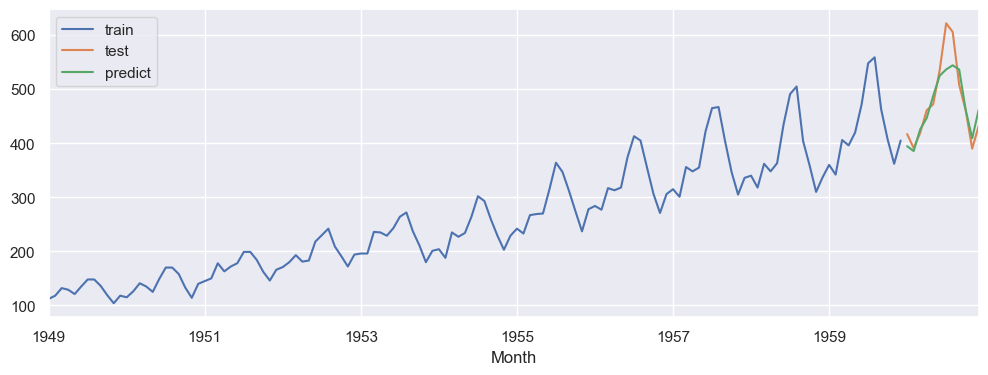

In [12]:
# 予測
y_pred = model_opt.predict(X_test)
y_pred = pd.DataFrame(y_pred, index=y_test.index, columns=["#Passengers"])

fig, ax = plt.subplots(figsize=(12, 4))
y_train.plot(y="#Passengers", ax=ax, label="train")
y_test.plot(y="#Passengers", ax=ax, label="test")
y_pred.plot(y="#Passengers", ax=ax, label="predict")
ax.legend()
plt.show()

In [13]:
mape = mean_absolute_percentage_error(y_test, model.predict(X_test))
mape_opt = mean_absolute_percentage_error(y_test, model_opt.predict(X_test))

print("[Before HPO] MAPE: {}%".format(round(mape*100, 2)))
print("[After  HPO] MAPE: {}%".format(round(mape_opt*100, 2)))

[Before HPO] MAPE: 8.51%
[After  HPO] MAPE: 4.85%


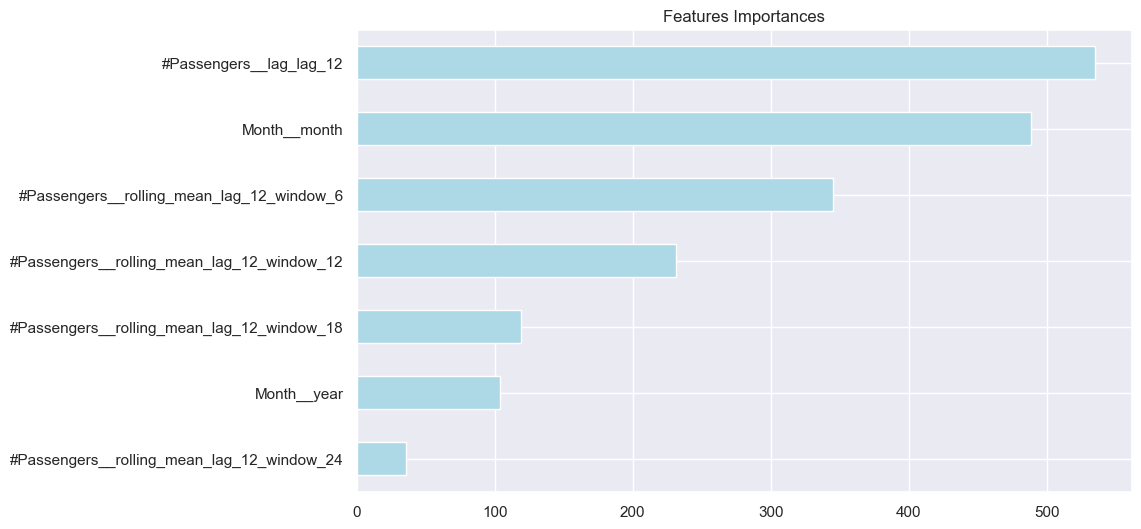

In [14]:
importances = pd.Series(data=model_opt.feature_importances_, index=model_opt.feature_name_)
importances_sorted = importances.sort_values()

plt.figure(figsize=(10, 6))
importances_sorted.plot(kind='barh', color='lightblue')
plt.title('Features Importances')
plt.show()

In [15]:
# ガーベッジコレクション.
import gc

gc.collect()
gc.collect()

0